In [1]:
import tifffile as tiff
import numpy as np
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import tifffile as tiff
import pickle
import torch
from pyiqa import create_metric
import os
import gc
import time
import shutil

2024-09-06 06:04:31.878590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
if not os.path.isdir('./model_best'):
    os.mkdir('./model_best')

if not os.path.isdir('./model_current'):
    os.mkdir('./model_current')

if not os.path.isdir('./preds'):
    os.mkdir('./preds')

In [2]:
def load_image(path):
    # This function is used to load grayscale images, if the number of channels in the image is three, the channel will be converted to one
    tif_image = tiff.imread(path)
    tif_array = np.array(tif_image).astype('float32')
    if len(tif_array.shape) == 3:
        tif_array = np.dot(tif_array[...,:3], [0.2989, 0.5870, 0.1140]).astype("float32")
    return tif_array
def split_array_with_dynamic_step(array, block_size=(256, 256), step=128):
    h, w = array.shape
    block_h, block_w = block_size
    blocks = []
    positions = []
    i = 0
    while i < h:
        if i + block_h > h:
            i = h - block_h  # Adjust i to fit the last block
        j = 0
        while j < w:
            if j + block_w > w:
                j = w - block_w  # Adjust j to fit the last block
            block = array[i:i + block_h, j:j + block_w]
            blocks.append(block)
            pos = np.zeros((block_h, block_w, 2), dtype=int)
            for m in range(block_h):
                for n in range(block_w):
                    pos[m, n] = (i + m, j + n)
            positions.append(pos)
            if j + block_w >= w:
                break
            j += step
        if i + block_h >= h:
            break
        i += step
    return blocks, positions
    
def reconstruct_image(blocks, positions, original_shape):
    h, w = original_shape
    reconstructed_image = np.zeros((h, w), dtype=float)
    count = np.zeros((h, w), dtype=int)

    for block, pos in zip(blocks, positions):
        block_h, block_w = block.shape
        for i in range(block_h):
            for j in range(block_w):
                x, y = pos[i, j]
                reconstructed_image[x, y] += block[i, j]
                count[x, y] += 1

    # Average the overlapping regions
    count[count == 0] = 1  # Prevent division by zero
    reconstructed_image /= count
    reconstructed_image = reconstructed_image.astype("float32")
    return reconstructed_image
    
def calculate_variances_and_sort(arrays):
    variances = [np.var(array) for array in arrays]
    #sorted_index = np.argsort(variances)[::-1]
    sorted_index = np.argsort(variances)
    return sorted_index, variances

def Uniform_size(image_npy,h,w):
    image = Image.fromarray(image_npy)
    resized_image = image.resize((w,h))
    resized_image_npy=np.array(resized_image)
    return resized_image_npy
def dataprocessing(imgs,patch_size):
    p_imgs = []
    for img in imgs:
        h,w = img.shape
        p_img = img.reshape(1, h, w, 1)
        p_imgs.append(p_img)
    datagen = N2V_DataGenerator()
    patch_shape = (patch_size,patch_size)
    patches = datagen.generate_patches_from_list(p_imgs, shape=patch_shape)
    train_val_split = int(patches.shape[0] * 0.8)
    X = patches[:train_val_split]
    X_val = patches[train_val_split:]
    return imgs, X, X_val
    
def get_batch_size(patch_size):
    memory_limit = 4096
    batch_size = 4096/patch_size
    return int(batch_size)

def get_iq_score(image,evaluator):
    #["liqe","nrqm","maniqa-kadid","tres"]
    device = torch.device("cpu")
    image_tensor = torch.tensor(image/255).unsqueeze(0).unsqueeze(0)
    iqe_metric = create_metric(evaluator,device=device)
    print(iqe_metric.lower_better)
    iqe_score = iqe_metric(image_tensor)
    score = iqe_score.item()

    # Clean up: delete variables and free memory
    del image_tensor
    del iqe_metric
    del iqe_score
    torch.cuda.empty_cache()
    gc.collect()
    return score

def get_pick_size(n):
    pick_size = n//10
    if not pick_size % 2:
        return pick_size
    else: 
        return pick_size-1

def get_max_loop(n):
    #max_loop = 2*n//pick_size -1
    max_loop = n//16
    return max_loop
    
def check_image_size(img):
    img_h, img_w = img.shape
    if (img_w >= 2048 and img_h >= 2048) or (img_h >= 2048 and img_w >= 2048):
        return True
    return False

def init_and_train_model(parameters,model_name,X,X_val):
    train_batch = parameters[0]
    t_e = parameters[1]
    patch_size = parameters[2]
    config = N2VConfig(X, unet_kern_size=3, 
                           unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=t_e, train_loss='mse', 
                           batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size), 
                           n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)
    model_name = model_name
    basedir = 'models'
    model = N2V(config, model_name, basedir=basedir)
    history = model.train(X, X_val)
    return model

def load_and_train_model(parameters,model_name,X,X_val):
    train_batch = parameters[0]
    t_e = parameters[1]
    patch_size = parameters[2]
    model_weights_path = "./model_current/weights_best.h5"
    config = N2VConfig(X, unet_kern_size=3, 
                           unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=t_e, train_loss='mse', 
                           batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size), 
                           n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)
    model_name = model_name
    basedir = 'models'
    model = N2V(config, model_name, basedir=basedir)
    model.keras_model.load_weights(model_weights_path)
    history = model.train(X, X_val)
    return model

def save_best_model_weight(model_name):
    src = f"./models/{model_name}/weights_best.h5"
    dst = "./model_best/weights_best.h5"
    shutil.copy(src, dst)

def save_current_model_weight(model_name):
    src = f"./models/{model_name}/weights_best.h5"
    dst = "./model_current/weights_best.h5"
    shutil.copy(src, dst)
    
def get_train_epoch(n):
    if n == 0:
      return 100
    elif n == 1:
      return 50
    else:
      return 20

def load_best_model(parameters,model_name):
    train_batch = parameters[0]
    t_e = parameters[1]
    patch_size = parameters[2]
    model_weights_path = "./model_best/weights_best.h5"
    config = N2VConfig(X, unet_kern_size=3, 
                           unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=t_e, train_loss='mse', 
                           batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size), 
                           n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)
    model_name = model_name
    basedir = 'models'
    model = N2V(config, model_name, basedir=basedir)
    model.keras_model.load_weights(model_weights_path)
    return model


In [3]:
from sklearn.cluster import KMeans
def balance_clusters(X, labels, kmeans):
    counts = np.bincount(labels)
    while max(counts) - min(counts) > 1:
        # Find the classes with the most and least samples
        max_cluster = np.argmax(counts)
        min_cluster = np.argmin(counts)
        
        # Find the sample closest to the center of the smallest class in the largest class
        max_cluster_indices = np.where(labels == max_cluster)[0]
        min_cluster_center = kmeans.cluster_centers_[min_cluster]
        
        distances = np.linalg.norm(X[max_cluster_indices] - min_cluster_center, axis=1)
        move_index = max_cluster_indices[np.argmin(distances)]
        
        # Move the sample to the smallest class
        labels[move_index] = min_cluster
        
        # Recalculate the sample size for each class
        counts = np.bincount(labels)
    
    return labels

def get_cluster_index(blocks):
    var = [np.var(i) for i in blocks]
    mean = [np.mean(i) for i in blocks]
    X = np.column_stack((var, mean))
    kmeans = KMeans(n_clusters=16, random_state=0)
    labels = kmeans.fit_predict(X)
    balanced_labels = balance_clusters(X, labels, kmeans)
    plt.scatter(X[:, 0], X[:, 1], c=balanced_labels, cmap='viridis')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
    plt.xlabel('Variance (var)')
    plt.ylabel('Mean (mean)')
    plt.title('Balanced KMeans Clustering')
    plt.show()
    # Check the number of samples for each class
    counts = np.bincount(balanced_labels)
    print(f"Samples per cluster: {counts}")
    cluster_dict = {key: [] for key in range(16)}
    for i in range(len(balanced_labels)):
        cluster_dict[balanced_labels[i]].append(i)
    for key in cluster_dict.keys():
        cluster_dict[key].sort()
        sorted_index,variances= calculate_variances_and_sort([blocks[i] for i in cluster_dict[key]])
        cluster_dict[key] = [cluster_dict[key][i] for i in sorted_index]
    
    return cluster_dict

In [5]:
paths = ["/root/data/HRTEM metal nanoclusters on GO/Au/1433 Au 1s_250kX_K3_200kV_15468.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Au/1434 Au 2s_50kX_K3_200kV_15471.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Au/1434 Au 2s_250kX_K3_200kV_15472.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Au/1435 Au 3s_250kX_K3_200kV_15475.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Au/20231218 IL TEM Au 1464 2s _250kX_K3_200kV_18047.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_200kX_K3_200kV_24837.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24827.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24830.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24832.tif",
         "/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24835.tif",
         "/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWCNT_K3_200kV_250kX_5164.tif",
         "/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWCNT_K3_200kV_250kX_5167.tif",
         "/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWCNT_K3_200kV_400kX_5165.tif",
         "/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWNT_K3_200kV_400kX_4653.tif",
         "/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWNT_K3_200kV_400kX_4662.tif",
         "/root/data/HRTEM of COF lattice/1 Co-tAPP-BDA-COF ipa_50kX_K3_200kV_22689.tif",
         "/root/data/HRTEM of COF lattice/1 Co-tAPP-BDA-COF ipa_10kX_K3_200kV_22692.tif",
         "/root/data/HRTEM of COF lattice/1 co-tapp-bda-cof-mwcnt_10kX_K3_200kV_22436.tif",
         "/root/data/HRTEM of COF lattice/1 Co-tAPP-BDA-COF ipa_10kX_K3_200kV_22678.tif",
         "/root/data/HRTEM of COF lattice/1 co-tapp-bda-cof-mwcnt_50kX_K3_200kV_22437.tif",
         "/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_400kX_K3_200kV_14646.tif",
         "/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_250kX_K3_200kV_14618.tif",
         "/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_250kX_K3_200kV_14619.tif",
         "/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_250kX_K3_200kV_14621.tif",
         "/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_400kX_K3_200kV_14638.tif",
         "/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24369.tif",
         "/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24370.tif",
         "/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24379.tif",
         "/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24382.tif",
         "/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24380.tif",
         ]

/root/data/HRTEM metal nanoclusters on GO/Au/1433 Au 1s_250kX_K3_200kV_15468.tif
0


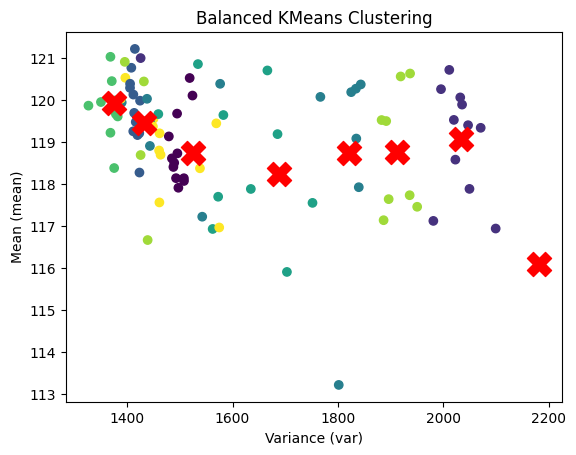

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(
2024-08-17 23:25:03.275639: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-17 23:25:03.275998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-17 23:25:03.319122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-17 23:25:03.321096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:03.0 name: Tesla P40 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 30 deviceMemorySize: 22.38GiB deviceMemoryBandwidth: 323.

2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6631.57it/s]
2024-08-17 23:25:06.410434: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-17 23:25:06.411439: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/100


2024-08-17 23:25:08.386554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-08-17 23:25:09.607788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


204/204 [==============================] - 17s 65ms/step - loss: 1.0670 - n2v_mse: 1.0670 - n2v_abs: 0.8133 - val_loss: 0.8287 - val_n2v_mse: 0.8287 - val_n2v_abs: 0.7237
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8546 - n2v_mse: 0.8546 - n2v_abs: 0.7362 - val_loss: 0.8077 - val_n2v_mse: 0.8077 - val_n2v_abs: 0.7131
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8411 - n2v_mse: 0.8411 - n2v_abs: 0.7285 - val_loss: 0.7782 - val_n2v_mse: 0.7782 - val_n2v_abs: 0.6972
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8503 - n2v_mse: 0.8503 - n2v_abs: 0.7321 - val_loss: 0.7777 - val_n2v_mse: 0.7777 - val_n2v_abs: 0.6971
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8495 - n2v_mse: 0.8495 - n2v_abs: 0.7326 - val_loss: 0.7767 - val_n2v_mse: 0.7767 - val_n2v_abs: 0.6964
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8439 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2516.71it/s]


Epoch 1/100
102/102 [==============================] - 14s 113ms/step - loss: 1.1972 - n2v_mse: 1.1972 - n2v_abs: 0.8621 - val_loss: 0.8526 - val_n2v_mse: 0.8513 - val_n2v_abs: 0.7372
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8586 - n2v_mse: 0.8586 - n2v_abs: 0.7342 - val_loss: 0.8010 - val_n2v_mse: 0.7988 - val_n2v_abs: 0.7117
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8324 - n2v_mse: 0.8324 - n2v_abs: 0.7231 - val_loss: 0.7767 - val_n2v_mse: 0.7738 - val_n2v_abs: 0.6993
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8517 - n2v_mse: 0.8517 - n2v_abs: 0.7324 - val_loss: 0.7790 - val_n2v_mse: 0.7756 - val_n2v_abs: 0.6977
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8442 - n2v_mse: 0.8442 - n2v_abs: 0.7291 - val_loss: 0.7804 - val_n2v_mse: 0.7768 - val_n2v_abs: 0.7006
Epoch 6/100
102/102 [==============================] - 11s 103ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 792.52it/s]


Epoch 1/100
51/51 [==============================] - 15s 227ms/step - loss: 1.3127 - n2v_mse: 1.3127 - n2v_abs: 0.9004 - val_loss: 0.9319 - val_n2v_mse: 0.9304 - val_n2v_abs: 0.7635
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8768 - n2v_mse: 0.8768 - n2v_abs: 0.7431 - val_loss: 0.9513 - val_n2v_mse: 0.9494 - val_n2v_abs: 0.7699
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8558 - n2v_mse: 0.8558 - n2v_abs: 0.7334 - val_loss: 0.8452 - val_n2v_mse: 0.8436 - val_n2v_abs: 0.7293
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8456 - n2v_mse: 0.8456 - n2v_abs: 0.7286 - val_loss: 0.8316 - val_n2v_mse: 0.8299 - val_n2v_abs: 0.7225
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8423 - n2v_mse: 0.8423 - n2v_abs: 0.7288 - val_loss: 0.8203 - val_n2v_mse: 0.8183 - val_n2v_abs: 0.7149
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8461 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.30it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6380.31it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.8404 - n2v_mse: 0.8404 - n2v_abs: 0.7288 - val_loss: 0.7686 - val_n2v_mse: 0.7684 - val_n2v_abs: 0.6959
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8322 - n2v_mse: 0.8322 - n2v_abs: 0.7253 - val_loss: 0.7942 - val_n2v_mse: 0.7940 - val_n2v_abs: 0.7078
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8393 - n2v_mse: 0.8393 - n2v_abs: 0.7277 - val_loss: 0.7710 - val_n2v_mse: 0.7708 - val_n2v_abs: 0.6957
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8297 - n2v_mse: 0.8297 - n2v_abs: 0.7218 - val_loss: 0.7660 - val_n2v_mse: 0.7658 - val_n2v_abs: 0.6949
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8410 - n2v_mse: 0.8410 - n2v_abs: 0.7269 - val_loss: 0.7652 - val_n2v_mse: 0.7650 - val_n2v_abs: 0.6941
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8224 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6645.50it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7947 - n2v_mse: 0.7947 - n2v_abs: 0.7073 - val_loss: 0.7992 - val_n2v_mse: 0.7990 - val_n2v_abs: 0.7108
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8051 - n2v_mse: 0.8051 - n2v_abs: 0.7116 - val_loss: 0.7985 - val_n2v_mse: 0.7983 - val_n2v_abs: 0.7103
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7969 - n2v_mse: 0.7969 - n2v_abs: 0.7084 - val_loss: 0.7970 - val_n2v_mse: 0.7968 - val_n2v_abs: 0.7092
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7929 - n2v_mse: 0.7929 - n2v_abs: 0.7052 - val_loss: 0.7918 - val_n2v_mse: 0.7916 - val_n2v_abs: 0.7059
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7971 - n2v_mse: 0.7971 - n2v_abs: 0.7042 - val_loss: 0.7974 - val_n2v_mse: 0.7972 - val_n2v_abs: 0.7097
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7872 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6691.00it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7768 - n2v_mse: 0.7768 - n2v_abs: 0.6971 - val_loss: 0.7501 - val_n2v_mse: 0.7499 - val_n2v_abs: 0.6863
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7701 - n2v_mse: 0.7701 - n2v_abs: 0.6915 - val_loss: 0.7552 - val_n2v_mse: 0.7551 - val_n2v_abs: 0.6891
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7717 - n2v_mse: 0.7717 - n2v_abs: 0.6953 - val_loss: 0.7451 - val_n2v_mse: 0.7449 - val_n2v_abs: 0.6827
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7603 - n2v_mse: 0.7603 - n2v_abs: 0.6904 - val_loss: 0.7493 - val_n2v_mse: 0.7491 - val_n2v_abs: 0.6859
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7696 - n2v_mse: 0.7696 - n2v_abs: 0.6928 - val_loss: 0.7551 - val_n2v_mse: 0.7549 - val_n2v_abs: 0.6891
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7744 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.13it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6645.58it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7489 - n2v_mse: 0.7489 - n2v_abs: 0.6835 - val_loss: 0.6977 - val_n2v_mse: 0.6976 - val_n2v_abs: 0.6660
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7549 - n2v_mse: 0.7549 - n2v_abs: 0.6894 - val_loss: 0.6887 - val_n2v_mse: 0.6886 - val_n2v_abs: 0.6611
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7419 - n2v_mse: 0.7419 - n2v_abs: 0.6823 - val_loss: 0.6887 - val_n2v_mse: 0.6887 - val_n2v_abs: 0.6620
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7477 - n2v_mse: 0.7477 - n2v_abs: 0.6843 - val_loss: 0.6934 - val_n2v_mse: 0.6933 - val_n2v_abs: 0.6640
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7502 - n2v_mse: 0.7502 - n2v_abs: 0.6855 - val_loss: 0.6954 - val_n2v_mse: 0.6953 - val_n2v_abs: 0.6651
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7455 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.26it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.10it/s]


/root/data/HRTEM metal nanoclusters on GO/Au/1434 Au 2s_50kX_K3_200kV_15471.tif
0


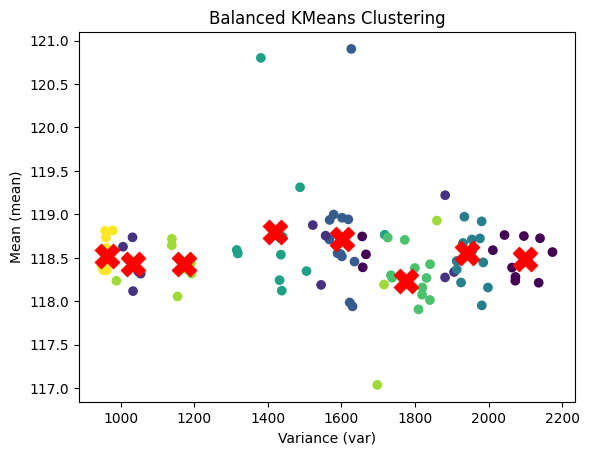

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6628.75it/s]


Epoch 1/100
204/204 [==============================] - 14s 62ms/step - loss: 1.1483 - n2v_mse: 1.1483 - n2v_abs: 0.8462 - val_loss: 0.7573 - val_n2v_mse: 0.7569 - val_n2v_abs: 0.6835
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.9172 - n2v_mse: 0.9172 - n2v_abs: 0.7589 - val_loss: 0.7044 - val_n2v_mse: 0.7040 - val_n2v_abs: 0.6569
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8957 - n2v_mse: 0.8957 - n2v_abs: 0.7510 - val_loss: 0.7027 - val_n2v_mse: 0.7023 - val_n2v_abs: 0.6543
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8980 - n2v_mse: 0.8980 - n2v_abs: 0.7516 - val_loss: 0.6955 - val_n2v_mse: 0.6951 - val_n2v_abs: 0.6508
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8821 - n2v_mse: 0.8821 - n2v_abs: 0.7410 - val_loss: 0.7090 - val_n2v_mse: 0.7086 - val_n2v_abs: 0.6552
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8944 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2691.15it/s]


Epoch 1/100
102/102 [==============================] - 13s 108ms/step - loss: 1.2062 - n2v_mse: 1.2062 - n2v_abs: 0.8682 - val_loss: 0.7786 - val_n2v_mse: 0.7749 - val_n2v_abs: 0.6957
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.9166 - n2v_mse: 0.9166 - n2v_abs: 0.7589 - val_loss: 0.7482 - val_n2v_mse: 0.7435 - val_n2v_abs: 0.6772
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8985 - n2v_mse: 0.8985 - n2v_abs: 0.7515 - val_loss: 0.7207 - val_n2v_mse: 0.7154 - val_n2v_abs: 0.6610
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.9078 - n2v_mse: 0.9078 - n2v_abs: 0.7527 - val_loss: 0.7321 - val_n2v_mse: 0.7262 - val_n2v_abs: 0.6672
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.9119 - n2v_mse: 0.9119 - n2v_abs: 0.7564 - val_loss: 0.7070 - val_n2v_mse: 0.7012 - val_n2v_abs: 0.6536
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.16it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 697.19it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.3681 - n2v_mse: 1.3681 - n2v_abs: 0.9262 - val_loss: 0.7788 - val_n2v_mse: 0.7741 - val_n2v_abs: 0.6968
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.9064 - n2v_mse: 0.9064 - n2v_abs: 0.7530 - val_loss: 0.7597 - val_n2v_mse: 0.7549 - val_n2v_abs: 0.6886
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.9105 - n2v_mse: 0.9105 - n2v_abs: 0.7571 - val_loss: 0.7404 - val_n2v_mse: 0.7355 - val_n2v_abs: 0.6773
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8951 - n2v_mse: 0.8951 - n2v_abs: 0.7509 - val_loss: 0.7243 - val_n2v_mse: 0.7192 - val_n2v_abs: 0.6681
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.9015 - n2v_mse: 0.9015 - n2v_abs: 0.7513 - val_loss: 0.7149 - val_n2v_mse: 0.7096 - val_n2v_abs: 0.6601
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.9027 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2574.81it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.8762 - n2v_mse: 0.8762 - n2v_abs: 0.7386 - val_loss: 0.6225 - val_n2v_mse: 0.6174 - val_n2v_abs: 0.6117
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8826 - n2v_mse: 0.8826 - n2v_abs: 0.7415 - val_loss: 0.6127 - val_n2v_mse: 0.6079 - val_n2v_abs: 0.6067
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8961 - n2v_mse: 0.8961 - n2v_abs: 0.7486 - val_loss: 0.6199 - val_n2v_mse: 0.6146 - val_n2v_abs: 0.6117
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8790 - n2v_mse: 0.8790 - n2v_abs: 0.7422 - val_loss: 0.6236 - val_n2v_mse: 0.6184 - val_n2v_abs: 0.6126
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8839 - n2v_mse: 0.8839 - n2v_abs: 0.7425 - val_loss: 0.6123 - val_n2v_mse: 0.6075 - val_n2v_abs: 0.6055
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8737 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2520.94it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.8453 - n2v_mse: 0.8453 - n2v_abs: 0.7233 - val_loss: 0.6289 - val_n2v_mse: 0.6230 - val_n2v_abs: 0.6106
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8490 - n2v_mse: 0.8490 - n2v_abs: 0.7250 - val_loss: 0.6243 - val_n2v_mse: 0.6183 - val_n2v_abs: 0.6073
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8548 - n2v_mse: 0.8548 - n2v_abs: 0.7301 - val_loss: 0.6269 - val_n2v_mse: 0.6209 - val_n2v_abs: 0.6087
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8514 - n2v_mse: 0.8514 - n2v_abs: 0.7286 - val_loss: 0.6230 - val_n2v_mse: 0.6173 - val_n2v_abs: 0.6065
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8560 - n2v_mse: 0.8560 - n2v_abs: 0.7306 - val_loss: 0.6313 - val_n2v_mse: 0.6252 - val_n2v_abs: 0.6117
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8551 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2382.21it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.8177 - n2v_mse: 0.8177 - n2v_abs: 0.7053 - val_loss: 0.6225 - val_n2v_mse: 0.6162 - val_n2v_abs: 0.6095
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8157 - n2v_mse: 0.8157 - n2v_abs: 0.7044 - val_loss: 0.6261 - val_n2v_mse: 0.6197 - val_n2v_abs: 0.6114
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8186 - n2v_mse: 0.8186 - n2v_abs: 0.7035 - val_loss: 0.6298 - val_n2v_mse: 0.6232 - val_n2v_abs: 0.6128
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8280 - n2v_mse: 0.8280 - n2v_abs: 0.7094 - val_loss: 0.6236 - val_n2v_mse: 0.6172 - val_n2v_abs: 0.6099
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8249 - n2v_mse: 0.8249 - n2v_abs: 0.7112 - val_loss: 0.6302 - val_n2v_mse: 0.6239 - val_n2v_abs: 0.6117
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8215 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.43it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2896.33it/s]


Epoch 1/20
102/102 [==============================] - 13s 108ms/step - loss: 0.8204 - n2v_mse: 0.8204 - n2v_abs: 0.7077 - val_loss: 0.6478 - val_n2v_mse: 0.6457 - val_n2v_abs: 0.6259
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8328 - n2v_mse: 0.8328 - n2v_abs: 0.7127 - val_loss: 0.6493 - val_n2v_mse: 0.6464 - val_n2v_abs: 0.6265
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8292 - n2v_mse: 0.8292 - n2v_abs: 0.7134 - val_loss: 0.6482 - val_n2v_mse: 0.6458 - val_n2v_abs: 0.6266
Epoch 4/20
102/102 [==============================] - 11s 103ms/step - loss: 0.8146 - n2v_mse: 0.8146 - n2v_abs: 0.7056 - val_loss: 0.6497 - val_n2v_mse: 0.6476 - val_n2v_abs: 0.6276
Epoch 5/20
102/102 [==============================] - 11s 103ms/step - loss: 0.8224 - n2v_mse: 0.8224 - n2v_abs: 0.7084 - val_loss: 0.6445 - val_n2v_mse: 0.6423 - val_n2v_abs: 0.6241
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8318 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2497.29it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.7976 - n2v_mse: 0.7976 - n2v_abs: 0.6970 - val_loss: 0.5920 - val_n2v_mse: 0.5884 - val_n2v_abs: 0.5901
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7852 - n2v_mse: 0.7852 - n2v_abs: 0.6940 - val_loss: 0.5905 - val_n2v_mse: 0.5872 - val_n2v_abs: 0.5894
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7915 - n2v_mse: 0.7915 - n2v_abs: 0.6960 - val_loss: 0.5998 - val_n2v_mse: 0.5962 - val_n2v_abs: 0.5944
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7985 - n2v_mse: 0.7985 - n2v_abs: 0.7010 - val_loss: 0.5967 - val_n2v_mse: 0.5932 - val_n2v_abs: 0.5913
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7938 - n2v_mse: 0.7938 - n2v_abs: 0.6967 - val_loss: 0.5897 - val_n2v_mse: 0.5861 - val_n2v_abs: 0.5889
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7915 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.26it/s]


/root/data/HRTEM metal nanoclusters on GO/Au/1434 Au 2s_250kX_K3_200kV_15472.tif
0


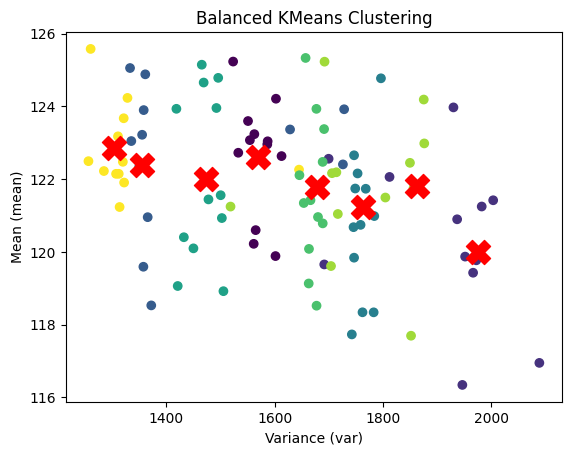

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6220.33it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.9804 - n2v_mse: 0.9804 - n2v_abs: 0.7818 - val_loss: 0.7672 - val_n2v_mse: 0.7671 - val_n2v_abs: 0.6980
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7849 - n2v_mse: 0.7849 - n2v_abs: 0.7036 - val_loss: 0.7319 - val_n2v_mse: 0.7317 - val_n2v_abs: 0.6800
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7732 - n2v_mse: 0.7732 - n2v_abs: 0.6984 - val_loss: 0.7260 - val_n2v_mse: 0.7258 - val_n2v_abs: 0.6760
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7617 - n2v_mse: 0.7617 - n2v_abs: 0.6941 - val_loss: 0.7293 - val_n2v_mse: 0.7291 - val_n2v_abs: 0.6773
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7865 - n2v_mse: 0.7865 - n2v_abs: 0.7057 - val_loss: 0.7217 - val_n2v_mse: 0.7215 - val_n2v_abs: 0.6731
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7699 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.21it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2506.51it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.0187 - n2v_mse: 1.0187 - n2v_abs: 0.8001 - val_loss: 0.8466 - val_n2v_mse: 0.8437 - val_n2v_abs: 0.7294
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8023 - n2v_mse: 0.8023 - n2v_abs: 0.7116 - val_loss: 0.7842 - val_n2v_mse: 0.7817 - val_n2v_abs: 0.7009
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7782 - n2v_mse: 0.7782 - n2v_abs: 0.7029 - val_loss: 0.7467 - val_n2v_mse: 0.7449 - val_n2v_abs: 0.6824
Epoch 4/100
102/102 [==============================] - 11s 103ms/step - loss: 0.7842 - n2v_mse: 0.7842 - n2v_abs: 0.7024 - val_loss: 0.7318 - val_n2v_mse: 0.7299 - val_n2v_abs: 0.6752
Epoch 5/100
102/102 [==============================] - 11s 103ms/step - loss: 0.7674 - n2v_mse: 0.7674 - n2v_abs: 0.6979 - val_loss: 0.7278 - val_n2v_mse: 0.7258 - val_n2v_abs: 0.6730
Epoch 6/100
102/102 [==============================] - 11s 103ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 720.59it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.4761 - n2v_mse: 1.4761 - n2v_abs: 0.9505 - val_loss: 0.8695 - val_n2v_mse: 0.8672 - val_n2v_abs: 0.7393
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7862 - n2v_mse: 0.7862 - n2v_abs: 0.7054 - val_loss: 0.8274 - val_n2v_mse: 0.8251 - val_n2v_abs: 0.7215
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7745 - n2v_mse: 0.7745 - n2v_abs: 0.6992 - val_loss: 0.8024 - val_n2v_mse: 0.8002 - val_n2v_abs: 0.7110
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7808 - n2v_mse: 0.7808 - n2v_abs: 0.7027 - val_loss: 0.7723 - val_n2v_mse: 0.7701 - val_n2v_abs: 0.6985
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7802 - n2v_mse: 0.7802 - n2v_abs: 0.7030 - val_loss: 0.7632 - val_n2v_mse: 0.7610 - val_n2v_abs: 0.6937
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7613 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6629.40it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.7137 - n2v_mse: 0.7137 - n2v_abs: 0.6689 - val_loss: 0.6826 - val_n2v_mse: 0.6825 - val_n2v_abs: 0.6547
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7101 - n2v_mse: 0.7101 - n2v_abs: 0.6686 - val_loss: 0.6603 - val_n2v_mse: 0.6602 - val_n2v_abs: 0.6446
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7044 - n2v_mse: 0.7044 - n2v_abs: 0.6630 - val_loss: 0.6574 - val_n2v_mse: 0.6573 - val_n2v_abs: 0.6434
Epoch 4/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7076 - n2v_mse: 0.7076 - n2v_abs: 0.6655 - val_loss: 0.6580 - val_n2v_mse: 0.6580 - val_n2v_abs: 0.6438
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7125 - n2v_mse: 0.7125 - n2v_abs: 0.6681 - val_loss: 0.6617 - val_n2v_mse: 0.6616 - val_n2v_abs: 0.6456
Epoch 6/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7037 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6651.97it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.6834 - n2v_mse: 0.6834 - n2v_abs: 0.6558 - val_loss: 0.7067 - val_n2v_mse: 0.7065 - val_n2v_abs: 0.6645
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6753 - n2v_mse: 0.6753 - n2v_abs: 0.6491 - val_loss: 0.7032 - val_n2v_mse: 0.7030 - val_n2v_abs: 0.6626
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6892 - n2v_mse: 0.6892 - n2v_abs: 0.6562 - val_loss: 0.7095 - val_n2v_mse: 0.7093 - val_n2v_abs: 0.6642
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6826 - n2v_mse: 0.6826 - n2v_abs: 0.6522 - val_loss: 0.7155 - val_n2v_mse: 0.7153 - val_n2v_abs: 0.6686
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6779 - n2v_mse: 0.6779 - n2v_abs: 0.6507 - val_loss: 0.7065 - val_n2v_mse: 0.7063 - val_n2v_abs: 0.6631
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6892 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6545.66it/s]


Epoch 1/20
204/204 [==============================] - 15s 62ms/step - loss: 0.7226 - n2v_mse: 0.7226 - n2v_abs: 0.6727 - val_loss: 0.6537 - val_n2v_mse: 0.6537 - val_n2v_abs: 0.6439
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7219 - n2v_mse: 0.7219 - n2v_abs: 0.6716 - val_loss: 0.6535 - val_n2v_mse: 0.6535 - val_n2v_abs: 0.6426
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7146 - n2v_mse: 0.7146 - n2v_abs: 0.6685 - val_loss: 0.6631 - val_n2v_mse: 0.6631 - val_n2v_abs: 0.6477
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7149 - n2v_mse: 0.7149 - n2v_abs: 0.6696 - val_loss: 0.6577 - val_n2v_mse: 0.6578 - val_n2v_abs: 0.6454
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7263 - n2v_mse: 0.7263 - n2v_abs: 0.6756 - val_loss: 0.6557 - val_n2v_mse: 0.6558 - val_n2v_abs: 0.6439
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7172 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


/root/data/HRTEM metal nanoclusters on GO/Au/1435 Au 3s_250kX_K3_200kV_15475.tif
0


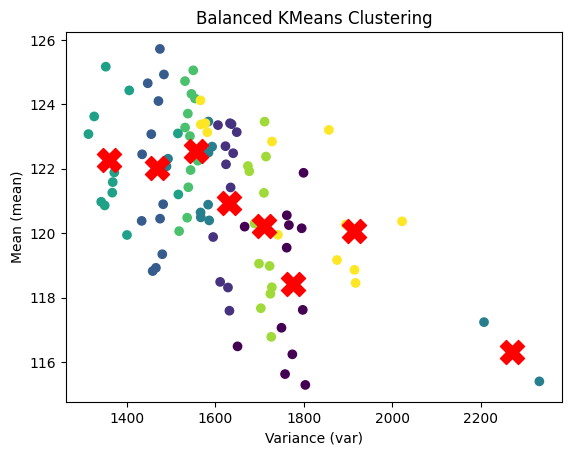

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6493.96it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.9481 - n2v_mse: 0.9481 - n2v_abs: 0.7618 - val_loss: 0.7671 - val_n2v_mse: 0.7672 - val_n2v_abs: 0.7024
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7002 - n2v_mse: 0.7002 - n2v_abs: 0.6648 - val_loss: 0.7147 - val_n2v_mse: 0.7148 - val_n2v_abs: 0.6744
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6906 - n2v_mse: 0.6906 - n2v_abs: 0.6598 - val_loss: 0.7166 - val_n2v_mse: 0.7166 - val_n2v_abs: 0.6730
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6949 - n2v_mse: 0.6949 - n2v_abs: 0.6637 - val_loss: 0.7128 - val_n2v_mse: 0.7129 - val_n2v_abs: 0.6736
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6968 - n2v_mse: 0.6968 - n2v_abs: 0.6639 - val_loss: 0.7119 - val_n2v_mse: 0.7119 - val_n2v_abs: 0.6719
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6721 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2551.72it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 0.9196 - n2v_mse: 0.9196 - n2v_abs: 0.7595 - val_loss: 0.8301 - val_n2v_mse: 0.8323 - val_n2v_abs: 0.7281
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7046 - n2v_mse: 0.7046 - n2v_abs: 0.6691 - val_loss: 0.7642 - val_n2v_mse: 0.7672 - val_n2v_abs: 0.6983
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6979 - n2v_mse: 0.6979 - n2v_abs: 0.6646 - val_loss: 0.7235 - val_n2v_mse: 0.7271 - val_n2v_abs: 0.6770
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6880 - n2v_mse: 0.6880 - n2v_abs: 0.6578 - val_loss: 0.7717 - val_n2v_mse: 0.7759 - val_n2v_abs: 0.7009
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6690 - n2v_mse: 0.6690 - n2v_abs: 0.6506 - val_loss: 0.7455 - val_n2v_mse: 0.7507 - val_n2v_abs: 0.6855
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 742.86it/s]


Epoch 1/100
51/51 [==============================] - 13s 211ms/step - loss: 1.0079 - n2v_mse: 1.0079 - n2v_abs: 0.7883 - val_loss: 0.9211 - val_n2v_mse: 0.9228 - val_n2v_abs: 0.7640
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7144 - n2v_mse: 0.7144 - n2v_abs: 0.6722 - val_loss: 0.8574 - val_n2v_mse: 0.8589 - val_n2v_abs: 0.7388
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6960 - n2v_mse: 0.6960 - n2v_abs: 0.6639 - val_loss: 0.8132 - val_n2v_mse: 0.8145 - val_n2v_abs: 0.7187
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6956 - n2v_mse: 0.6956 - n2v_abs: 0.6631 - val_loss: 0.7883 - val_n2v_mse: 0.7896 - val_n2v_abs: 0.7087
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6793 - n2v_mse: 0.6793 - n2v_abs: 0.6557 - val_loss: 0.7744 - val_n2v_mse: 0.7758 - val_n2v_abs: 0.7025
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6680 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2697.83it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.6833 - n2v_mse: 0.6833 - n2v_abs: 0.6575 - val_loss: 1.3255 - val_n2v_mse: 1.3267 - val_n2v_abs: 0.9128
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6908 - n2v_mse: 0.6908 - n2v_abs: 0.6611 - val_loss: 0.8587 - val_n2v_mse: 0.8558 - val_n2v_abs: 0.7350
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6888 - n2v_mse: 0.6888 - n2v_abs: 0.6601 - val_loss: 0.7627 - val_n2v_mse: 0.7629 - val_n2v_abs: 0.6966
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6749 - n2v_mse: 0.6749 - n2v_abs: 0.6527 - val_loss: 0.7490 - val_n2v_mse: 0.7484 - val_n2v_abs: 0.6902
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6867 - n2v_mse: 0.6867 - n2v_abs: 0.6572 - val_loss: 0.8110 - val_n2v_mse: 0.8100 - val_n2v_abs: 0.7156
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6892 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2665.14it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.7019 - n2v_mse: 0.7019 - n2v_abs: 0.6654 - val_loss: 0.8649 - val_n2v_mse: 0.8606 - val_n2v_abs: 0.7395
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6858 - n2v_mse: 0.6858 - n2v_abs: 0.6579 - val_loss: 0.8536 - val_n2v_mse: 0.8494 - val_n2v_abs: 0.7348
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6904 - n2v_mse: 0.6904 - n2v_abs: 0.6602 - val_loss: 0.8522 - val_n2v_mse: 0.8483 - val_n2v_abs: 0.7352
Epoch 4/20
102/102 [==============================] - 11s 103ms/step - loss: 0.6922 - n2v_mse: 0.6922 - n2v_abs: 0.6622 - val_loss: 0.9094 - val_n2v_mse: 0.9059 - val_n2v_abs: 0.7583
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6836 - n2v_mse: 0.6836 - n2v_abs: 0.6568 - val_loss: 0.8434 - val_n2v_mse: 0.8387 - val_n2v_abs: 0.7297
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6971 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.43it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2535.89it/s]


Epoch 1/20
102/102 [==============================] - 13s 108ms/step - loss: 0.6673 - n2v_mse: 0.6673 - n2v_abs: 0.6488 - val_loss: 0.8126 - val_n2v_mse: 0.8107 - val_n2v_abs: 0.7186
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6584 - n2v_mse: 0.6584 - n2v_abs: 0.6436 - val_loss: 0.7957 - val_n2v_mse: 0.7940 - val_n2v_abs: 0.7120
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6484 - n2v_mse: 0.6484 - n2v_abs: 0.6388 - val_loss: 0.7810 - val_n2v_mse: 0.7797 - val_n2v_abs: 0.7057
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6625 - n2v_mse: 0.6625 - n2v_abs: 0.6447 - val_loss: 0.7924 - val_n2v_mse: 0.7914 - val_n2v_abs: 0.7097
Epoch 5/20
102/102 [==============================] - 11s 103ms/step - loss: 0.6438 - n2v_mse: 0.6438 - n2v_abs: 0.6369 - val_loss: 0.8164 - val_n2v_mse: 0.8149 - val_n2v_abs: 0.7226
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6641 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2172.35it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.6597 - n2v_mse: 0.6597 - n2v_abs: 0.6455 - val_loss: 0.7377 - val_n2v_mse: 0.7397 - val_n2v_abs: 0.6855
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6557 - n2v_mse: 0.6557 - n2v_abs: 0.6437 - val_loss: 0.8614 - val_n2v_mse: 0.8624 - val_n2v_abs: 0.7397
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6542 - n2v_mse: 0.6542 - n2v_abs: 0.6434 - val_loss: 0.7327 - val_n2v_mse: 0.7349 - val_n2v_abs: 0.6833
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6587 - n2v_mse: 0.6587 - n2v_abs: 0.6447 - val_loss: 0.7844 - val_n2v_mse: 0.7874 - val_n2v_abs: 0.7082
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6597 - n2v_mse: 0.6597 - n2v_abs: 0.6464 - val_loss: 0.7319 - val_n2v_mse: 0.7339 - val_n2v_abs: 0.6834
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6524 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


/root/data/HRTEM metal nanoclusters on GO/Au/20231218 IL TEM Au 1464 2s _250kX_K3_200kV_18047.tif
0


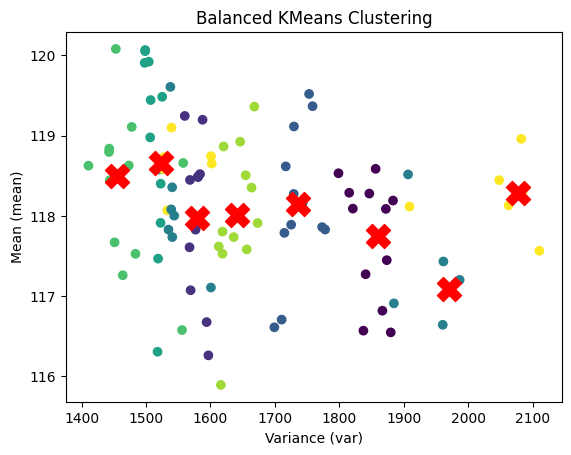

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6492.08it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.1453 - n2v_mse: 1.1453 - n2v_abs: 0.8386 - val_loss: 0.8638 - val_n2v_mse: 0.8638 - val_n2v_abs: 0.7391
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8136 - n2v_mse: 0.8136 - n2v_abs: 0.7183 - val_loss: 0.8086 - val_n2v_mse: 0.8086 - val_n2v_abs: 0.7135
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7899 - n2v_mse: 0.7899 - n2v_abs: 0.7062 - val_loss: 0.8027 - val_n2v_mse: 0.8027 - val_n2v_abs: 0.7105
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7943 - n2v_mse: 0.7943 - n2v_abs: 0.7093 - val_loss: 0.8159 - val_n2v_mse: 0.8158 - val_n2v_abs: 0.7156
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7876 - n2v_mse: 0.7876 - n2v_abs: 0.7052 - val_loss: 0.8161 - val_n2v_mse: 0.8160 - val_n2v_abs: 0.7172
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7928 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2744.47it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.1565 - n2v_mse: 1.1565 - n2v_abs: 0.8458 - val_loss: 0.8882 - val_n2v_mse: 0.8920 - val_n2v_abs: 0.7524
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8020 - n2v_mse: 0.8020 - n2v_abs: 0.7117 - val_loss: 0.8509 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7361
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7977 - n2v_mse: 0.7977 - n2v_abs: 0.7088 - val_loss: 0.8170 - val_n2v_mse: 0.8208 - val_n2v_abs: 0.7209
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7884 - n2v_mse: 0.7884 - n2v_abs: 0.7066 - val_loss: 0.8110 - val_n2v_mse: 0.8150 - val_n2v_abs: 0.7177
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7885 - n2v_mse: 0.7885 - n2v_abs: 0.7056 - val_loss: 0.8125 - val_n2v_mse: 0.8171 - val_n2v_abs: 0.7191
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 740.97it/s]


Epoch 1/100
51/51 [==============================] - 12s 211ms/step - loss: 1.2046 - n2v_mse: 1.2046 - n2v_abs: 0.8671 - val_loss: 0.9567 - val_n2v_mse: 0.9599 - val_n2v_abs: 0.7807
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8262 - n2v_mse: 0.8262 - n2v_abs: 0.7238 - val_loss: 0.9192 - val_n2v_mse: 0.9225 - val_n2v_abs: 0.7646
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8018 - n2v_mse: 0.8018 - n2v_abs: 0.7117 - val_loss: 0.8868 - val_n2v_mse: 0.8902 - val_n2v_abs: 0.7520
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8055 - n2v_mse: 0.8055 - n2v_abs: 0.7138 - val_loss: 0.8503 - val_n2v_mse: 0.8539 - val_n2v_abs: 0.7356
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7893 - n2v_mse: 0.7893 - n2v_abs: 0.7065 - val_loss: 0.8440 - val_n2v_mse: 0.8477 - val_n2v_abs: 0.7307
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8004 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 766.72it/s]


Epoch 1/50
51/51 [==============================] - 13s 211ms/step - loss: 0.7807 - n2v_mse: 0.7807 - n2v_abs: 0.7001 - val_loss: 0.9215 - val_n2v_mse: 0.9254 - val_n2v_abs: 0.7683
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7722 - n2v_mse: 0.7722 - n2v_abs: 0.6987 - val_loss: 0.8050 - val_n2v_mse: 0.8081 - val_n2v_abs: 0.7118
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7732 - n2v_mse: 0.7732 - n2v_abs: 0.6957 - val_loss: 0.7908 - val_n2v_mse: 0.7939 - val_n2v_abs: 0.7073
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 0.7868 - n2v_mse: 0.7868 - n2v_abs: 0.7057 - val_loss: 0.7811 - val_n2v_mse: 0.7842 - val_n2v_abs: 0.7016
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7629 - n2v_mse: 0.7629 - n2v_abs: 0.6939 - val_loss: 0.8021 - val_n2v_mse: 0.8054 - val_n2v_abs: 0.7099
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7649 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 728.26it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7536 - n2v_mse: 0.7536 - n2v_abs: 0.6886 - val_loss: 0.7407 - val_n2v_mse: 0.7444 - val_n2v_abs: 0.6840
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7437 - n2v_mse: 0.7437 - n2v_abs: 0.6845 - val_loss: 0.7422 - val_n2v_mse: 0.7458 - val_n2v_abs: 0.6826
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7539 - n2v_mse: 0.7539 - n2v_abs: 0.6893 - val_loss: 0.7354 - val_n2v_mse: 0.7390 - val_n2v_abs: 0.6801
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7502 - n2v_mse: 0.7502 - n2v_abs: 0.6880 - val_loss: 0.7558 - val_n2v_mse: 0.7594 - val_n2v_abs: 0.6901
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7401 - n2v_mse: 0.7401 - n2v_abs: 0.6824 - val_loss: 0.7534 - val_n2v_mse: 0.7568 - val_n2v_abs: 0.6886
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7442 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.47it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 718.74it/s]


Epoch 1/20
51/51 [==============================] - 13s 211ms/step - loss: 0.7207 - n2v_mse: 0.7207 - n2v_abs: 0.6753 - val_loss: 0.6788 - val_n2v_mse: 0.6785 - val_n2v_abs: 0.6587
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7279 - n2v_mse: 0.7279 - n2v_abs: 0.6785 - val_loss: 0.7006 - val_n2v_mse: 0.7001 - val_n2v_abs: 0.6677
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7323 - n2v_mse: 0.7323 - n2v_abs: 0.6799 - val_loss: 0.6811 - val_n2v_mse: 0.6806 - val_n2v_abs: 0.6596
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7270 - n2v_mse: 0.7270 - n2v_abs: 0.6780 - val_loss: 0.6723 - val_n2v_mse: 0.6718 - val_n2v_abs: 0.6547
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7278 - n2v_mse: 0.7278 - n2v_abs: 0.6782 - val_loss: 0.6743 - val_n2v_mse: 0.6740 - val_n2v_abs: 0.6567
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7391 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.08it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 813.34it/s]


Epoch 1/20
51/51 [==============================] - 12s 211ms/step - loss: 0.7154 - n2v_mse: 0.7154 - n2v_abs: 0.6720 - val_loss: 0.6540 - val_n2v_mse: 0.6534 - val_n2v_abs: 0.6444
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7194 - n2v_mse: 0.7194 - n2v_abs: 0.6747 - val_loss: 0.6367 - val_n2v_mse: 0.6362 - val_n2v_abs: 0.6363
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7217 - n2v_mse: 0.7217 - n2v_abs: 0.6754 - val_loss: 0.6273 - val_n2v_mse: 0.6268 - val_n2v_abs: 0.6308
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7103 - n2v_mse: 0.7103 - n2v_abs: 0.6707 - val_loss: 0.6415 - val_n2v_mse: 0.6411 - val_n2v_abs: 0.6377
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7101 - n2v_mse: 0.7101 - n2v_abs: 0.6722 - val_loss: 0.6375 - val_n2v_mse: 0.6371 - val_n2v_abs: 0.6347
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7217 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 732.54it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.7280 - n2v_mse: 0.7280 - n2v_abs: 0.6819 - val_loss: 0.7000 - val_n2v_mse: 0.6997 - val_n2v_abs: 0.6647
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7261 - n2v_mse: 0.7261 - n2v_abs: 0.6789 - val_loss: 0.7008 - val_n2v_mse: 0.7004 - val_n2v_abs: 0.6660
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7201 - n2v_mse: 0.7201 - n2v_abs: 0.6764 - val_loss: 0.6904 - val_n2v_mse: 0.6900 - val_n2v_abs: 0.6610
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7222 - n2v_mse: 0.7222 - n2v_abs: 0.6766 - val_loss: 0.6905 - val_n2v_mse: 0.6903 - val_n2v_abs: 0.6615
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7295 - n2v_mse: 0.7295 - n2v_abs: 0.6805 - val_loss: 0.6951 - val_n2v_mse: 0.6947 - val_n2v_abs: 0.6633
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7264 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_200kX_K3_200kV_24837.tif
0


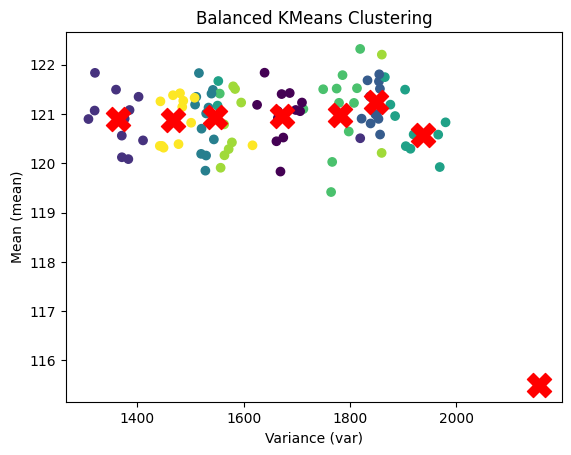

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6976.61it/s]


Epoch 1/100
204/204 [==============================] - 15s 62ms/step - loss: 1.0563 - n2v_mse: 1.0563 - n2v_abs: 0.8109 - val_loss: 0.8099 - val_n2v_mse: 0.8097 - val_n2v_abs: 0.7146
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7562 - n2v_mse: 0.7562 - n2v_abs: 0.6929 - val_loss: 0.7602 - val_n2v_mse: 0.7600 - val_n2v_abs: 0.6944
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7373 - n2v_mse: 0.7373 - n2v_abs: 0.6834 - val_loss: 0.7577 - val_n2v_mse: 0.7575 - val_n2v_abs: 0.6929
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7378 - n2v_mse: 0.7378 - n2v_abs: 0.6849 - val_loss: 0.7582 - val_n2v_mse: 0.7579 - val_n2v_abs: 0.6929
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7430 - n2v_mse: 0.7430 - n2v_abs: 0.6866 - val_loss: 0.7597 - val_n2v_mse: 0.7595 - val_n2v_abs: 0.6946
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7472 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2603.98it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 2.0862 - n2v_mse: 2.0862 - n2v_abs: 1.1294 - val_loss: 0.9219 - val_n2v_mse: 0.9195 - val_n2v_abs: 0.7659
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7723 - n2v_mse: 0.7723 - n2v_abs: 0.6996 - val_loss: 0.8385 - val_n2v_mse: 0.8363 - val_n2v_abs: 0.7284
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7469 - n2v_mse: 0.7469 - n2v_abs: 0.6876 - val_loss: 0.7810 - val_n2v_mse: 0.7786 - val_n2v_abs: 0.7036
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7443 - n2v_mse: 0.7443 - n2v_abs: 0.6860 - val_loss: 0.7702 - val_n2v_mse: 0.7679 - val_n2v_abs: 0.6997
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7531 - n2v_mse: 0.7531 - n2v_abs: 0.6894 - val_loss: 0.7668 - val_n2v_mse: 0.7643 - val_n2v_abs: 0.6979
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.41it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 704.60it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.0703 - n2v_mse: 1.0703 - n2v_abs: 0.8181 - val_loss: 0.9190 - val_n2v_mse: 0.9179 - val_n2v_abs: 0.7601
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7569 - n2v_mse: 0.7569 - n2v_abs: 0.6930 - val_loss: 0.8419 - val_n2v_mse: 0.8406 - val_n2v_abs: 0.7298
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7524 - n2v_mse: 0.7524 - n2v_abs: 0.6906 - val_loss: 0.8426 - val_n2v_mse: 0.8413 - val_n2v_abs: 0.7295
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7315 - n2v_mse: 0.7315 - n2v_abs: 0.6814 - val_loss: 0.8382 - val_n2v_mse: 0.8366 - val_n2v_abs: 0.7333
Epoch 5/100
51/51 [==============================] - 10s 201ms/step - loss: 0.7418 - n2v_mse: 0.7418 - n2v_abs: 0.6861 - val_loss: 0.7673 - val_n2v_mse: 0.7656 - val_n2v_abs: 0.6988
Epoch 6/100
51/51 [==============================] - 10s 201ms/step - loss: 0.7415 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2568.20it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.7356 - n2v_mse: 0.7356 - n2v_abs: 0.6798 - val_loss: 0.7925 - val_n2v_mse: 0.7905 - val_n2v_abs: 0.6991
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7482 - n2v_mse: 0.7482 - n2v_abs: 0.6865 - val_loss: 0.8328 - val_n2v_mse: 0.8314 - val_n2v_abs: 0.7182
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7428 - n2v_mse: 0.7428 - n2v_abs: 0.6859 - val_loss: 0.7349 - val_n2v_mse: 0.7332 - val_n2v_abs: 0.6820
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7403 - n2v_mse: 0.7403 - n2v_abs: 0.6841 - val_loss: 9.8644 - val_n2v_mse: 9.8754 - val_n2v_abs: 2.3504
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7414 - n2v_mse: 0.7414 - n2v_abs: 0.6841 - val_loss: 0.7618 - val_n2v_mse: 0.7605 - val_n2v_abs: 0.6928
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7384 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.44it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2767.58it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.7248 - n2v_mse: 0.7248 - n2v_abs: 0.6762 - val_loss: 0.7339 - val_n2v_mse: 0.7328 - val_n2v_abs: 0.6851
Epoch 2/20
102/102 [==============================] - 11s 103ms/step - loss: 0.7230 - n2v_mse: 0.7230 - n2v_abs: 0.6751 - val_loss: 0.7344 - val_n2v_mse: 0.7335 - val_n2v_abs: 0.6848
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7233 - n2v_mse: 0.7233 - n2v_abs: 0.6761 - val_loss: 0.7331 - val_n2v_mse: 0.7323 - val_n2v_abs: 0.6850
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7162 - n2v_mse: 0.7162 - n2v_abs: 0.6727 - val_loss: 0.7316 - val_n2v_mse: 0.7307 - val_n2v_abs: 0.6838
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7255 - n2v_mse: 0.7255 - n2v_abs: 0.6752 - val_loss: 0.7353 - val_n2v_mse: 0.7343 - val_n2v_abs: 0.6847
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7298 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.44it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2741.58it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.7180 - n2v_mse: 0.7180 - n2v_abs: 0.6745 - val_loss: 0.6940 - val_n2v_mse: 0.6949 - val_n2v_abs: 0.6637
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7024 - n2v_mse: 0.7024 - n2v_abs: 0.6658 - val_loss: 0.8626 - val_n2v_mse: 0.8651 - val_n2v_abs: 0.7376
Epoch 3/20
102/102 [==============================] - 11s 103ms/step - loss: 0.7092 - n2v_mse: 0.7092 - n2v_abs: 0.6667 - val_loss: 0.6905 - val_n2v_mse: 0.6919 - val_n2v_abs: 0.6624
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7154 - n2v_mse: 0.7154 - n2v_abs: 0.6739 - val_loss: 0.6915 - val_n2v_mse: 0.6926 - val_n2v_abs: 0.6631
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7102 - n2v_mse: 0.7102 - n2v_abs: 0.6699 - val_loss: 0.6934 - val_n2v_mse: 0.6944 - val_n2v_abs: 0.6639
Epoch 6/20
102/102 [==============================] - 11s 103ms/step - loss: 0.7264 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.41it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2599.48it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.6999 - n2v_mse: 0.6999 - n2v_abs: 0.6666 - val_loss: 0.7524 - val_n2v_mse: 0.7532 - val_n2v_abs: 0.6898
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7021 - n2v_mse: 0.7021 - n2v_abs: 0.6657 - val_loss: 0.7139 - val_n2v_mse: 0.7137 - val_n2v_abs: 0.6716
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6958 - n2v_mse: 0.6958 - n2v_abs: 0.6626 - val_loss: 0.6973 - val_n2v_mse: 0.6966 - val_n2v_abs: 0.6625
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7022 - n2v_mse: 0.7022 - n2v_abs: 0.6654 - val_loss: 0.6976 - val_n2v_mse: 0.6971 - val_n2v_abs: 0.6633
Epoch 5/20
102/102 [==============================] - 11s 103ms/step - loss: 0.6856 - n2v_mse: 0.6856 - n2v_abs: 0.6582 - val_loss: 0.6969 - val_n2v_mse: 0.6961 - val_n2v_abs: 0.6620
Epoch 6/20
102/102 [==============================] - 11s 103ms/step - loss: 0.7074 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2303.23it/s]


Epoch 1/20
102/102 [==============================] - 13s 108ms/step - loss: 0.7049 - n2v_mse: 0.7049 - n2v_abs: 0.6688 - val_loss: 0.6903 - val_n2v_mse: 0.6895 - val_n2v_abs: 0.6657
Epoch 2/20
102/102 [==============================] - 11s 103ms/step - loss: 0.7000 - n2v_mse: 0.7000 - n2v_abs: 0.6643 - val_loss: 1.1494 - val_n2v_mse: 1.1459 - val_n2v_abs: 0.8554
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6934 - n2v_mse: 0.6934 - n2v_abs: 0.6605 - val_loss: 0.6205 - val_n2v_mse: 0.6207 - val_n2v_abs: 0.6281
Epoch 4/20
102/102 [==============================] - 11s 103ms/step - loss: 0.6984 - n2v_mse: 0.6984 - n2v_abs: 0.6643 - val_loss: 0.6179 - val_n2v_mse: 0.6180 - val_n2v_abs: 0.6268
Epoch 5/20
102/102 [==============================] - 11s 103ms/step - loss: 0.7022 - n2v_mse: 0.7022 - n2v_abs: 0.6674 - val_loss: 0.6309 - val_n2v_mse: 0.6308 - val_n2v_abs: 0.6342
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6914 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.41it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24827.tif
0


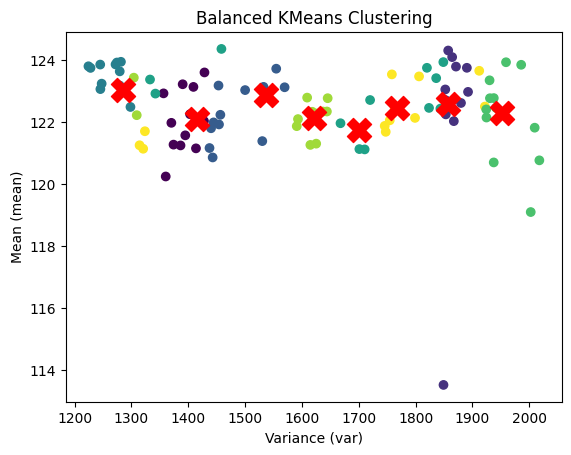

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6715.30it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.1865 - n2v_mse: 1.1865 - n2v_abs: 0.8538 - val_loss: 0.9802 - val_n2v_mse: 0.9803 - val_n2v_abs: 0.7907
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8130 - n2v_mse: 0.8130 - n2v_abs: 0.7133 - val_loss: 0.9842 - val_n2v_mse: 0.9843 - val_n2v_abs: 0.7908
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8005 - n2v_mse: 0.8005 - n2v_abs: 0.7076 - val_loss: 0.9528 - val_n2v_mse: 0.9529 - val_n2v_abs: 0.7771
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8006 - n2v_mse: 0.8006 - n2v_abs: 0.7060 - val_loss: 0.9669 - val_n2v_mse: 0.9670 - val_n2v_abs: 0.7824
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7948 - n2v_mse: 0.7948 - n2v_abs: 0.7037 - val_loss: 0.9457 - val_n2v_mse: 0.9459 - val_n2v_abs: 0.7740
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7831 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.26it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2577.68it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.1199 - n2v_mse: 1.1199 - n2v_abs: 0.8317 - val_loss: 1.0610 - val_n2v_mse: 1.0603 - val_n2v_abs: 0.8217
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8105 - n2v_mse: 0.8105 - n2v_abs: 0.7126 - val_loss: 0.9733 - val_n2v_mse: 0.9718 - val_n2v_abs: 0.7841
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7971 - n2v_mse: 0.7971 - n2v_abs: 0.7074 - val_loss: 0.9846 - val_n2v_mse: 0.9820 - val_n2v_abs: 0.7882
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7818 - n2v_mse: 0.7818 - n2v_abs: 0.6986 - val_loss: 0.9678 - val_n2v_mse: 0.9650 - val_n2v_abs: 0.7810
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7836 - n2v_mse: 0.7836 - n2v_abs: 0.6998 - val_loss: 0.9437 - val_n2v_mse: 0.9415 - val_n2v_abs: 0.7712
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 740.03it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1674 - n2v_mse: 1.1674 - n2v_abs: 0.8554 - val_loss: 1.0325 - val_n2v_mse: 1.0333 - val_n2v_abs: 0.8089
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8272 - n2v_mse: 0.8272 - n2v_abs: 0.7178 - val_loss: 1.0430 - val_n2v_mse: 1.0439 - val_n2v_abs: 0.8182
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7809 - n2v_mse: 0.7809 - n2v_abs: 0.7001 - val_loss: 0.9912 - val_n2v_mse: 0.9919 - val_n2v_abs: 0.7930
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7946 - n2v_mse: 0.7946 - n2v_abs: 0.7025 - val_loss: 1.1148 - val_n2v_mse: 1.1151 - val_n2v_abs: 0.8364
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7974 - n2v_mse: 0.7974 - n2v_abs: 0.7068 - val_loss: 1.0157 - val_n2v_mse: 1.0169 - val_n2v_abs: 0.8069
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7899 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.51it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2478.52it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.7701 - n2v_mse: 0.7701 - n2v_abs: 0.6957 - val_loss: 2.5814 - val_n2v_mse: 2.5746 - val_n2v_abs: 1.2382
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7592 - n2v_mse: 0.7592 - n2v_abs: 0.6903 - val_loss: 2.1557 - val_n2v_mse: 2.1536 - val_n2v_abs: 1.1135
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7669 - n2v_mse: 0.7669 - n2v_abs: 0.6927 - val_loss: 2.0025 - val_n2v_mse: 2.0226 - val_n2v_abs: 1.0437
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7535 - n2v_mse: 0.7535 - n2v_abs: 0.6895 - val_loss: 0.9969 - val_n2v_mse: 0.9960 - val_n2v_abs: 0.7961
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7511 - n2v_mse: 0.7511 - n2v_abs: 0.6852 - val_loss: 1.2807 - val_n2v_mse: 1.2808 - val_n2v_abs: 0.8863
Epoch 6/50
102/102 [==============================] - 11s 103ms/step - loss: 0.7647 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2471.86it/s]


Epoch 1/20
102/102 [==============================] - 13s 108ms/step - loss: 0.7495 - n2v_mse: 0.7495 - n2v_abs: 0.6849 - val_loss: 0.9106 - val_n2v_mse: 0.9093 - val_n2v_abs: 0.7604
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7376 - n2v_mse: 0.7376 - n2v_abs: 0.6783 - val_loss: 0.9354 - val_n2v_mse: 0.9335 - val_n2v_abs: 0.7719
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7504 - n2v_mse: 0.7504 - n2v_abs: 0.6845 - val_loss: 1.0361 - val_n2v_mse: 1.0347 - val_n2v_abs: 0.8071
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7326 - n2v_mse: 0.7326 - n2v_abs: 0.6759 - val_loss: 0.9013 - val_n2v_mse: 0.9018 - val_n2v_abs: 0.7571
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7433 - n2v_mse: 0.7433 - n2v_abs: 0.6820 - val_loss: 0.8971 - val_n2v_mse: 0.8968 - val_n2v_abs: 0.7546
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7450 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2503.92it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.7270 - n2v_mse: 0.7270 - n2v_abs: 0.6720 - val_loss: 0.8880 - val_n2v_mse: 0.8849 - val_n2v_abs: 0.7503
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7305 - n2v_mse: 0.7305 - n2v_abs: 0.6753 - val_loss: 0.9430 - val_n2v_mse: 0.9403 - val_n2v_abs: 0.7689
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7141 - n2v_mse: 0.7141 - n2v_abs: 0.6664 - val_loss: 0.8875 - val_n2v_mse: 0.8836 - val_n2v_abs: 0.7485
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7170 - n2v_mse: 0.7170 - n2v_abs: 0.6695 - val_loss: 0.9062 - val_n2v_mse: 0.9029 - val_n2v_abs: 0.7568
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7133 - n2v_mse: 0.7133 - n2v_abs: 0.6680 - val_loss: 0.8875 - val_n2v_mse: 0.8841 - val_n2v_abs: 0.7491
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7348 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.06it/s]


/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24830.tif
0


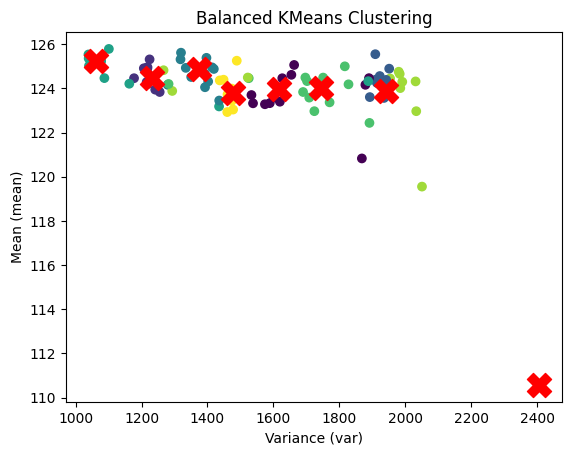

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6573.96it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.0591 - n2v_mse: 1.0591 - n2v_abs: 0.8088 - val_loss: 0.8794 - val_n2v_mse: 0.8793 - val_n2v_abs: 0.7486
Epoch 2/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8213 - n2v_mse: 0.8213 - n2v_abs: 0.7187 - val_loss: 0.8446 - val_n2v_mse: 0.8444 - val_n2v_abs: 0.7321
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8148 - n2v_mse: 0.8148 - n2v_abs: 0.7144 - val_loss: 0.8404 - val_n2v_mse: 0.8402 - val_n2v_abs: 0.7302
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8009 - n2v_mse: 0.8009 - n2v_abs: 0.7080 - val_loss: 0.8443 - val_n2v_mse: 0.8441 - val_n2v_abs: 0.7301
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8087 - n2v_mse: 0.8087 - n2v_abs: 0.7096 - val_loss: 0.8403 - val_n2v_mse: 0.8402 - val_n2v_abs: 0.7311
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8161 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.30it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2568.76it/s]


Epoch 1/100
102/102 [==============================] - 13s 108ms/step - loss: 1.0425 - n2v_mse: 1.0425 - n2v_abs: 0.8052 - val_loss: 0.9485 - val_n2v_mse: 0.9450 - val_n2v_abs: 0.7747
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8311 - n2v_mse: 0.8311 - n2v_abs: 0.7210 - val_loss: 0.8888 - val_n2v_mse: 0.8856 - val_n2v_abs: 0.7500
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8156 - n2v_mse: 0.8156 - n2v_abs: 0.7147 - val_loss: 0.8870 - val_n2v_mse: 0.8843 - val_n2v_abs: 0.7486
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8049 - n2v_mse: 0.8049 - n2v_abs: 0.7117 - val_loss: 0.8536 - val_n2v_mse: 0.8504 - val_n2v_abs: 0.7324
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8107 - n2v_mse: 0.8107 - n2v_abs: 0.7125 - val_loss: 0.8435 - val_n2v_mse: 0.8412 - val_n2v_abs: 0.7290
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 638.32it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.2132 - n2v_mse: 1.2132 - n2v_abs: 0.8627 - val_loss: 0.9519 - val_n2v_mse: 0.9501 - val_n2v_abs: 0.7790
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8225 - n2v_mse: 0.8225 - n2v_abs: 0.7186 - val_loss: 0.9181 - val_n2v_mse: 0.9162 - val_n2v_abs: 0.7651
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8165 - n2v_mse: 0.8165 - n2v_abs: 0.7148 - val_loss: 0.9039 - val_n2v_mse: 0.9019 - val_n2v_abs: 0.7585
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8100 - n2v_mse: 0.8100 - n2v_abs: 0.7123 - val_loss: 0.8874 - val_n2v_mse: 0.8854 - val_n2v_abs: 0.7479
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8150 - n2v_mse: 0.8150 - n2v_abs: 0.7149 - val_loss: 0.9090 - val_n2v_mse: 0.9069 - val_n2v_abs: 0.7597
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8039 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 750.48it/s]


Epoch 1/50
51/51 [==============================] - 13s 213ms/step - loss: 0.8081 - n2v_mse: 0.8081 - n2v_abs: 0.7084 - val_loss: 5.3346 - val_n2v_mse: 5.3373 - val_n2v_abs: 1.9039
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 0.8146 - n2v_mse: 0.8146 - n2v_abs: 0.7119 - val_loss: 10.8750 - val_n2v_mse: 10.8598 - val_n2v_abs: 2.6569
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 0.8174 - n2v_mse: 0.8174 - n2v_abs: 0.7142 - val_loss: 46.6989 - val_n2v_mse: 46.7496 - val_n2v_abs: 6.1604
Epoch 4/50
51/51 [==============================] - 10s 202ms/step - loss: 0.8155 - n2v_mse: 0.8155 - n2v_abs: 0.7109 - val_loss: 18.8152 - val_n2v_mse: 18.7163 - val_n2v_abs: 3.7041
Epoch 5/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8079 - n2v_mse: 0.8079 - n2v_abs: 0.7094 - val_loss: 7.4532 - val_n2v_mse: 7.4038 - val_n2v_abs: 2.2177
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7949 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.07it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 749.16it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.8099 - n2v_mse: 0.8099 - n2v_abs: 0.7088 - val_loss: 0.9120 - val_n2v_mse: 0.9091 - val_n2v_abs: 0.7526
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8068 - n2v_mse: 0.8068 - n2v_abs: 0.7067 - val_loss: 0.9245 - val_n2v_mse: 0.9216 - val_n2v_abs: 0.7576
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8146 - n2v_mse: 0.8146 - n2v_abs: 0.7133 - val_loss: 0.9893 - val_n2v_mse: 0.9853 - val_n2v_abs: 0.7803
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8194 - n2v_mse: 0.8194 - n2v_abs: 0.7142 - val_loss: 0.9425 - val_n2v_mse: 0.9393 - val_n2v_abs: 0.7652
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8065 - n2v_mse: 0.8065 - n2v_abs: 0.7062 - val_loss: 0.9175 - val_n2v_mse: 0.9146 - val_n2v_abs: 0.7553
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7983 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.44it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 705.54it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.8073 - n2v_mse: 0.8073 - n2v_abs: 0.7094 - val_loss: 0.9431 - val_n2v_mse: 0.9413 - val_n2v_abs: 0.7694
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7901 - n2v_mse: 0.7901 - n2v_abs: 0.7002 - val_loss: 2.3913 - val_n2v_mse: 2.3697 - val_n2v_abs: 1.1854
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8347 - n2v_mse: 0.8347 - n2v_abs: 0.7214 - val_loss: 0.9392 - val_n2v_mse: 0.9373 - val_n2v_abs: 0.7668
Epoch 4/20
51/51 [==============================] - 10s 201ms/step - loss: 0.8043 - n2v_mse: 0.8043 - n2v_abs: 0.7060 - val_loss: 1.0406 - val_n2v_mse: 1.0373 - val_n2v_abs: 0.8022
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8074 - n2v_mse: 0.8074 - n2v_abs: 0.7093 - val_loss: 1.5823 - val_n2v_mse: 1.5713 - val_n2v_abs: 0.9606
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7966 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24832.tif
0


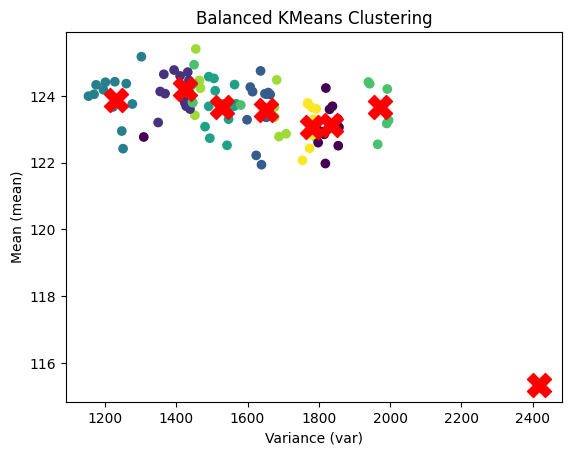

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6736.30it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.0758 - n2v_mse: 1.0758 - n2v_abs: 0.8157 - val_loss: 0.9271 - val_n2v_mse: 0.9269 - val_n2v_abs: 0.7660
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7902 - n2v_mse: 0.7902 - n2v_abs: 0.7083 - val_loss: 0.9116 - val_n2v_mse: 0.9115 - val_n2v_abs: 0.7601
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7839 - n2v_mse: 0.7839 - n2v_abs: 0.7039 - val_loss: 0.9126 - val_n2v_mse: 0.9124 - val_n2v_abs: 0.7607
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7956 - n2v_mse: 0.7956 - n2v_abs: 0.7081 - val_loss: 0.9093 - val_n2v_mse: 0.9091 - val_n2v_abs: 0.7591
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7799 - n2v_mse: 0.7799 - n2v_abs: 0.7016 - val_loss: 0.9066 - val_n2v_mse: 0.9065 - val_n2v_abs: 0.7578
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7768 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2533.05it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.0216 - n2v_mse: 1.0216 - n2v_abs: 0.7940 - val_loss: 1.0063 - val_n2v_mse: 1.0024 - val_n2v_abs: 0.7986
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7847 - n2v_mse: 0.7847 - n2v_abs: 0.7029 - val_loss: 0.9589 - val_n2v_mse: 0.9552 - val_n2v_abs: 0.7801
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7784 - n2v_mse: 0.7784 - n2v_abs: 0.6997 - val_loss: 0.9437 - val_n2v_mse: 0.9399 - val_n2v_abs: 0.7742
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7752 - n2v_mse: 0.7752 - n2v_abs: 0.6998 - val_loss: 0.9517 - val_n2v_mse: 0.9484 - val_n2v_abs: 0.7777
Epoch 5/100
102/102 [==============================] - 11s 103ms/step - loss: 0.7720 - n2v_mse: 0.7720 - n2v_abs: 0.6979 - val_loss: 0.9397 - val_n2v_mse: 0.9366 - val_n2v_abs: 0.7730
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.38it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 632.51it/s]


Epoch 1/100
51/51 [==============================] - 13s 211ms/step - loss: 1.2403 - n2v_mse: 1.2403 - n2v_abs: 0.8732 - val_loss: 1.0261 - val_n2v_mse: 1.0252 - val_n2v_abs: 0.8091
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8069 - n2v_mse: 0.8069 - n2v_abs: 0.7124 - val_loss: 1.0090 - val_n2v_mse: 1.0080 - val_n2v_abs: 0.8031
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7886 - n2v_mse: 0.7886 - n2v_abs: 0.7036 - val_loss: 0.9785 - val_n2v_mse: 0.9775 - val_n2v_abs: 0.7910
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7819 - n2v_mse: 0.7819 - n2v_abs: 0.7022 - val_loss: 0.9635 - val_n2v_mse: 0.9625 - val_n2v_abs: 0.7845
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7666 - n2v_mse: 0.7666 - n2v_abs: 0.6961 - val_loss: 0.9551 - val_n2v_mse: 0.9540 - val_n2v_abs: 0.7808
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7698 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 714.39it/s]


Epoch 1/50
51/51 [==============================] - 13s 211ms/step - loss: 0.7761 - n2v_mse: 0.7761 - n2v_abs: 0.6988 - val_loss: 0.9872 - val_n2v_mse: 0.9870 - val_n2v_abs: 0.7937
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7573 - n2v_mse: 0.7573 - n2v_abs: 0.6898 - val_loss: 0.9574 - val_n2v_mse: 0.9570 - val_n2v_abs: 0.7803
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7721 - n2v_mse: 0.7721 - n2v_abs: 0.6975 - val_loss: 1.3670 - val_n2v_mse: 1.3667 - val_n2v_abs: 0.8877
Epoch 4/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7643 - n2v_mse: 0.7643 - n2v_abs: 0.6911 - val_loss: 1.1980 - val_n2v_mse: 1.1958 - val_n2v_abs: 0.8520
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7550 - n2v_mse: 0.7550 - n2v_abs: 0.6905 - val_loss: 1.2814 - val_n2v_mse: 1.2801 - val_n2v_abs: 0.8748
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7659 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 726.16it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7790 - n2v_mse: 0.7790 - n2v_abs: 0.7004 - val_loss: 0.9423 - val_n2v_mse: 0.9424 - val_n2v_abs: 0.7712
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7829 - n2v_mse: 0.7829 - n2v_abs: 0.7024 - val_loss: 0.9259 - val_n2v_mse: 0.9260 - val_n2v_abs: 0.7654
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7812 - n2v_mse: 0.7812 - n2v_abs: 0.7002 - val_loss: 0.9417 - val_n2v_mse: 0.9418 - val_n2v_abs: 0.7712
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7937 - n2v_mse: 0.7937 - n2v_abs: 0.7038 - val_loss: 0.9461 - val_n2v_mse: 0.9460 - val_n2v_abs: 0.7734
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7821 - n2v_mse: 0.7821 - n2v_abs: 0.7005 - val_loss: 0.9630 - val_n2v_mse: 0.9628 - val_n2v_abs: 0.7794
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7776 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.33it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 743.23it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.7410 - n2v_mse: 0.7410 - n2v_abs: 0.6834 - val_loss: 0.8246 - val_n2v_mse: 0.8283 - val_n2v_abs: 0.7216
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7454 - n2v_mse: 0.7454 - n2v_abs: 0.6856 - val_loss: 0.8509 - val_n2v_mse: 0.8541 - val_n2v_abs: 0.7334
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7514 - n2v_mse: 0.7514 - n2v_abs: 0.6855 - val_loss: 0.8142 - val_n2v_mse: 0.8178 - val_n2v_abs: 0.7173
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7425 - n2v_mse: 0.7425 - n2v_abs: 0.6834 - val_loss: 1.6451 - val_n2v_mse: 1.6670 - val_n2v_abs: 0.9513
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7448 - n2v_mse: 0.7448 - n2v_abs: 0.6857 - val_loss: 0.8025 - val_n2v_mse: 0.8058 - val_n2v_abs: 0.7118
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7325 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.47it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


/root/data/HRTEM metal nanoclusters on GO/Mo/1769 Mo 5s_250kX_K3_200kV_24835.tif
0


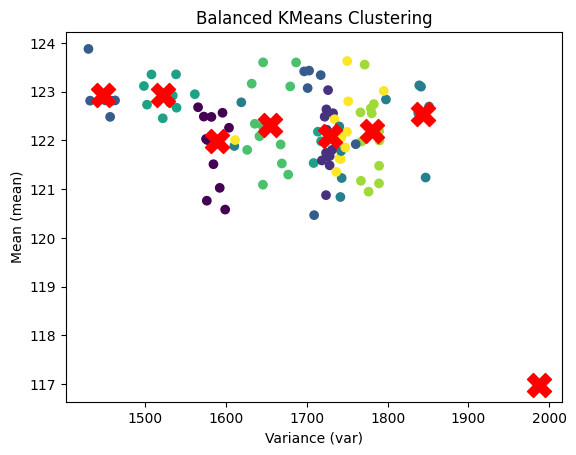

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6915.69it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.8952 - n2v_mse: 0.8952 - n2v_abs: 0.7493 - val_loss: 0.7690 - val_n2v_mse: 0.7689 - val_n2v_abs: 0.7011
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6922 - n2v_mse: 0.6922 - n2v_abs: 0.6654 - val_loss: 0.7098 - val_n2v_mse: 0.7097 - val_n2v_abs: 0.6712
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6926 - n2v_mse: 0.6926 - n2v_abs: 0.6634 - val_loss: 0.7092 - val_n2v_mse: 0.7092 - val_n2v_abs: 0.6701
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6824 - n2v_mse: 0.6824 - n2v_abs: 0.6565 - val_loss: 0.7058 - val_n2v_mse: 0.7057 - val_n2v_abs: 0.6689
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6825 - n2v_mse: 0.6825 - n2v_abs: 0.6577 - val_loss: 0.7359 - val_n2v_mse: 0.7358 - val_n2v_abs: 0.6816
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6787 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2546.51it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.1182 - n2v_mse: 1.1182 - n2v_abs: 0.8306 - val_loss: 0.8342 - val_n2v_mse: 0.8388 - val_n2v_abs: 0.7310
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7016 - n2v_mse: 0.7016 - n2v_abs: 0.6683 - val_loss: 0.7752 - val_n2v_mse: 0.7790 - val_n2v_abs: 0.7047
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6858 - n2v_mse: 0.6858 - n2v_abs: 0.6600 - val_loss: 0.7198 - val_n2v_mse: 0.7235 - val_n2v_abs: 0.6794
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6739 - n2v_mse: 0.6739 - n2v_abs: 0.6555 - val_loss: 0.7029 - val_n2v_mse: 0.7060 - val_n2v_abs: 0.6716
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6765 - n2v_mse: 0.6765 - n2v_abs: 0.6556 - val_loss: 0.7015 - val_n2v_mse: 0.7052 - val_n2v_abs: 0.6704
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.42it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 723.29it/s]


Epoch 1/100
51/51 [==============================] - 13s 211ms/step - loss: 1.0485 - n2v_mse: 1.0485 - n2v_abs: 0.8088 - val_loss: 0.8747 - val_n2v_mse: 0.8745 - val_n2v_abs: 0.7478
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6917 - n2v_mse: 0.6917 - n2v_abs: 0.6637 - val_loss: 0.8087 - val_n2v_mse: 0.8086 - val_n2v_abs: 0.7207
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6807 - n2v_mse: 0.6807 - n2v_abs: 0.6574 - val_loss: 0.7704 - val_n2v_mse: 0.7703 - val_n2v_abs: 0.7045
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6868 - n2v_mse: 0.6868 - n2v_abs: 0.6611 - val_loss: 0.7416 - val_n2v_mse: 0.7414 - val_n2v_abs: 0.6893
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6791 - n2v_mse: 0.6791 - n2v_abs: 0.6571 - val_loss: 0.7173 - val_n2v_mse: 0.7172 - val_n2v_abs: 0.6794
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6773 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6564.35it/s]


Epoch 1/50
204/204 [==============================] - 15s 62ms/step - loss: 0.6880 - n2v_mse: 0.6880 - n2v_abs: 0.6612 - val_loss: 0.8054 - val_n2v_mse: 0.8056 - val_n2v_abs: 0.7139
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.6876 - n2v_mse: 0.6876 - n2v_abs: 0.6631 - val_loss: 1.2029 - val_n2v_mse: 1.2025 - val_n2v_abs: 0.8734
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.6884 - n2v_mse: 0.6884 - n2v_abs: 0.6621 - val_loss: 0.6885 - val_n2v_mse: 0.6884 - val_n2v_abs: 0.6623
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.6839 - n2v_mse: 0.6839 - n2v_abs: 0.6597 - val_loss: 0.6889 - val_n2v_mse: 0.6889 - val_n2v_abs: 0.6626
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.6890 - n2v_mse: 0.6890 - n2v_abs: 0.6593 - val_loss: 0.6842 - val_n2v_mse: 0.6841 - val_n2v_abs: 0.6606
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.6932 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.47it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6960.64it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.6697 - n2v_mse: 0.6697 - n2v_abs: 0.6506 - val_loss: 0.7260 - val_n2v_mse: 0.7261 - val_n2v_abs: 0.6779
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6702 - n2v_mse: 0.6702 - n2v_abs: 0.6517 - val_loss: 0.6980 - val_n2v_mse: 0.6982 - val_n2v_abs: 0.6638
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6906 - n2v_mse: 0.6906 - n2v_abs: 0.6625 - val_loss: 0.6973 - val_n2v_mse: 0.6975 - val_n2v_abs: 0.6636
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6658 - n2v_mse: 0.6658 - n2v_abs: 0.6509 - val_loss: 0.6976 - val_n2v_mse: 0.6978 - val_n2v_abs: 0.6632
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6701 - n2v_mse: 0.6701 - n2v_abs: 0.6531 - val_loss: 0.7048 - val_n2v_mse: 0.7050 - val_n2v_abs: 0.6665
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6758 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6154.08it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.6916 - n2v_mse: 0.6916 - n2v_abs: 0.6628 - val_loss: 0.7169 - val_n2v_mse: 0.7170 - val_n2v_abs: 0.6751
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6864 - n2v_mse: 0.6864 - n2v_abs: 0.6582 - val_loss: 0.7148 - val_n2v_mse: 0.7149 - val_n2v_abs: 0.6746
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6836 - n2v_mse: 0.6836 - n2v_abs: 0.6590 - val_loss: 0.7145 - val_n2v_mse: 0.7146 - val_n2v_abs: 0.6751
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6870 - n2v_mse: 0.6870 - n2v_abs: 0.6605 - val_loss: 0.7411 - val_n2v_mse: 0.7412 - val_n2v_abs: 0.6876
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6819 - n2v_mse: 0.6819 - n2v_abs: 0.6596 - val_loss: 0.7180 - val_n2v_mse: 0.7181 - val_n2v_abs: 0.6771
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6961 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6213.03it/s]


Epoch 1/20
204/204 [==============================] - 15s 62ms/step - loss: 0.6741 - n2v_mse: 0.6741 - n2v_abs: 0.6536 - val_loss: 0.7326 - val_n2v_mse: 0.7326 - val_n2v_abs: 0.6802
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6643 - n2v_mse: 0.6643 - n2v_abs: 0.6485 - val_loss: 0.7503 - val_n2v_mse: 0.7503 - val_n2v_abs: 0.6897
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6683 - n2v_mse: 0.6683 - n2v_abs: 0.6501 - val_loss: 0.7320 - val_n2v_mse: 0.7320 - val_n2v_abs: 0.6806
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6621 - n2v_mse: 0.6621 - n2v_abs: 0.6494 - val_loss: 0.7331 - val_n2v_mse: 0.7331 - val_n2v_abs: 0.6809
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6676 - n2v_mse: 0.6676 - n2v_abs: 0.6495 - val_loss: 0.7400 - val_n2v_mse: 0.7399 - val_n2v_abs: 0.6844
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6651 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6363.31it/s]


Epoch 1/20
204/204 [==============================] - 15s 62ms/step - loss: 0.6595 - n2v_mse: 0.6595 - n2v_abs: 0.6456 - val_loss: 0.6992 - val_n2v_mse: 0.6992 - val_n2v_abs: 0.6673
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6552 - n2v_mse: 0.6552 - n2v_abs: 0.6463 - val_loss: 0.6997 - val_n2v_mse: 0.6997 - val_n2v_abs: 0.6674
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6499 - n2v_mse: 0.6499 - n2v_abs: 0.6439 - val_loss: 0.6970 - val_n2v_mse: 0.6970 - val_n2v_abs: 0.6659
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6461 - n2v_mse: 0.6461 - n2v_abs: 0.6416 - val_loss: 0.7031 - val_n2v_mse: 0.7030 - val_n2v_abs: 0.6690
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6566 - n2v_mse: 0.6566 - n2v_abs: 0.6448 - val_loss: 0.6988 - val_n2v_mse: 0.6988 - val_n2v_abs: 0.6672
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.6600 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWCNT_K3_200kV_250kX_5164.tif
0


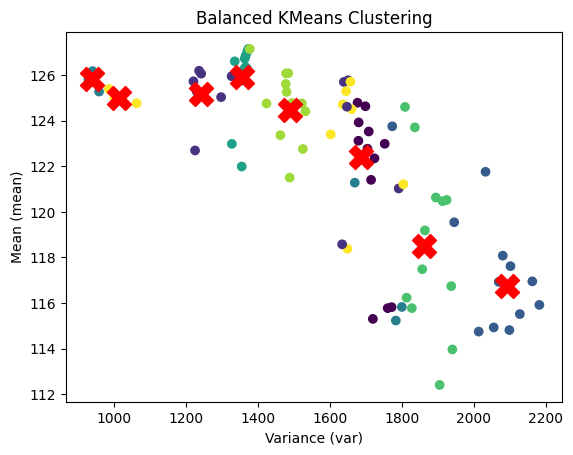

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6827.20it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.9671 - n2v_mse: 0.9671 - n2v_abs: 0.7799 - val_loss: 0.7839 - val_n2v_mse: 0.7841 - val_n2v_abs: 0.7090
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7481 - n2v_mse: 0.7481 - n2v_abs: 0.6890 - val_loss: 0.7468 - val_n2v_mse: 0.7470 - val_n2v_abs: 0.6894
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7346 - n2v_mse: 0.7346 - n2v_abs: 0.6854 - val_loss: 0.7476 - val_n2v_mse: 0.7479 - val_n2v_abs: 0.6905
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7445 - n2v_mse: 0.7445 - n2v_abs: 0.6884 - val_loss: 0.7440 - val_n2v_mse: 0.7443 - val_n2v_abs: 0.6879
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7339 - n2v_mse: 0.7339 - n2v_abs: 0.6842 - val_loss: 0.7419 - val_n2v_mse: 0.7422 - val_n2v_abs: 0.6874
Epoch 6/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7231 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2748.51it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.0575 - n2v_mse: 1.0575 - n2v_abs: 0.8123 - val_loss: 0.8689 - val_n2v_mse: 0.8717 - val_n2v_abs: 0.7408
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7495 - n2v_mse: 0.7495 - n2v_abs: 0.6909 - val_loss: 0.8158 - val_n2v_mse: 0.8193 - val_n2v_abs: 0.7184
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7432 - n2v_mse: 0.7432 - n2v_abs: 0.6876 - val_loss: 0.7846 - val_n2v_mse: 0.7879 - val_n2v_abs: 0.7035
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7307 - n2v_mse: 0.7307 - n2v_abs: 0.6819 - val_loss: 0.7665 - val_n2v_mse: 0.7700 - val_n2v_abs: 0.6951
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7371 - n2v_mse: 0.7371 - n2v_abs: 0.6858 - val_loss: 0.7640 - val_n2v_mse: 0.7678 - val_n2v_abs: 0.6937
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.38it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 753.47it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 1.2842 - n2v_mse: 1.2842 - n2v_abs: 0.8990 - val_loss: 0.8644 - val_n2v_mse: 0.8653 - val_n2v_abs: 0.7450
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7420 - n2v_mse: 0.7420 - n2v_abs: 0.6875 - val_loss: 0.8450 - val_n2v_mse: 0.8460 - val_n2v_abs: 0.7371
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7315 - n2v_mse: 0.7315 - n2v_abs: 0.6808 - val_loss: 0.8160 - val_n2v_mse: 0.8175 - val_n2v_abs: 0.7229
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7390 - n2v_mse: 0.7390 - n2v_abs: 0.6842 - val_loss: 0.7965 - val_n2v_mse: 0.7982 - val_n2v_abs: 0.7137
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7389 - n2v_mse: 0.7389 - n2v_abs: 0.6846 - val_loss: 0.7879 - val_n2v_mse: 0.7897 - val_n2v_abs: 0.7091
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7279 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 739.48it/s]


Epoch 1/50
51/51 [==============================] - 13s 211ms/step - loss: 0.7971 - n2v_mse: 0.7971 - n2v_abs: 0.7092 - val_loss: 0.8521 - val_n2v_mse: 0.8509 - val_n2v_abs: 0.7330
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 0.8026 - n2v_mse: 0.8026 - n2v_abs: 0.7087 - val_loss: 0.8632 - val_n2v_mse: 0.8620 - val_n2v_abs: 0.7392
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7927 - n2v_mse: 0.7927 - n2v_abs: 0.7059 - val_loss: 1.0317 - val_n2v_mse: 1.0312 - val_n2v_abs: 0.8022
Epoch 4/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7769 - n2v_mse: 0.7769 - n2v_abs: 0.7021 - val_loss: 0.8999 - val_n2v_mse: 0.8983 - val_n2v_abs: 0.7572
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7909 - n2v_mse: 0.7909 - n2v_abs: 0.7086 - val_loss: 0.8521 - val_n2v_mse: 0.8504 - val_n2v_abs: 0.7323
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7941 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 710.95it/s]


Epoch 1/20
51/51 [==============================] - 13s 211ms/step - loss: 0.7453 - n2v_mse: 0.7453 - n2v_abs: 0.6838 - val_loss: 0.9062 - val_n2v_mse: 0.9087 - val_n2v_abs: 0.7603
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7459 - n2v_mse: 0.7459 - n2v_abs: 0.6852 - val_loss: 0.8777 - val_n2v_mse: 0.8801 - val_n2v_abs: 0.7478
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7222 - n2v_mse: 0.7222 - n2v_abs: 0.6734 - val_loss: 0.8735 - val_n2v_mse: 0.8758 - val_n2v_abs: 0.7461
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7233 - n2v_mse: 0.7233 - n2v_abs: 0.6745 - val_loss: 0.8844 - val_n2v_mse: 0.8867 - val_n2v_abs: 0.7505
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7341 - n2v_mse: 0.7341 - n2v_abs: 0.6797 - val_loss: 0.8724 - val_n2v_mse: 0.8746 - val_n2v_abs: 0.7447
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7391 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.38it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 719.06it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7520 - n2v_mse: 0.7520 - n2v_abs: 0.6867 - val_loss: 0.7089 - val_n2v_mse: 0.7054 - val_n2v_abs: 0.6646
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7531 - n2v_mse: 0.7531 - n2v_abs: 0.6871 - val_loss: 0.7046 - val_n2v_mse: 0.7010 - val_n2v_abs: 0.6618
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7570 - n2v_mse: 0.7570 - n2v_abs: 0.6893 - val_loss: 0.7046 - val_n2v_mse: 0.7010 - val_n2v_abs: 0.6618
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7476 - n2v_mse: 0.7476 - n2v_abs: 0.6840 - val_loss: 0.7003 - val_n2v_mse: 0.6968 - val_n2v_abs: 0.6611
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7505 - n2v_mse: 0.7505 - n2v_abs: 0.6875 - val_loss: 0.6983 - val_n2v_mse: 0.6948 - val_n2v_abs: 0.6589
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7669 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.26it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 740.90it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.8305 - n2v_mse: 0.8305 - n2v_abs: 0.7175 - val_loss: 0.7284 - val_n2v_mse: 0.7244 - val_n2v_abs: 0.6684
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8060 - n2v_mse: 0.8060 - n2v_abs: 0.7084 - val_loss: 0.7321 - val_n2v_mse: 0.7281 - val_n2v_abs: 0.6705
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8292 - n2v_mse: 0.8292 - n2v_abs: 0.7135 - val_loss: 0.7382 - val_n2v_mse: 0.7340 - val_n2v_abs: 0.6732
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8166 - n2v_mse: 0.8166 - n2v_abs: 0.7097 - val_loss: 0.7265 - val_n2v_mse: 0.7225 - val_n2v_abs: 0.6685
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8249 - n2v_mse: 0.8249 - n2v_abs: 0.7141 - val_loss: 0.7263 - val_n2v_mse: 0.7222 - val_n2v_abs: 0.6680
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8210 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 758.62it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7715 - n2v_mse: 0.7715 - n2v_abs: 0.6903 - val_loss: 0.9005 - val_n2v_mse: 0.8949 - val_n2v_abs: 0.7459
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7696 - n2v_mse: 0.7696 - n2v_abs: 0.6891 - val_loss: 0.8994 - val_n2v_mse: 0.8938 - val_n2v_abs: 0.7457
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7701 - n2v_mse: 0.7701 - n2v_abs: 0.6902 - val_loss: 0.9166 - val_n2v_mse: 0.9110 - val_n2v_abs: 0.7533
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7537 - n2v_mse: 0.7537 - n2v_abs: 0.6844 - val_loss: 0.8967 - val_n2v_mse: 0.8911 - val_n2v_abs: 0.7452
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7764 - n2v_mse: 0.7764 - n2v_abs: 0.6899 - val_loss: 0.8912 - val_n2v_mse: 0.8858 - val_n2v_abs: 0.7435
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7751 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.45it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWCNT_K3_200kV_250kX_5167.tif
0


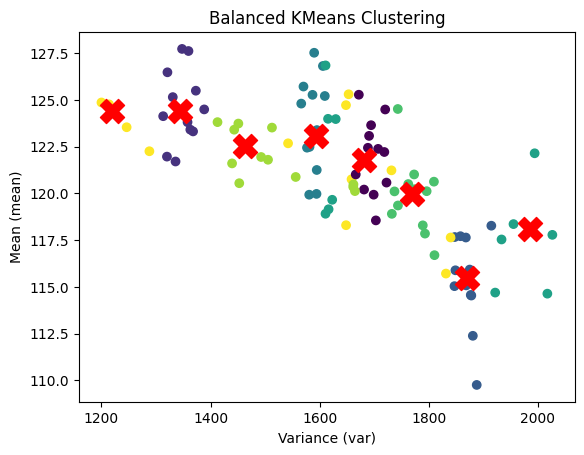

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 5814.46it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.2395 - n2v_mse: 1.2395 - n2v_abs: 0.8706 - val_loss: 0.7907 - val_n2v_mse: 0.7907 - val_n2v_abs: 0.7085
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7977 - n2v_mse: 0.7977 - n2v_abs: 0.7140 - val_loss: 0.7172 - val_n2v_mse: 0.7171 - val_n2v_abs: 0.6755
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7847 - n2v_mse: 0.7847 - n2v_abs: 0.7055 - val_loss: 0.7095 - val_n2v_mse: 0.7094 - val_n2v_abs: 0.6708
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7952 - n2v_mse: 0.7952 - n2v_abs: 0.7121 - val_loss: 0.7044 - val_n2v_mse: 0.7043 - val_n2v_abs: 0.6692
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7938 - n2v_mse: 0.7938 - n2v_abs: 0.7104 - val_loss: 0.7278 - val_n2v_mse: 0.7278 - val_n2v_abs: 0.6832
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7834 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2604.04it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.0681 - n2v_mse: 1.0681 - n2v_abs: 0.8178 - val_loss: 0.8969 - val_n2v_mse: 0.8982 - val_n2v_abs: 0.7591
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8001 - n2v_mse: 0.8001 - n2v_abs: 0.7136 - val_loss: 0.8225 - val_n2v_mse: 0.8233 - val_n2v_abs: 0.7230
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7956 - n2v_mse: 0.7956 - n2v_abs: 0.7117 - val_loss: 0.7589 - val_n2v_mse: 0.7596 - val_n2v_abs: 0.6940
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7821 - n2v_mse: 0.7821 - n2v_abs: 0.7038 - val_loss: 0.7346 - val_n2v_mse: 0.7355 - val_n2v_abs: 0.6816
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7782 - n2v_mse: 0.7782 - n2v_abs: 0.7027 - val_loss: 0.7255 - val_n2v_mse: 0.7265 - val_n2v_abs: 0.6759
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 702.09it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 1.1660 - n2v_mse: 1.1660 - n2v_abs: 0.8541 - val_loss: 0.9240 - val_n2v_mse: 0.9235 - val_n2v_abs: 0.7705
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7921 - n2v_mse: 0.7921 - n2v_abs: 0.7116 - val_loss: 0.8695 - val_n2v_mse: 0.8690 - val_n2v_abs: 0.7491
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7909 - n2v_mse: 0.7909 - n2v_abs: 0.7099 - val_loss: 0.8432 - val_n2v_mse: 0.8426 - val_n2v_abs: 0.7378
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7824 - n2v_mse: 0.7824 - n2v_abs: 0.7049 - val_loss: 0.8037 - val_n2v_mse: 0.8031 - val_n2v_abs: 0.7201
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7801 - n2v_mse: 0.7801 - n2v_abs: 0.7057 - val_loss: 0.7860 - val_n2v_mse: 0.7854 - val_n2v_abs: 0.7110
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7854 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.42it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6895.27it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.7962 - n2v_mse: 0.7962 - n2v_abs: 0.7135 - val_loss: 0.8134 - val_n2v_mse: 0.8134 - val_n2v_abs: 0.7171
Epoch 2/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7909 - n2v_mse: 0.7909 - n2v_abs: 0.7086 - val_loss: 0.8206 - val_n2v_mse: 0.8207 - val_n2v_abs: 0.7216
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7950 - n2v_mse: 0.7950 - n2v_abs: 0.7104 - val_loss: 0.8217 - val_n2v_mse: 0.8217 - val_n2v_abs: 0.7216
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7953 - n2v_mse: 0.7953 - n2v_abs: 0.7118 - val_loss: 0.8150 - val_n2v_mse: 0.8150 - val_n2v_abs: 0.7177
Epoch 5/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7898 - n2v_mse: 0.7898 - n2v_abs: 0.7095 - val_loss: 0.8136 - val_n2v_mse: 0.8137 - val_n2v_abs: 0.7172
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8032 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.38it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6317.63it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7681 - n2v_mse: 0.7681 - n2v_abs: 0.7004 - val_loss: 0.8157 - val_n2v_mse: 0.8158 - val_n2v_abs: 0.7203
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7831 - n2v_mse: 0.7831 - n2v_abs: 0.7073 - val_loss: 0.8028 - val_n2v_mse: 0.8029 - val_n2v_abs: 0.7166
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7640 - n2v_mse: 0.7640 - n2v_abs: 0.6958 - val_loss: 0.7901 - val_n2v_mse: 0.7902 - val_n2v_abs: 0.7100
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7631 - n2v_mse: 0.7631 - n2v_abs: 0.6955 - val_loss: 0.7965 - val_n2v_mse: 0.7966 - val_n2v_abs: 0.7127
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7706 - n2v_mse: 0.7706 - n2v_abs: 0.7008 - val_loss: 0.7959 - val_n2v_mse: 0.7961 - val_n2v_abs: 0.7117
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7724 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6400.80it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.8236 - n2v_mse: 0.8236 - n2v_abs: 0.7236 - val_loss: 0.7982 - val_n2v_mse: 0.7984 - val_n2v_abs: 0.7082
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8238 - n2v_mse: 0.8238 - n2v_abs: 0.7221 - val_loss: 0.8077 - val_n2v_mse: 0.8079 - val_n2v_abs: 0.7122
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8279 - n2v_mse: 0.8279 - n2v_abs: 0.7253 - val_loss: 0.7998 - val_n2v_mse: 0.7999 - val_n2v_abs: 0.7092
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8190 - n2v_mse: 0.8190 - n2v_abs: 0.7221 - val_loss: 0.7953 - val_n2v_mse: 0.7954 - val_n2v_abs: 0.7065
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8251 - n2v_mse: 0.8251 - n2v_abs: 0.7247 - val_loss: 0.7964 - val_n2v_mse: 0.7965 - val_n2v_abs: 0.7076
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.8268 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWCNT_K3_200kV_400kX_5165.tif
0


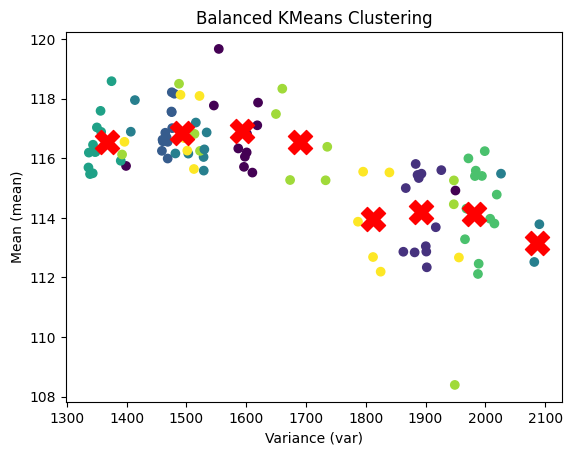

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6506.06it/s]


Epoch 1/100
204/204 [==============================] - 15s 62ms/step - loss: 0.9944 - n2v_mse: 0.9944 - n2v_abs: 0.7879 - val_loss: 0.9043 - val_n2v_mse: 0.9042 - val_n2v_abs: 0.7571
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7936 - n2v_mse: 0.7936 - n2v_abs: 0.7098 - val_loss: 0.8157 - val_n2v_mse: 0.8156 - val_n2v_abs: 0.7190
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7845 - n2v_mse: 0.7845 - n2v_abs: 0.7056 - val_loss: 0.8074 - val_n2v_mse: 0.8073 - val_n2v_abs: 0.7148
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7912 - n2v_mse: 0.7912 - n2v_abs: 0.7068 - val_loss: 0.8084 - val_n2v_mse: 0.8083 - val_n2v_abs: 0.7167
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7788 - n2v_mse: 0.7788 - n2v_abs: 0.7037 - val_loss: 0.8129 - val_n2v_mse: 0.8128 - val_n2v_abs: 0.7177
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7815 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2538.06it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.0230 - n2v_mse: 1.0230 - n2v_abs: 0.8001 - val_loss: 0.9566 - val_n2v_mse: 0.9559 - val_n2v_abs: 0.7782
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8011 - n2v_mse: 0.8011 - n2v_abs: 0.7150 - val_loss: 0.9130 - val_n2v_mse: 0.9129 - val_n2v_abs: 0.7588
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7974 - n2v_mse: 0.7974 - n2v_abs: 0.7127 - val_loss: 0.8421 - val_n2v_mse: 0.8416 - val_n2v_abs: 0.7301
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7927 - n2v_mse: 0.7927 - n2v_abs: 0.7095 - val_loss: 0.8276 - val_n2v_mse: 0.8270 - val_n2v_abs: 0.7225
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7824 - n2v_mse: 0.7824 - n2v_abs: 0.7063 - val_loss: 0.8209 - val_n2v_mse: 0.8196 - val_n2v_abs: 0.7197
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.33it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 701.64it/s]


Epoch 1/100
51/51 [==============================] - 13s 211ms/step - loss: 1.0397 - n2v_mse: 1.0397 - n2v_abs: 0.8076 - val_loss: 0.9451 - val_n2v_mse: 0.9441 - val_n2v_abs: 0.7742
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7903 - n2v_mse: 0.7903 - n2v_abs: 0.7084 - val_loss: 0.9080 - val_n2v_mse: 0.9071 - val_n2v_abs: 0.7582
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7939 - n2v_mse: 0.7939 - n2v_abs: 0.7102 - val_loss: 0.8604 - val_n2v_mse: 0.8598 - val_n2v_abs: 0.7369
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7811 - n2v_mse: 0.7811 - n2v_abs: 0.7021 - val_loss: 0.8391 - val_n2v_mse: 0.8386 - val_n2v_abs: 0.7287
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7788 - n2v_mse: 0.7788 - n2v_abs: 0.7020 - val_loss: 0.8293 - val_n2v_mse: 0.8289 - val_n2v_abs: 0.7250
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7771 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.39it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2651.27it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.8337 - n2v_mse: 0.8337 - n2v_abs: 0.7281 - val_loss: 0.9020 - val_n2v_mse: 0.8980 - val_n2v_abs: 0.7514
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8198 - n2v_mse: 0.8198 - n2v_abs: 0.7206 - val_loss: 0.8306 - val_n2v_mse: 0.8265 - val_n2v_abs: 0.7263
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8230 - n2v_mse: 0.8230 - n2v_abs: 0.7248 - val_loss: 0.8404 - val_n2v_mse: 0.8366 - val_n2v_abs: 0.7291
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8198 - n2v_mse: 0.8198 - n2v_abs: 0.7238 - val_loss: 0.8314 - val_n2v_mse: 0.8277 - val_n2v_abs: 0.7268
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8279 - n2v_mse: 0.8279 - n2v_abs: 0.7244 - val_loss: 0.9268 - val_n2v_mse: 0.9228 - val_n2v_abs: 0.7663
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8244 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2536.31it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.8439 - n2v_mse: 0.8439 - n2v_abs: 0.7328 - val_loss: 0.7777 - val_n2v_mse: 0.7761 - val_n2v_abs: 0.7014
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8589 - n2v_mse: 0.8589 - n2v_abs: 0.7366 - val_loss: 0.7746 - val_n2v_mse: 0.7731 - val_n2v_abs: 0.6987
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8554 - n2v_mse: 0.8554 - n2v_abs: 0.7386 - val_loss: 0.7805 - val_n2v_mse: 0.7786 - val_n2v_abs: 0.7014
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8567 - n2v_mse: 0.8567 - n2v_abs: 0.7394 - val_loss: 0.7738 - val_n2v_mse: 0.7731 - val_n2v_abs: 0.6995
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8520 - n2v_mse: 0.8520 - n2v_abs: 0.7359 - val_loss: 0.7779 - val_n2v_mse: 0.7763 - val_n2v_abs: 0.7004
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8548 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.08it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2522.25it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.8829 - n2v_mse: 0.8829 - n2v_abs: 0.7481 - val_loss: 0.9382 - val_n2v_mse: 0.9388 - val_n2v_abs: 0.7713
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.9055 - n2v_mse: 0.9055 - n2v_abs: 0.7587 - val_loss: 0.9274 - val_n2v_mse: 0.9283 - val_n2v_abs: 0.7666
Epoch 3/20
102/102 [==============================] - 11s 105ms/step - loss: 0.8903 - n2v_mse: 0.8903 - n2v_abs: 0.7525 - val_loss: 0.9433 - val_n2v_mse: 0.9440 - val_n2v_abs: 0.7723
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.9002 - n2v_mse: 0.9002 - n2v_abs: 0.7595 - val_loss: 0.9426 - val_n2v_mse: 0.9433 - val_n2v_abs: 0.7743
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8957 - n2v_mse: 0.8957 - n2v_abs: 0.7531 - val_loss: 0.9358 - val_n2v_mse: 0.9364 - val_n2v_abs: 0.7707
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8861 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.01it/s]


/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWNT_K3_200kV_400kX_4653.tif
0
Generated patches: (11160, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 2232/2232 [00:00<00:00, 7000.55it/s]


Epoch 1/100
69/69 [==============================] - 7s 69ms/step - loss: 0.9388 - n2v_mse: 0.9388 - n2v_abs: 0.7577 - val_loss: 0.8770 - val_n2v_mse: 0.8774 - val_n2v_abs: 0.7381
Epoch 2/100
69/69 [==============================] - 4s 61ms/step - loss: 0.5868 - n2v_mse: 0.5868 - n2v_abs: 0.6128 - val_loss: 0.8217 - val_n2v_mse: 0.8218 - val_n2v_abs: 0.7182
Epoch 3/100
69/69 [==============================] - 4s 61ms/step - loss: 0.5597 - n2v_mse: 0.5597 - n2v_abs: 0.5960 - val_loss: 0.7579 - val_n2v_mse: 0.7579 - val_n2v_abs: 0.6886
Epoch 4/100
69/69 [==============================] - 4s 61ms/step - loss: 0.5585 - n2v_mse: 0.5585 - n2v_abs: 0.5940 - val_loss: 0.6487 - val_n2v_mse: 0.6486 - val_n2v_abs: 0.6384
Epoch 5/100
69/69 [==============================] - 4s 61ms/step - loss: 0.5316 - n2v_mse: 0.5316 - n2v_abs: 0.5805 - val_loss: 0.5981 - val_n2v_mse: 0.5980 - val_n2v_abs: 0.6169
Epoch 6/100
69/69 [==============================] - 4s 61ms/step - loss: 0.5379 - n2v_mse: 0.5379 -

100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 20.56it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (2640, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|████████████| 528/528 [00:00<00:00, 2773.42it/s]


Epoch 1/100
33/33 [==============================] - 6s 126ms/step - loss: 0.9997 - n2v_mse: 0.9997 - n2v_abs: 0.7831 - val_loss: 0.8864 - val_n2v_mse: 0.8818 - val_n2v_abs: 0.7464
Epoch 2/100
33/33 [==============================] - 3s 105ms/step - loss: 0.5758 - n2v_mse: 0.5758 - n2v_abs: 0.6021 - val_loss: 0.8747 - val_n2v_mse: 0.8703 - val_n2v_abs: 0.7424
Epoch 3/100
33/33 [==============================] - 3s 106ms/step - loss: 0.5548 - n2v_mse: 0.5548 - n2v_abs: 0.5911 - val_loss: 0.8502 - val_n2v_mse: 0.8464 - val_n2v_abs: 0.7322
Epoch 4/100
33/33 [==============================] - 3s 106ms/step - loss: 0.5492 - n2v_mse: 0.5492 - n2v_abs: 0.5916 - val_loss: 0.8557 - val_n2v_mse: 0.8519 - val_n2v_abs: 0.7371
Epoch 5/100
33/33 [==============================] - 3s 106ms/step - loss: 0.5391 - n2v_mse: 0.5391 - n2v_abs: 0.5838 - val_loss: 0.8602 - val_n2v_mse: 0.8563 - val_n2v_abs: 0.7374
Epoch 6/100
33/33 [==============================] - 3s 105ms/step - loss: 0.5407 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 19.83it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (616, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 124/124 [00:00<00:00, 700.93it/s]


Epoch 1/100
15/15 [==============================] - 6s 292ms/step - loss: 1.2541 - n2v_mse: 1.2541 - n2v_abs: 0.8674 - val_loss: 0.9328 - val_n2v_mse: 0.9347 - val_n2v_abs: 0.7614
Epoch 2/100
15/15 [==============================] - 3s 207ms/step - loss: 0.6605 - n2v_mse: 0.6605 - n2v_abs: 0.6477 - val_loss: 0.8783 - val_n2v_mse: 0.8799 - val_n2v_abs: 0.7411
Epoch 3/100
15/15 [==============================] - 3s 207ms/step - loss: 0.6040 - n2v_mse: 0.6040 - n2v_abs: 0.6206 - val_loss: 0.8583 - val_n2v_mse: 0.8596 - val_n2v_abs: 0.7329
Epoch 4/100
15/15 [==============================] - 3s 207ms/step - loss: 0.5862 - n2v_mse: 0.5862 - n2v_abs: 0.6086 - val_loss: 0.8518 - val_n2v_mse: 0.8531 - val_n2v_abs: 0.7310
Epoch 5/100
15/15 [==============================] - 3s 207ms/step - loss: 0.5791 - n2v_mse: 0.5791 - n2v_abs: 0.6080 - val_loss: 0.8398 - val_n2v_mse: 0.8410 - val_n2v_abs: 0.7271
Epoch 6/100
15/15 [==============================] - 3s 207ms/step - loss: 0.5685 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 20.10it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(
100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 19.09it/s]


/root/data/HRTEM of Ar-at-C60/ICZ-070 Ar@C60@SWNT_K3_200kV_400kX_4662.tif
0


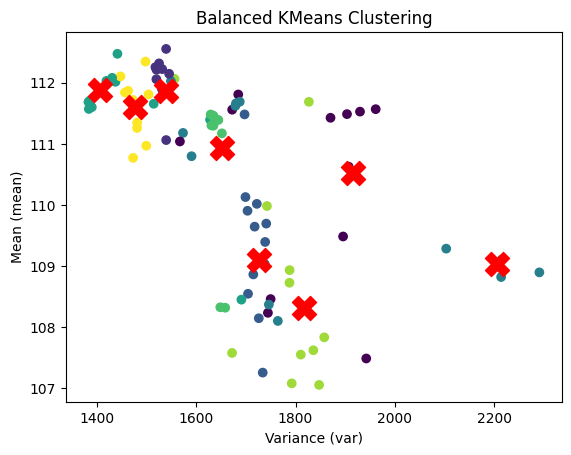

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 5778.80it/s]


Epoch 1/100
204/204 [==============================] - 15s 62ms/step - loss: 1.1287 - n2v_mse: 1.1287 - n2v_abs: 0.8390 - val_loss: 0.8127 - val_n2v_mse: 0.8126 - val_n2v_abs: 0.7139
Epoch 2/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8670 - n2v_mse: 0.8670 - n2v_abs: 0.7391 - val_loss: 0.7764 - val_n2v_mse: 0.7763 - val_n2v_abs: 0.6995
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8311 - n2v_mse: 0.8311 - n2v_abs: 0.7236 - val_loss: 0.7733 - val_n2v_mse: 0.7732 - val_n2v_abs: 0.7010
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8530 - n2v_mse: 0.8530 - n2v_abs: 0.7331 - val_loss: 0.7719 - val_n2v_mse: 0.7719 - val_n2v_abs: 0.6999
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8357 - n2v_mse: 0.8357 - n2v_abs: 0.7275 - val_loss: 0.7650 - val_n2v_mse: 0.7650 - val_n2v_abs: 0.6962
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8359 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2514.25it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.1077 - n2v_mse: 1.1077 - n2v_abs: 0.8321 - val_loss: 0.8859 - val_n2v_mse: 0.8827 - val_n2v_abs: 0.7448
Epoch 2/100
102/102 [==============================] - 11s 105ms/step - loss: 0.8493 - n2v_mse: 0.8493 - n2v_abs: 0.7332 - val_loss: 0.8200 - val_n2v_mse: 0.8171 - val_n2v_abs: 0.7183
Epoch 3/100
102/102 [==============================] - 11s 105ms/step - loss: 0.8645 - n2v_mse: 0.8645 - n2v_abs: 0.7410 - val_loss: 0.7972 - val_n2v_mse: 0.7944 - val_n2v_abs: 0.7090
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8386 - n2v_mse: 0.8386 - n2v_abs: 0.7272 - val_loss: 0.7885 - val_n2v_mse: 0.7861 - val_n2v_abs: 0.7070
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8314 - n2v_mse: 0.8314 - n2v_abs: 0.7240 - val_loss: 0.7835 - val_n2v_mse: 0.7820 - val_n2v_abs: 0.7084
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.21it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 710.87it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1397 - n2v_mse: 1.1397 - n2v_abs: 0.8414 - val_loss: 0.8716 - val_n2v_mse: 0.8707 - val_n2v_abs: 0.7465
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8463 - n2v_mse: 0.8463 - n2v_abs: 0.7312 - val_loss: 0.8481 - val_n2v_mse: 0.8473 - val_n2v_abs: 0.7340
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8283 - n2v_mse: 0.8283 - n2v_abs: 0.7230 - val_loss: 0.8271 - val_n2v_mse: 0.8264 - val_n2v_abs: 0.7243
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8564 - n2v_mse: 0.8564 - n2v_abs: 0.7341 - val_loss: 0.8070 - val_n2v_mse: 0.8064 - val_n2v_abs: 0.7153
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8398 - n2v_mse: 0.8398 - n2v_abs: 0.7284 - val_loss: 0.7979 - val_n2v_mse: 0.7973 - val_n2v_abs: 0.7113
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8295 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6606.45it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.8381 - n2v_mse: 0.8381 - n2v_abs: 0.7277 - val_loss: 0.8572 - val_n2v_mse: 0.8571 - val_n2v_abs: 0.7348
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8347 - n2v_mse: 0.8347 - n2v_abs: 0.7229 - val_loss: 0.8578 - val_n2v_mse: 0.8577 - val_n2v_abs: 0.7364
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8337 - n2v_mse: 0.8337 - n2v_abs: 0.7235 - val_loss: 0.8678 - val_n2v_mse: 0.8677 - val_n2v_abs: 0.7393
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8255 - n2v_mse: 0.8255 - n2v_abs: 0.7218 - val_loss: 0.8615 - val_n2v_mse: 0.8614 - val_n2v_abs: 0.7374
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8459 - n2v_mse: 0.8459 - n2v_abs: 0.7295 - val_loss: 0.8571 - val_n2v_mse: 0.8570 - val_n2v_abs: 0.7341
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8464 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6562.94it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.8250 - n2v_mse: 0.8250 - n2v_abs: 0.7223 - val_loss: 0.8115 - val_n2v_mse: 0.8113 - val_n2v_abs: 0.7162
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8229 - n2v_mse: 0.8229 - n2v_abs: 0.7216 - val_loss: 0.8112 - val_n2v_mse: 0.8110 - val_n2v_abs: 0.7160
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.8327 - n2v_mse: 0.8327 - n2v_abs: 0.7241 - val_loss: 0.8134 - val_n2v_mse: 0.8132 - val_n2v_abs: 0.7169
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8219 - n2v_mse: 0.8219 - n2v_abs: 0.7229 - val_loss: 0.8182 - val_n2v_mse: 0.8179 - val_n2v_abs: 0.7189
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8130 - n2v_mse: 0.8130 - n2v_abs: 0.7168 - val_loss: 0.8163 - val_n2v_mse: 0.8161 - val_n2v_abs: 0.7201
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8281 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6469.47it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.8442 - n2v_mse: 0.8442 - n2v_abs: 0.7305 - val_loss: 0.8099 - val_n2v_mse: 0.8100 - val_n2v_abs: 0.7146
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8546 - n2v_mse: 0.8546 - n2v_abs: 0.7352 - val_loss: 0.8094 - val_n2v_mse: 0.8094 - val_n2v_abs: 0.7131
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8614 - n2v_mse: 0.8614 - n2v_abs: 0.7372 - val_loss: 0.8093 - val_n2v_mse: 0.8093 - val_n2v_abs: 0.7129
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8415 - n2v_mse: 0.8415 - n2v_abs: 0.7272 - val_loss: 0.8075 - val_n2v_mse: 0.8076 - val_n2v_abs: 0.7142
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.8540 - n2v_mse: 0.8540 - n2v_abs: 0.7345 - val_loss: 0.8139 - val_n2v_mse: 0.8139 - val_n2v_abs: 0.7171
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8625 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.31it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.09it/s]


/root/data/HRTEM of COF lattice/1 Co-tAPP-BDA-COF ipa_50kX_K3_200kV_22689.tif
0


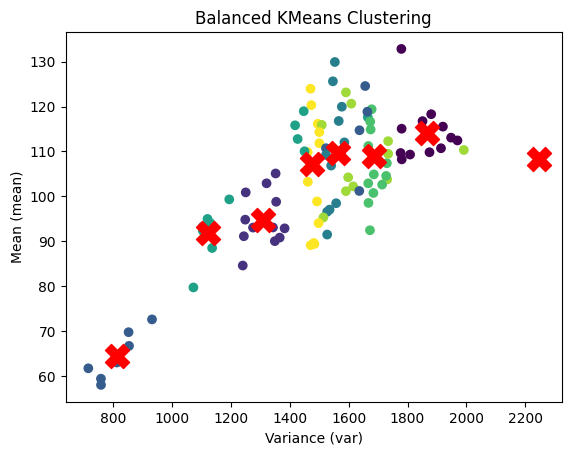

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6415.27it/s]


Epoch 1/100
204/204 [==============================] - 15s 62ms/step - loss: 0.9148 - n2v_mse: 0.9148 - n2v_abs: 0.7477 - val_loss: 0.7600 - val_n2v_mse: 0.7599 - val_n2v_abs: 0.6909
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6380 - n2v_mse: 0.6380 - n2v_abs: 0.6274 - val_loss: 0.7190 - val_n2v_mse: 0.7189 - val_n2v_abs: 0.6706
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6326 - n2v_mse: 0.6326 - n2v_abs: 0.6267 - val_loss: 0.7132 - val_n2v_mse: 0.7130 - val_n2v_abs: 0.6671
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6322 - n2v_mse: 0.6322 - n2v_abs: 0.6257 - val_loss: 0.7150 - val_n2v_mse: 0.7148 - val_n2v_abs: 0.6676
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6341 - n2v_mse: 0.6341 - n2v_abs: 0.6266 - val_loss: 0.7065 - val_n2v_mse: 0.7063 - val_n2v_abs: 0.6642
Epoch 6/100
204/204 [==============================] - 12s 61ms/step - loss: 0.6187 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2528.05it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 0.8813 - n2v_mse: 0.8813 - n2v_abs: 0.7383 - val_loss: 0.8290 - val_n2v_mse: 0.8235 - val_n2v_abs: 0.7235
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6336 - n2v_mse: 0.6336 - n2v_abs: 0.6270 - val_loss: 0.7451 - val_n2v_mse: 0.7405 - val_n2v_abs: 0.6840
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6252 - n2v_mse: 0.6252 - n2v_abs: 0.6235 - val_loss: 0.7210 - val_n2v_mse: 0.7167 - val_n2v_abs: 0.6685
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6261 - n2v_mse: 0.6261 - n2v_abs: 0.6228 - val_loss: 0.7170 - val_n2v_mse: 0.7126 - val_n2v_abs: 0.6676
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6225 - n2v_mse: 0.6225 - n2v_abs: 0.6195 - val_loss: 0.7084 - val_n2v_mse: 0.7044 - val_n2v_abs: 0.6632
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 783.57it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 1.6012 - n2v_mse: 1.6012 - n2v_abs: 0.9940 - val_loss: 0.9065 - val_n2v_mse: 0.9054 - val_n2v_abs: 0.7597
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6412 - n2v_mse: 0.6412 - n2v_abs: 0.6319 - val_loss: 0.8605 - val_n2v_mse: 0.8591 - val_n2v_abs: 0.7395
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6294 - n2v_mse: 0.6294 - n2v_abs: 0.6244 - val_loss: 0.8117 - val_n2v_mse: 0.8101 - val_n2v_abs: 0.7180
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6308 - n2v_mse: 0.6308 - n2v_abs: 0.6247 - val_loss: 0.7801 - val_n2v_mse: 0.7787 - val_n2v_abs: 0.7020
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6172 - n2v_mse: 0.6172 - n2v_abs: 0.6194 - val_loss: 0.7413 - val_n2v_mse: 0.7393 - val_n2v_abs: 0.6842
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6267 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 735.64it/s]


Epoch 1/50
51/51 [==============================] - 13s 212ms/step - loss: 0.6713 - n2v_mse: 0.6713 - n2v_abs: 0.6452 - val_loss: 1.1904 - val_n2v_mse: 1.1883 - val_n2v_abs: 0.8643
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 0.6773 - n2v_mse: 0.6773 - n2v_abs: 0.6492 - val_loss: 1.1574 - val_n2v_mse: 1.1510 - val_n2v_abs: 0.8203
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 0.6692 - n2v_mse: 0.6692 - n2v_abs: 0.6463 - val_loss: 0.8501 - val_n2v_mse: 0.8466 - val_n2v_abs: 0.7306
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 0.6825 - n2v_mse: 0.6825 - n2v_abs: 0.6518 - val_loss: 0.8178 - val_n2v_mse: 0.8154 - val_n2v_abs: 0.7124
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 0.6578 - n2v_mse: 0.6578 - n2v_abs: 0.6404 - val_loss: 0.6557 - val_n2v_mse: 0.6534 - val_n2v_abs: 0.6357
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.6611 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.10it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 733.65it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.6358 - n2v_mse: 0.6358 - n2v_abs: 0.6268 - val_loss: 0.6287 - val_n2v_mse: 0.6299 - val_n2v_abs: 0.6241
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.6289 - n2v_mse: 0.6289 - n2v_abs: 0.6213 - val_loss: 0.6383 - val_n2v_mse: 0.6396 - val_n2v_abs: 0.6306
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.6296 - n2v_mse: 0.6296 - n2v_abs: 0.6221 - val_loss: 0.6593 - val_n2v_mse: 0.6603 - val_n2v_abs: 0.6412
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.6296 - n2v_mse: 0.6296 - n2v_abs: 0.6236 - val_loss: 0.6326 - val_n2v_mse: 0.6339 - val_n2v_abs: 0.6241
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.6149 - n2v_mse: 0.6149 - n2v_abs: 0.6152 - val_loss: 0.6332 - val_n2v_mse: 0.6341 - val_n2v_abs: 0.6255
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.6258 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.16it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 754.44it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.5156 - n2v_mse: 0.5156 - n2v_abs: 0.5628 - val_loss: 0.5869 - val_n2v_mse: 0.5856 - val_n2v_abs: 0.6037
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5102 - n2v_mse: 0.5102 - n2v_abs: 0.5588 - val_loss: 0.5753 - val_n2v_mse: 0.5741 - val_n2v_abs: 0.6014
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5104 - n2v_mse: 0.5104 - n2v_abs: 0.5599 - val_loss: 0.5878 - val_n2v_mse: 0.5864 - val_n2v_abs: 0.6053
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5176 - n2v_mse: 0.5176 - n2v_abs: 0.5638 - val_loss: 0.5994 - val_n2v_mse: 0.5982 - val_n2v_abs: 0.6099
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5130 - n2v_mse: 0.5130 - n2v_abs: 0.5610 - val_loss: 0.5709 - val_n2v_mse: 0.5697 - val_n2v_abs: 0.5976
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5113 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 768.56it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.5659 - n2v_mse: 0.5659 - n2v_abs: 0.5897 - val_loss: 0.5860 - val_n2v_mse: 0.5831 - val_n2v_abs: 0.6022
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5658 - n2v_mse: 0.5658 - n2v_abs: 0.5889 - val_loss: 0.5842 - val_n2v_mse: 0.5810 - val_n2v_abs: 0.6003
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5641 - n2v_mse: 0.5641 - n2v_abs: 0.5880 - val_loss: 0.6002 - val_n2v_mse: 0.5966 - val_n2v_abs: 0.6055
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5741 - n2v_mse: 0.5741 - n2v_abs: 0.5925 - val_loss: 0.5845 - val_n2v_mse: 0.5811 - val_n2v_abs: 0.5977
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5549 - n2v_mse: 0.5549 - n2v_abs: 0.5828 - val_loss: 0.5735 - val_n2v_mse: 0.5705 - val_n2v_abs: 0.5939
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.5662 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 768.62it/s]


Epoch 1/20
51/51 [==============================] - 13s 211ms/step - loss: 0.5183 - n2v_mse: 0.5183 - n2v_abs: 0.5603 - val_loss: 0.6762 - val_n2v_mse: 0.6732 - val_n2v_abs: 0.6373
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5170 - n2v_mse: 0.5170 - n2v_abs: 0.5598 - val_loss: 0.7809 - val_n2v_mse: 0.7865 - val_n2v_abs: 0.6944
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5140 - n2v_mse: 0.5140 - n2v_abs: 0.5593 - val_loss: 0.5366 - val_n2v_mse: 0.5353 - val_n2v_abs: 0.5750
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5131 - n2v_mse: 0.5131 - n2v_abs: 0.5586 - val_loss: 0.5466 - val_n2v_mse: 0.5452 - val_n2v_abs: 0.5808
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.4991 - n2v_mse: 0.4991 - n2v_abs: 0.5486 - val_loss: 0.5610 - val_n2v_mse: 0.5590 - val_n2v_abs: 0.5786
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.5159 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.05it/s]


/root/data/HRTEM of COF lattice/1 Co-tAPP-BDA-COF ipa_10kX_K3_200kV_22692.tif
0


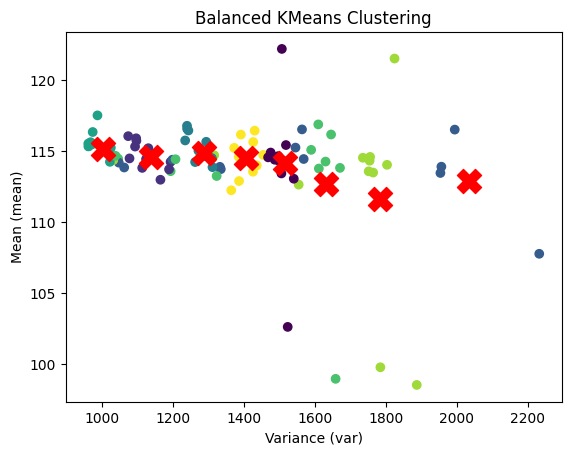

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6824.58it/s]


Epoch 1/100
204/204 [==============================] - 14s 62ms/step - loss: 0.9983 - n2v_mse: 0.9983 - n2v_abs: 0.7790 - val_loss: 0.8895 - val_n2v_mse: 0.8894 - val_n2v_abs: 0.7456
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7595 - n2v_mse: 0.7595 - n2v_abs: 0.6907 - val_loss: 0.7997 - val_n2v_mse: 0.7996 - val_n2v_abs: 0.7100
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7425 - n2v_mse: 0.7425 - n2v_abs: 0.6816 - val_loss: 0.7858 - val_n2v_mse: 0.7857 - val_n2v_abs: 0.7033
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7360 - n2v_mse: 0.7360 - n2v_abs: 0.6803 - val_loss: 0.8759 - val_n2v_mse: 0.8758 - val_n2v_abs: 0.7323
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7386 - n2v_mse: 0.7386 - n2v_abs: 0.6804 - val_loss: 0.8516 - val_n2v_mse: 0.8514 - val_n2v_abs: 0.7264
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7325 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.31it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2574.69it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 0.9632 - n2v_mse: 0.9632 - n2v_abs: 0.7700 - val_loss: 0.9392 - val_n2v_mse: 0.9363 - val_n2v_abs: 0.7635
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7435 - n2v_mse: 0.7435 - n2v_abs: 0.6838 - val_loss: 0.8470 - val_n2v_mse: 0.8448 - val_n2v_abs: 0.7279
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7399 - n2v_mse: 0.7399 - n2v_abs: 0.6795 - val_loss: 0.8142 - val_n2v_mse: 0.8122 - val_n2v_abs: 0.7144
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7551 - n2v_mse: 0.7551 - n2v_abs: 0.6889 - val_loss: 0.7973 - val_n2v_mse: 0.7957 - val_n2v_abs: 0.7067
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7392 - n2v_mse: 0.7392 - n2v_abs: 0.6801 - val_loss: 0.7957 - val_n2v_mse: 0.7946 - val_n2v_abs: 0.7062
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 726.07it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.0995 - n2v_mse: 1.0995 - n2v_abs: 0.8218 - val_loss: 0.9994 - val_n2v_mse: 0.9963 - val_n2v_abs: 0.7862
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7603 - n2v_mse: 0.7603 - n2v_abs: 0.6893 - val_loss: 0.9573 - val_n2v_mse: 0.9543 - val_n2v_abs: 0.7698
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7548 - n2v_mse: 0.7548 - n2v_abs: 0.6896 - val_loss: 0.9159 - val_n2v_mse: 0.9130 - val_n2v_abs: 0.7541
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7362 - n2v_mse: 0.7362 - n2v_abs: 0.6804 - val_loss: 0.8664 - val_n2v_mse: 0.8639 - val_n2v_abs: 0.7349
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7316 - n2v_mse: 0.7316 - n2v_abs: 0.6783 - val_loss: 0.8491 - val_n2v_mse: 0.8467 - val_n2v_abs: 0.7290
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7366 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6331.88it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.8073 - n2v_mse: 0.8073 - n2v_abs: 0.7077 - val_loss: 0.9458 - val_n2v_mse: 0.9460 - val_n2v_abs: 0.7725
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8107 - n2v_mse: 0.8107 - n2v_abs: 0.7105 - val_loss: 1.2063 - val_n2v_mse: 1.2069 - val_n2v_abs: 0.8607
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8033 - n2v_mse: 0.8033 - n2v_abs: 0.7081 - val_loss: 0.9241 - val_n2v_mse: 0.9242 - val_n2v_abs: 0.7635
Epoch 4/50
204/204 [==============================] - 12s 61ms/step - loss: 0.8039 - n2v_mse: 0.8039 - n2v_abs: 0.7036 - val_loss: 0.9036 - val_n2v_mse: 0.9036 - val_n2v_abs: 0.7549
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8020 - n2v_mse: 0.8020 - n2v_abs: 0.7045 - val_loss: 0.8979 - val_n2v_mse: 0.8980 - val_n2v_abs: 0.7524
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8070 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6460.66it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7587 - n2v_mse: 0.7587 - n2v_abs: 0.6871 - val_loss: 1.1128 - val_n2v_mse: 1.1123 - val_n2v_abs: 0.7984
Epoch 2/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7637 - n2v_mse: 0.7637 - n2v_abs: 0.6897 - val_loss: 0.8789 - val_n2v_mse: 0.8786 - val_n2v_abs: 0.7309
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7467 - n2v_mse: 0.7467 - n2v_abs: 0.6832 - val_loss: 0.8908 - val_n2v_mse: 0.8905 - val_n2v_abs: 0.7345
Epoch 4/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7552 - n2v_mse: 0.7552 - n2v_abs: 0.6857 - val_loss: 1.0161 - val_n2v_mse: 1.0157 - val_n2v_abs: 0.7747
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7493 - n2v_mse: 0.7493 - n2v_abs: 0.6840 - val_loss: 0.8492 - val_n2v_mse: 0.8489 - val_n2v_abs: 0.7206
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7545 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6452.80it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7793 - n2v_mse: 0.7793 - n2v_abs: 0.6984 - val_loss: 0.7984 - val_n2v_mse: 0.7984 - val_n2v_abs: 0.7067
Epoch 2/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7748 - n2v_mse: 0.7748 - n2v_abs: 0.6928 - val_loss: 0.8019 - val_n2v_mse: 0.8019 - val_n2v_abs: 0.7083
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7931 - n2v_mse: 0.7931 - n2v_abs: 0.7025 - val_loss: 0.7918 - val_n2v_mse: 0.7918 - val_n2v_abs: 0.7030
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7843 - n2v_mse: 0.7843 - n2v_abs: 0.6984 - val_loss: 0.8043 - val_n2v_mse: 0.8043 - val_n2v_abs: 0.7082
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7777 - n2v_mse: 0.7777 - n2v_abs: 0.6978 - val_loss: 0.8525 - val_n2v_mse: 0.8526 - val_n2v_abs: 0.7255
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7914 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


/root/data/HRTEM of COF lattice/1 co-tapp-bda-cof-mwcnt_10kX_K3_200kV_22436.tif
0


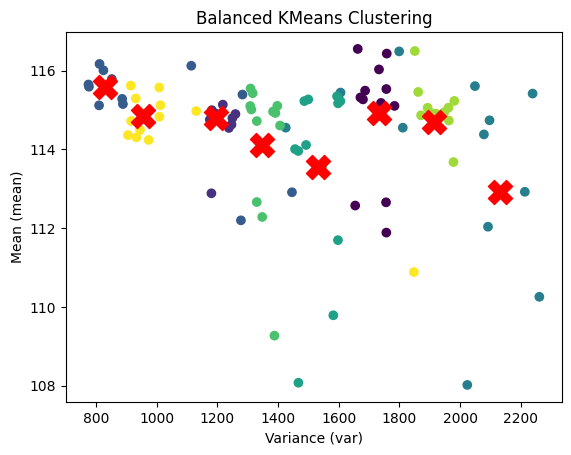

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 5597.02it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.0729 - n2v_mse: 1.0729 - n2v_abs: 0.8128 - val_loss: 0.8272 - val_n2v_mse: 0.8270 - val_n2v_abs: 0.7249
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8584 - n2v_mse: 0.8584 - n2v_abs: 0.7326 - val_loss: 0.8055 - val_n2v_mse: 0.8053 - val_n2v_abs: 0.7104
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8578 - n2v_mse: 0.8578 - n2v_abs: 0.7339 - val_loss: 0.8079 - val_n2v_mse: 0.8077 - val_n2v_abs: 0.7119
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8700 - n2v_mse: 0.8700 - n2v_abs: 0.7391 - val_loss: 0.7974 - val_n2v_mse: 0.7972 - val_n2v_abs: 0.7063
Epoch 5/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8626 - n2v_mse: 0.8626 - n2v_abs: 0.7332 - val_loss: 0.7927 - val_n2v_mse: 0.7925 - val_n2v_abs: 0.7033
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8557 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2720.33it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.1750 - n2v_mse: 1.1750 - n2v_abs: 0.8547 - val_loss: 0.8630 - val_n2v_mse: 0.8570 - val_n2v_abs: 0.7364
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8812 - n2v_mse: 0.8812 - n2v_abs: 0.7438 - val_loss: 0.8418 - val_n2v_mse: 0.8356 - val_n2v_abs: 0.7268
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8647 - n2v_mse: 0.8647 - n2v_abs: 0.7394 - val_loss: 0.8307 - val_n2v_mse: 0.8244 - val_n2v_abs: 0.7193
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8523 - n2v_mse: 0.8523 - n2v_abs: 0.7304 - val_loss: 0.8233 - val_n2v_mse: 0.8175 - val_n2v_abs: 0.7140
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8512 - n2v_mse: 0.8512 - n2v_abs: 0.7293 - val_loss: 0.8200 - val_n2v_mse: 0.8140 - val_n2v_abs: 0.7123
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.18it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 780.10it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1727 - n2v_mse: 1.1727 - n2v_abs: 0.8502 - val_loss: 0.8613 - val_n2v_mse: 0.8584 - val_n2v_abs: 0.7336
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8654 - n2v_mse: 0.8654 - n2v_abs: 0.7369 - val_loss: 0.8472 - val_n2v_mse: 0.8443 - val_n2v_abs: 0.7260
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8687 - n2v_mse: 0.8687 - n2v_abs: 0.7392 - val_loss: 0.8301 - val_n2v_mse: 0.8270 - val_n2v_abs: 0.7199
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8679 - n2v_mse: 0.8679 - n2v_abs: 0.7371 - val_loss: 0.8285 - val_n2v_mse: 0.8254 - val_n2v_abs: 0.7205
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8409 - n2v_mse: 0.8409 - n2v_abs: 0.7265 - val_loss: 0.8215 - val_n2v_mse: 0.8183 - val_n2v_abs: 0.7172
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8564 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.16it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 727.39it/s]


Epoch 1/50
51/51 [==============================] - 13s 212ms/step - loss: 0.7867 - n2v_mse: 0.7867 - n2v_abs: 0.6925 - val_loss: 1.0589 - val_n2v_mse: 1.0509 - val_n2v_abs: 0.7765
Epoch 2/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7729 - n2v_mse: 0.7729 - n2v_abs: 0.6873 - val_loss: 5.4247 - val_n2v_mse: 5.3548 - val_n2v_abs: 1.6361
Epoch 3/50
51/51 [==============================] - 10s 203ms/step - loss: 0.7794 - n2v_mse: 0.7794 - n2v_abs: 0.6885 - val_loss: 0.9894 - val_n2v_mse: 0.9821 - val_n2v_abs: 0.7303
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 0.7721 - n2v_mse: 0.7721 - n2v_abs: 0.6875 - val_loss: 0.7733 - val_n2v_mse: 0.7683 - val_n2v_abs: 0.6814
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7641 - n2v_mse: 0.7641 - n2v_abs: 0.6824 - val_loss: 29.0770 - val_n2v_mse: 28.6649 - val_n2v_abs: 3.2543
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7753 - n2v_mse: 

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.18it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 705.42it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7887 - n2v_mse: 0.7887 - n2v_abs: 0.6944 - val_loss: 0.7084 - val_n2v_mse: 0.7049 - val_n2v_abs: 0.6438
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7531 - n2v_mse: 0.7531 - n2v_abs: 0.6767 - val_loss: 0.7826 - val_n2v_mse: 0.7780 - val_n2v_abs: 0.6723
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7922 - n2v_mse: 0.7922 - n2v_abs: 0.6936 - val_loss: 0.7651 - val_n2v_mse: 0.7602 - val_n2v_abs: 0.6595
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7835 - n2v_mse: 0.7835 - n2v_abs: 0.6879 - val_loss: 0.6979 - val_n2v_mse: 0.6940 - val_n2v_abs: 0.6367
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7543 - n2v_mse: 0.7543 - n2v_abs: 0.6770 - val_loss: 0.7137 - val_n2v_mse: 0.7101 - val_n2v_abs: 0.6420
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7727 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 766.53it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8089 - n2v_mse: 0.8089 - n2v_abs: 0.7015 - val_loss: 1.4809 - val_n2v_mse: 1.4645 - val_n2v_abs: 0.8631
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7942 - n2v_mse: 0.7942 - n2v_abs: 0.6948 - val_loss: 0.7071 - val_n2v_mse: 0.7017 - val_n2v_abs: 0.6418
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8240 - n2v_mse: 0.8240 - n2v_abs: 0.7055 - val_loss: 0.7108 - val_n2v_mse: 0.7056 - val_n2v_abs: 0.6457
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8107 - n2v_mse: 0.8107 - n2v_abs: 0.7022 - val_loss: 0.7072 - val_n2v_mse: 0.7019 - val_n2v_abs: 0.6425
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7850 - n2v_mse: 0.7850 - n2v_abs: 0.6909 - val_loss: 1.1502 - val_n2v_mse: 1.1384 - val_n2v_abs: 0.7791
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8208 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


/root/data/HRTEM of COF lattice/1 Co-tAPP-BDA-COF ipa_10kX_K3_200kV_22678.tif
0


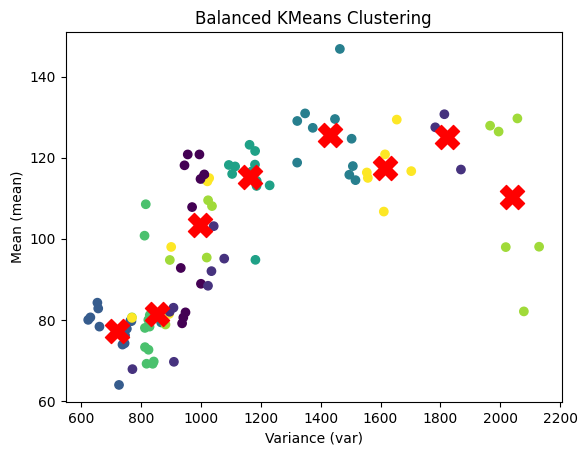

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6934.38it/s]


Epoch 1/100
204/204 [==============================] - 14s 62ms/step - loss: 0.8169 - n2v_mse: 0.8169 - n2v_abs: 0.6949 - val_loss: 0.6000 - val_n2v_mse: 0.6001 - val_n2v_abs: 0.6165
Epoch 2/100
204/204 [==============================] - 12s 61ms/step - loss: 0.5780 - n2v_mse: 0.5780 - n2v_abs: 0.5965 - val_loss: 0.4102 - val_n2v_mse: 0.4101 - val_n2v_abs: 0.5034
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.5786 - n2v_mse: 0.5786 - n2v_abs: 0.5923 - val_loss: 0.3993 - val_n2v_mse: 0.3992 - val_n2v_abs: 0.4975
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 0.5720 - n2v_mse: 0.5720 - n2v_abs: 0.5898 - val_loss: 0.3770 - val_n2v_mse: 0.3769 - val_n2v_abs: 0.4830
Epoch 5/100
204/204 [==============================] - 12s 61ms/step - loss: 0.5773 - n2v_mse: 0.5773 - n2v_abs: 0.5948 - val_loss: 0.3639 - val_n2v_mse: 0.3638 - val_n2v_abs: 0.4746
Epoch 6/100
204/204 [==============================] - 12s 61ms/step - loss: 0.5729 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2168.96it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.0347 - n2v_mse: 1.0347 - n2v_abs: 0.7746 - val_loss: 0.8026 - val_n2v_mse: 0.8032 - val_n2v_abs: 0.7240
Epoch 2/100
102/102 [==============================] - 11s 105ms/step - loss: 0.5926 - n2v_mse: 0.5926 - n2v_abs: 0.6017 - val_loss: 0.6158 - val_n2v_mse: 0.6157 - val_n2v_abs: 0.6321
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.5812 - n2v_mse: 0.5812 - n2v_abs: 0.5961 - val_loss: 0.4751 - val_n2v_mse: 0.4744 - val_n2v_abs: 0.5502
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.5841 - n2v_mse: 0.5841 - n2v_abs: 0.5969 - val_loss: 0.3988 - val_n2v_mse: 0.3974 - val_n2v_abs: 0.5021
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.5603 - n2v_mse: 0.5603 - n2v_abs: 0.5851 - val_loss: 0.3595 - val_n2v_mse: 0.3583 - val_n2v_abs: 0.4704
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 721.23it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 0.9406 - n2v_mse: 0.9406 - n2v_abs: 0.7517 - val_loss: 0.9154 - val_n2v_mse: 0.9168 - val_n2v_abs: 0.7777
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.5947 - n2v_mse: 0.5947 - n2v_abs: 0.6027 - val_loss: 0.8873 - val_n2v_mse: 0.8874 - val_n2v_abs: 0.7712
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.5899 - n2v_mse: 0.5899 - n2v_abs: 0.6011 - val_loss: 0.7425 - val_n2v_mse: 0.7427 - val_n2v_abs: 0.7001
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.5915 - n2v_mse: 0.5915 - n2v_abs: 0.6002 - val_loss: 0.6307 - val_n2v_mse: 0.6318 - val_n2v_abs: 0.6422
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.5661 - n2v_mse: 0.5661 - n2v_abs: 0.5878 - val_loss: 0.4527 - val_n2v_mse: 0.4540 - val_n2v_abs: 0.5347
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.5720 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.07it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6813.45it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.5602 - n2v_mse: 0.5602 - n2v_abs: 0.5861 - val_loss: 0.6116 - val_n2v_mse: 0.6117 - val_n2v_abs: 0.6130
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5583 - n2v_mse: 0.5583 - n2v_abs: 0.5875 - val_loss: 0.5776 - val_n2v_mse: 0.5777 - val_n2v_abs: 0.5985
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5628 - n2v_mse: 0.5628 - n2v_abs: 0.5871 - val_loss: 0.5743 - val_n2v_mse: 0.5744 - val_n2v_abs: 0.5999
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5550 - n2v_mse: 0.5550 - n2v_abs: 0.5860 - val_loss: 0.5816 - val_n2v_mse: 0.5817 - val_n2v_abs: 0.6006
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5477 - n2v_mse: 0.5477 - n2v_abs: 0.5804 - val_loss: 0.5757 - val_n2v_mse: 0.5758 - val_n2v_abs: 0.5980
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5558 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6307.14it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.4733 - n2v_mse: 0.4733 - n2v_abs: 0.5410 - val_loss: 0.6256 - val_n2v_mse: 0.6260 - val_n2v_abs: 0.6221
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4582 - n2v_mse: 0.4582 - n2v_abs: 0.5316 - val_loss: 0.6250 - val_n2v_mse: 0.6254 - val_n2v_abs: 0.6227
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4719 - n2v_mse: 0.4719 - n2v_abs: 0.5398 - val_loss: 0.6267 - val_n2v_mse: 0.6270 - val_n2v_abs: 0.6210
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4738 - n2v_mse: 0.4738 - n2v_abs: 0.5401 - val_loss: 0.6247 - val_n2v_mse: 0.6251 - val_n2v_abs: 0.6214
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4716 - n2v_mse: 0.4716 - n2v_abs: 0.5405 - val_loss: 0.6338 - val_n2v_mse: 0.6341 - val_n2v_abs: 0.6242
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4750 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6397.47it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.4706 - n2v_mse: 0.4706 - n2v_abs: 0.5394 - val_loss: 0.4853 - val_n2v_mse: 0.4852 - val_n2v_abs: 0.5535
Epoch 2/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4692 - n2v_mse: 0.4692 - n2v_abs: 0.5398 - val_loss: 0.4564 - val_n2v_mse: 0.4564 - val_n2v_abs: 0.5394
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4708 - n2v_mse: 0.4708 - n2v_abs: 0.5419 - val_loss: 0.4628 - val_n2v_mse: 0.4628 - val_n2v_abs: 0.5434
Epoch 4/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4765 - n2v_mse: 0.4765 - n2v_abs: 0.5442 - val_loss: 0.4585 - val_n2v_mse: 0.4584 - val_n2v_abs: 0.5406
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4740 - n2v_mse: 0.4740 - n2v_abs: 0.5426 - val_loss: 0.4590 - val_n2v_mse: 0.4590 - val_n2v_abs: 0.5415
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4627 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6721.44it/s]


Epoch 1/20
204/204 [==============================] - 15s 62ms/step - loss: 0.4893 - n2v_mse: 0.4893 - n2v_abs: 0.5512 - val_loss: 0.5358 - val_n2v_mse: 0.5358 - val_n2v_abs: 0.5802
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4950 - n2v_mse: 0.4950 - n2v_abs: 0.5544 - val_loss: 0.5340 - val_n2v_mse: 0.5341 - val_n2v_abs: 0.5799
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.5001 - n2v_mse: 0.5001 - n2v_abs: 0.5566 - val_loss: 0.5385 - val_n2v_mse: 0.5386 - val_n2v_abs: 0.5830
Epoch 4/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4914 - n2v_mse: 0.4914 - n2v_abs: 0.5524 - val_loss: 0.5318 - val_n2v_mse: 0.5318 - val_n2v_abs: 0.5787
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.5039 - n2v_mse: 0.5039 - n2v_abs: 0.5575 - val_loss: 0.5319 - val_n2v_mse: 0.5319 - val_n2v_abs: 0.5796
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4966 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.30it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6506.20it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.5820 - n2v_mse: 0.5820 - n2v_abs: 0.6007 - val_loss: 0.4945 - val_n2v_mse: 0.4944 - val_n2v_abs: 0.5608
Epoch 2/20
204/204 [==============================] - 12s 61ms/step - loss: 0.5724 - n2v_mse: 0.5724 - n2v_abs: 0.5948 - val_loss: 0.4989 - val_n2v_mse: 0.4988 - val_n2v_abs: 0.5639
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.5717 - n2v_mse: 0.5717 - n2v_abs: 0.5943 - val_loss: 0.4972 - val_n2v_mse: 0.4971 - val_n2v_abs: 0.5627
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5613 - n2v_mse: 0.5613 - n2v_abs: 0.5894 - val_loss: 0.4940 - val_n2v_mse: 0.4940 - val_n2v_abs: 0.5609
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.5603 - n2v_mse: 0.5603 - n2v_abs: 0.5888 - val_loss: 0.4934 - val_n2v_mse: 0.4934 - val_n2v_abs: 0.5605
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.5647 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.17it/s]


/root/data/HRTEM of COF lattice/1 co-tapp-bda-cof-mwcnt_50kX_K3_200kV_22437.tif
0


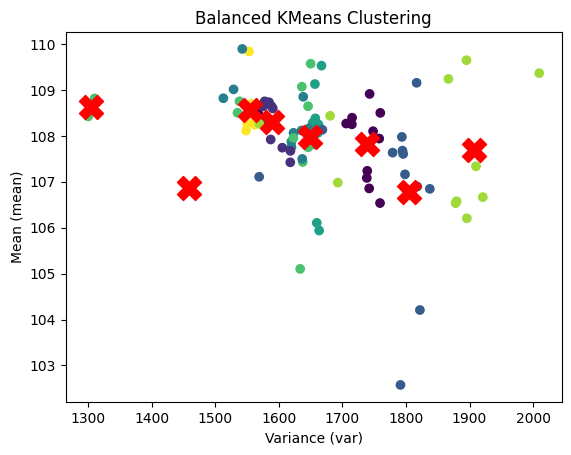

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6582.58it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.1923 - n2v_mse: 1.1923 - n2v_abs: 0.8618 - val_loss: 0.9130 - val_n2v_mse: 0.9130 - val_n2v_abs: 0.7543
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8999 - n2v_mse: 0.8999 - n2v_abs: 0.7548 - val_loss: 0.8833 - val_n2v_mse: 0.8833 - val_n2v_abs: 0.7433
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8657 - n2v_mse: 0.8657 - n2v_abs: 0.7394 - val_loss: 0.8915 - val_n2v_mse: 0.8914 - val_n2v_abs: 0.7496
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8802 - n2v_mse: 0.8802 - n2v_abs: 0.7456 - val_loss: 0.8859 - val_n2v_mse: 0.8858 - val_n2v_abs: 0.7436
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8794 - n2v_mse: 0.8794 - n2v_abs: 0.7447 - val_loss: 0.8821 - val_n2v_mse: 0.8821 - val_n2v_abs: 0.7425
Epoch 6/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8753 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2533.62it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.2216 - n2v_mse: 1.2216 - n2v_abs: 0.8760 - val_loss: 0.9516 - val_n2v_mse: 0.9466 - val_n2v_abs: 0.7735
Epoch 2/100
102/102 [==============================] - 11s 105ms/step - loss: 0.8997 - n2v_mse: 0.8997 - n2v_abs: 0.7549 - val_loss: 0.9183 - val_n2v_mse: 0.9133 - val_n2v_abs: 0.7605
Epoch 3/100
102/102 [==============================] - 11s 105ms/step - loss: 0.8802 - n2v_mse: 0.8802 - n2v_abs: 0.7461 - val_loss: 0.8906 - val_n2v_mse: 0.8861 - val_n2v_abs: 0.7472
Epoch 4/100
102/102 [==============================] - 11s 105ms/step - loss: 0.8847 - n2v_mse: 0.8847 - n2v_abs: 0.7478 - val_loss: 0.8773 - val_n2v_mse: 0.8733 - val_n2v_abs: 0.7411
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8725 - n2v_mse: 0.8725 - n2v_abs: 0.7428 - val_loss: 0.8719 - val_n2v_mse: 0.8678 - val_n2v_abs: 0.7389
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



51/51 [==============================] - 10s 203ms/step - loss: 0.8332 - n2v_mse: 0.8332 - n2v_abs: 0.7255 - val_loss: 0.8577 - val_n2v_mse: 0.8561 - val_n2v_abs: 0.7348
Epoch 37/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8244 - n2v_mse: 0.8244 - n2v_abs: 0.7223 - val_loss: 0.8582 - val_n2v_mse: 0.8567 - val_n2v_abs: 0.7343
Epoch 38/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8316 - n2v_mse: 0.8316 - n2v_abs: 0.7259 - val_loss: 0.8643 - val_n2v_mse: 0.8626 - val_n2v_abs: 0.7385
Epoch 39/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8365 - n2v_mse: 0.8365 - n2v_abs: 0.7276 - val_loss: 0.8550 - val_n2v_mse: 0.8534 - val_n2v_abs: 0.7336
Epoch 40/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8501 - n2v_mse: 0.8501 - n2v_abs: 0.7325 - val_loss: 0.8593 - val_n2v_mse: 0.8577 - val_n2v_abs: 0.7348
Epoch 41/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8278 - n2v_mse: 0.8

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.21it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 738.55it/s]


Epoch 1/50
51/51 [==============================] - 13s 213ms/step - loss: 0.8419 - n2v_mse: 0.8419 - n2v_abs: 0.7300 - val_loss: 5.4058 - val_n2v_mse: 5.3607 - val_n2v_abs: 1.6870
Epoch 2/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8517 - n2v_mse: 0.8517 - n2v_abs: 0.7345 - val_loss: 2.4229 - val_n2v_mse: 2.4022 - val_n2v_abs: 1.0871
Epoch 3/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8493 - n2v_mse: 0.8493 - n2v_abs: 0.7335 - val_loss: 138.2361 - val_n2v_mse: 137.4127 - val_n2v_abs: 9.5524
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8397 - n2v_mse: 0.8397 - n2v_abs: 0.7274 - val_loss: 0.8462 - val_n2v_mse: 0.8467 - val_n2v_abs: 0.7326
Epoch 5/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8548 - n2v_mse: 0.8548 - n2v_abs: 0.7353 - val_loss: 0.8735 - val_n2v_mse: 0.8738 - val_n2v_abs: 0.7457
Epoch 6/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8491 - n2v_mse

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 730.24it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.8283 - n2v_mse: 0.8283 - n2v_abs: 0.7251 - val_loss: 0.9187 - val_n2v_mse: 0.9183 - val_n2v_abs: 0.7599
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8402 - n2v_mse: 0.8402 - n2v_abs: 0.7283 - val_loss: 2.5619 - val_n2v_mse: 2.5397 - val_n2v_abs: 1.1535
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8330 - n2v_mse: 0.8330 - n2v_abs: 0.7257 - val_loss: 0.9629 - val_n2v_mse: 0.9626 - val_n2v_abs: 0.7847
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8245 - n2v_mse: 0.8245 - n2v_abs: 0.7223 - val_loss: 1.2160 - val_n2v_mse: 1.2138 - val_n2v_abs: 0.8806
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8464 - n2v_mse: 0.8464 - n2v_abs: 0.7299 - val_loss: 1.1663 - val_n2v_mse: 1.1649 - val_n2v_abs: 0.8644
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8321 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 720.07it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8304 - n2v_mse: 0.8304 - n2v_abs: 0.7237 - val_loss: 0.8361 - val_n2v_mse: 0.8366 - val_n2v_abs: 0.7267
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8309 - n2v_mse: 0.8309 - n2v_abs: 0.7264 - val_loss: 0.8755 - val_n2v_mse: 0.8754 - val_n2v_abs: 0.7464
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8208 - n2v_mse: 0.8208 - n2v_abs: 0.7207 - val_loss: 1.3847 - val_n2v_mse: 1.3778 - val_n2v_abs: 0.9124
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8389 - n2v_mse: 0.8389 - n2v_abs: 0.7306 - val_loss: 0.8717 - val_n2v_mse: 0.8714 - val_n2v_abs: 0.7430
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8285 - n2v_mse: 0.8285 - n2v_abs: 0.7235 - val_loss: 0.9551 - val_n2v_mse: 0.9552 - val_n2v_abs: 0.7764
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8388 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.26it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 729.62it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8484 - n2v_mse: 0.8484 - n2v_abs: 0.7325 - val_loss: 0.8757 - val_n2v_mse: 0.8749 - val_n2v_abs: 0.7448
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8375 - n2v_mse: 0.8375 - n2v_abs: 0.7299 - val_loss: 1.0582 - val_n2v_mse: 1.0576 - val_n2v_abs: 0.8260
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8498 - n2v_mse: 0.8498 - n2v_abs: 0.7332 - val_loss: 1.0958 - val_n2v_mse: 1.0950 - val_n2v_abs: 0.8236
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8471 - n2v_mse: 0.8471 - n2v_abs: 0.7338 - val_loss: 0.9810 - val_n2v_mse: 0.9803 - val_n2v_abs: 0.7810
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8585 - n2v_mse: 0.8585 - n2v_abs: 0.7391 - val_loss: 0.8369 - val_n2v_mse: 0.8366 - val_n2v_abs: 0.7284
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8431 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 716.57it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8626 - n2v_mse: 0.8626 - n2v_abs: 0.7387 - val_loss: 0.8802 - val_n2v_mse: 0.8807 - val_n2v_abs: 0.7447
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8607 - n2v_mse: 0.8607 - n2v_abs: 0.7365 - val_loss: 0.8434 - val_n2v_mse: 0.8440 - val_n2v_abs: 0.7292
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8592 - n2v_mse: 0.8592 - n2v_abs: 0.7360 - val_loss: 0.8241 - val_n2v_mse: 0.8251 - val_n2v_abs: 0.7202
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8465 - n2v_mse: 0.8465 - n2v_abs: 0.7304 - val_loss: 1.0218 - val_n2v_mse: 1.0270 - val_n2v_abs: 0.7971
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8589 - n2v_mse: 0.8589 - n2v_abs: 0.7386 - val_loss: 1.1432 - val_n2v_mse: 1.1470 - val_n2v_abs: 0.8577
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8552 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.13it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.13it/s]


/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_400kX_K3_200kV_14646.tif
0


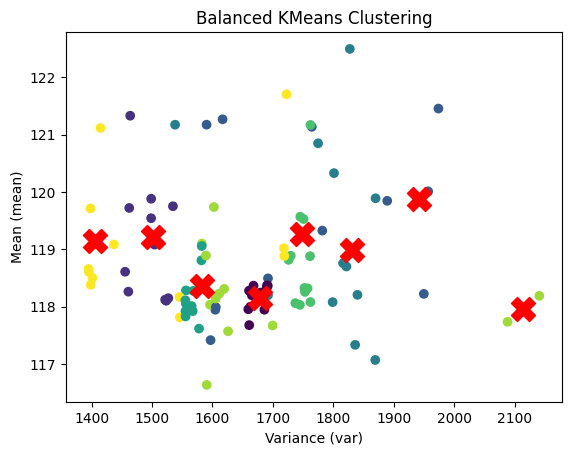

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6629.81it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.2709 - n2v_mse: 1.2709 - n2v_abs: 0.8769 - val_loss: 0.9047 - val_n2v_mse: 0.9046 - val_n2v_abs: 0.7569
Epoch 2/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7916 - n2v_mse: 0.7916 - n2v_abs: 0.7078 - val_loss: 0.8812 - val_n2v_mse: 0.8811 - val_n2v_abs: 0.7474
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7839 - n2v_mse: 0.7839 - n2v_abs: 0.7060 - val_loss: 0.8781 - val_n2v_mse: 0.8780 - val_n2v_abs: 0.7466
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7729 - n2v_mse: 0.7729 - n2v_abs: 0.6998 - val_loss: 0.8792 - val_n2v_mse: 0.8791 - val_n2v_abs: 0.7457
Epoch 5/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7759 - n2v_mse: 0.7759 - n2v_abs: 0.7015 - val_loss: 0.8772 - val_n2v_mse: 0.8771 - val_n2v_abs: 0.7460
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7736 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.18it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2560.82it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.0141 - n2v_mse: 1.0141 - n2v_abs: 0.7954 - val_loss: 0.9409 - val_n2v_mse: 0.9440 - val_n2v_abs: 0.7744
Epoch 2/100
102/102 [==============================] - 11s 105ms/step - loss: 0.7794 - n2v_mse: 0.7794 - n2v_abs: 0.7022 - val_loss: 0.8967 - val_n2v_mse: 0.8993 - val_n2v_abs: 0.7547
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7837 - n2v_mse: 0.7837 - n2v_abs: 0.7041 - val_loss: 0.8809 - val_n2v_mse: 0.8826 - val_n2v_abs: 0.7465
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7668 - n2v_mse: 0.7668 - n2v_abs: 0.6967 - val_loss: 0.8857 - val_n2v_mse: 0.8869 - val_n2v_abs: 0.7484
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7617 - n2v_mse: 0.7617 - n2v_abs: 0.6935 - val_loss: 0.8850 - val_n2v_mse: 0.8861 - val_n2v_abs: 0.7484
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 719.75it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1301 - n2v_mse: 1.1301 - n2v_abs: 0.8407 - val_loss: 0.9987 - val_n2v_mse: 0.9974 - val_n2v_abs: 0.7987
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7869 - n2v_mse: 0.7869 - n2v_abs: 0.7037 - val_loss: 0.9602 - val_n2v_mse: 0.9586 - val_n2v_abs: 0.7829
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7812 - n2v_mse: 0.7812 - n2v_abs: 0.7042 - val_loss: 0.9222 - val_n2v_mse: 0.9205 - val_n2v_abs: 0.7665
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7783 - n2v_mse: 0.7783 - n2v_abs: 0.7011 - val_loss: 0.9048 - val_n2v_mse: 0.9030 - val_n2v_abs: 0.7589
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7616 - n2v_mse: 0.7616 - n2v_abs: 0.6950 - val_loss: 0.8909 - val_n2v_mse: 0.8888 - val_n2v_abs: 0.7516
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7535 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6765.29it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.7635 - n2v_mse: 0.7635 - n2v_abs: 0.6955 - val_loss: 0.7470 - val_n2v_mse: 0.7471 - val_n2v_abs: 0.6913
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7665 - n2v_mse: 0.7665 - n2v_abs: 0.6979 - val_loss: 0.7227 - val_n2v_mse: 0.7227 - val_n2v_abs: 0.6780
Epoch 3/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7711 - n2v_mse: 0.7711 - n2v_abs: 0.7013 - val_loss: 0.7193 - val_n2v_mse: 0.7193 - val_n2v_abs: 0.6758
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7718 - n2v_mse: 0.7718 - n2v_abs: 0.6985 - val_loss: 0.7216 - val_n2v_mse: 0.7216 - val_n2v_abs: 0.6772
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7724 - n2v_mse: 0.7724 - n2v_abs: 0.6973 - val_loss: 0.7196 - val_n2v_mse: 0.7196 - val_n2v_abs: 0.6761
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7723 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.30it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6654.57it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7690 - n2v_mse: 0.7690 - n2v_abs: 0.6987 - val_loss: 0.8469 - val_n2v_mse: 0.8469 - val_n2v_abs: 0.7362
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7688 - n2v_mse: 0.7688 - n2v_abs: 0.6986 - val_loss: 0.7274 - val_n2v_mse: 0.7273 - val_n2v_abs: 0.6797
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7586 - n2v_mse: 0.7586 - n2v_abs: 0.6935 - val_loss: 0.7284 - val_n2v_mse: 0.7282 - val_n2v_abs: 0.6793
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7727 - n2v_mse: 0.7727 - n2v_abs: 0.6995 - val_loss: 0.7635 - val_n2v_mse: 0.7634 - val_n2v_abs: 0.6940
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7544 - n2v_mse: 0.7544 - n2v_abs: 0.6928 - val_loss: 0.7292 - val_n2v_mse: 0.7291 - val_n2v_abs: 0.6801
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7646 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.11it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6722.18it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7429 - n2v_mse: 0.7429 - n2v_abs: 0.6854 - val_loss: 0.7248 - val_n2v_mse: 0.7245 - val_n2v_abs: 0.6770
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7352 - n2v_mse: 0.7352 - n2v_abs: 0.6802 - val_loss: 0.7282 - val_n2v_mse: 0.7279 - val_n2v_abs: 0.6785
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7540 - n2v_mse: 0.7540 - n2v_abs: 0.6897 - val_loss: 0.7516 - val_n2v_mse: 0.7513 - val_n2v_abs: 0.6897
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7488 - n2v_mse: 0.7488 - n2v_abs: 0.6864 - val_loss: 0.7283 - val_n2v_mse: 0.7280 - val_n2v_abs: 0.6794
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7408 - n2v_mse: 0.7408 - n2v_abs: 0.6831 - val_loss: 0.7387 - val_n2v_mse: 0.7384 - val_n2v_abs: 0.6845
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7417 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.16it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6564.14it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7366 - n2v_mse: 0.7366 - n2v_abs: 0.6837 - val_loss: 0.7200 - val_n2v_mse: 0.7198 - val_n2v_abs: 0.6744
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7339 - n2v_mse: 0.7339 - n2v_abs: 0.6827 - val_loss: 0.7084 - val_n2v_mse: 0.7082 - val_n2v_abs: 0.6679
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7437 - n2v_mse: 0.7437 - n2v_abs: 0.6836 - val_loss: 0.7156 - val_n2v_mse: 0.7154 - val_n2v_abs: 0.6707
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7311 - n2v_mse: 0.7311 - n2v_abs: 0.6795 - val_loss: 0.7066 - val_n2v_mse: 0.7064 - val_n2v_abs: 0.6671
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7382 - n2v_mse: 0.7382 - n2v_abs: 0.6821 - val_loss: 0.7079 - val_n2v_mse: 0.7077 - val_n2v_abs: 0.6669
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7535 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 5490.84it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7226 - n2v_mse: 0.7226 - n2v_abs: 0.6781 - val_loss: 0.7348 - val_n2v_mse: 0.7347 - val_n2v_abs: 0.6773
Epoch 2/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7302 - n2v_mse: 0.7302 - n2v_abs: 0.6782 - val_loss: 0.7330 - val_n2v_mse: 0.7328 - val_n2v_abs: 0.6767
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7094 - n2v_mse: 0.7094 - n2v_abs: 0.6698 - val_loss: 0.7274 - val_n2v_mse: 0.7272 - val_n2v_abs: 0.6742
Epoch 4/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7141 - n2v_mse: 0.7141 - n2v_abs: 0.6715 - val_loss: 0.7337 - val_n2v_mse: 0.7336 - val_n2v_abs: 0.6773
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7103 - n2v_mse: 0.7103 - n2v_abs: 0.6721 - val_loss: 0.7290 - val_n2v_mse: 0.7288 - val_n2v_abs: 0.6751
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7180 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.10it/s]


/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_250kX_K3_200kV_14618.tif
0


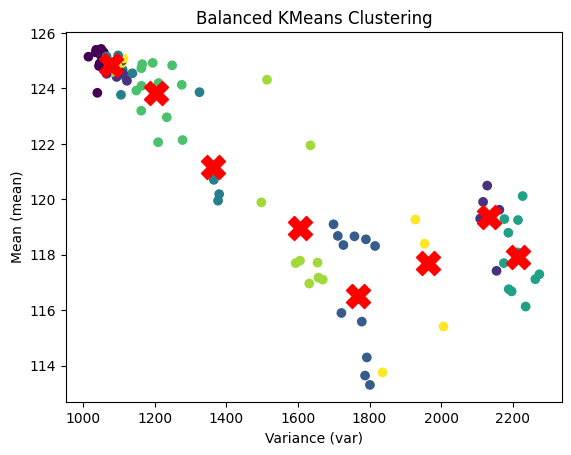

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6660.23it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.0023 - n2v_mse: 1.0023 - n2v_abs: 0.7840 - val_loss: 0.7682 - val_n2v_mse: 0.7687 - val_n2v_abs: 0.6978
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6979 - n2v_mse: 0.6979 - n2v_abs: 0.6584 - val_loss: 0.6802 - val_n2v_mse: 0.6808 - val_n2v_abs: 0.6536
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.6919 - n2v_mse: 0.6919 - n2v_abs: 0.6562 - val_loss: 0.6839 - val_n2v_mse: 0.6846 - val_n2v_abs: 0.6553
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6934 - n2v_mse: 0.6934 - n2v_abs: 0.6583 - val_loss: 0.6827 - val_n2v_mse: 0.6833 - val_n2v_abs: 0.6541
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6917 - n2v_mse: 0.6917 - n2v_abs: 0.6565 - val_loss: 0.6746 - val_n2v_mse: 0.6752 - val_n2v_abs: 0.6512
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7027 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2535.98it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 0.9566 - n2v_mse: 0.9566 - n2v_abs: 0.7667 - val_loss: 0.8577 - val_n2v_mse: 0.8541 - val_n2v_abs: 0.7385
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7065 - n2v_mse: 0.7065 - n2v_abs: 0.6638 - val_loss: 0.7494 - val_n2v_mse: 0.7476 - val_n2v_abs: 0.6876
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6985 - n2v_mse: 0.6985 - n2v_abs: 0.6604 - val_loss: 0.7163 - val_n2v_mse: 0.7148 - val_n2v_abs: 0.6710
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7043 - n2v_mse: 0.7043 - n2v_abs: 0.6630 - val_loss: 0.6795 - val_n2v_mse: 0.6795 - val_n2v_abs: 0.6507
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6919 - n2v_mse: 0.6919 - n2v_abs: 0.6563 - val_loss: 0.6703 - val_n2v_mse: 0.6709 - val_n2v_abs: 0.6474
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 739.64it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 0.9976 - n2v_mse: 0.9976 - n2v_abs: 0.7818 - val_loss: 0.8685 - val_n2v_mse: 0.8712 - val_n2v_abs: 0.7397
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7070 - n2v_mse: 0.7070 - n2v_abs: 0.6639 - val_loss: 0.8342 - val_n2v_mse: 0.8370 - val_n2v_abs: 0.7253
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6714 - n2v_mse: 0.6714 - n2v_abs: 0.6465 - val_loss: 0.8000 - val_n2v_mse: 0.8026 - val_n2v_abs: 0.7116
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6906 - n2v_mse: 0.6906 - n2v_abs: 0.6563 - val_loss: 0.7425 - val_n2v_mse: 0.7448 - val_n2v_abs: 0.6844
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6830 - n2v_mse: 0.6830 - n2v_abs: 0.6521 - val_loss: 0.7096 - val_n2v_mse: 0.7120 - val_n2v_abs: 0.6661
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6985 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.11it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 769.25it/s]


Epoch 1/50
51/51 [==============================] - 13s 213ms/step - loss: 0.7011 - n2v_mse: 0.7011 - n2v_abs: 0.6637 - val_loss: 1.9267 - val_n2v_mse: 1.9524 - val_n2v_abs: 1.0376
Epoch 2/50
51/51 [==============================] - 10s 203ms/step - loss: 0.6859 - n2v_mse: 0.6859 - n2v_abs: 0.6570 - val_loss: 1.1315 - val_n2v_mse: 1.1417 - val_n2v_abs: 0.8239
Epoch 3/50
51/51 [==============================] - 10s 203ms/step - loss: 0.6832 - n2v_mse: 0.6832 - n2v_abs: 0.6532 - val_loss: 0.7628 - val_n2v_mse: 0.7661 - val_n2v_abs: 0.6904
Epoch 4/50
51/51 [==============================] - 10s 202ms/step - loss: 0.6786 - n2v_mse: 0.6786 - n2v_abs: 0.6502 - val_loss: 1.5229 - val_n2v_mse: 1.5377 - val_n2v_abs: 0.9348
Epoch 5/50
51/51 [==============================] - 10s 202ms/step - loss: 0.6965 - n2v_mse: 0.6965 - n2v_abs: 0.6637 - val_loss: 0.8860 - val_n2v_mse: 0.8915 - val_n2v_abs: 0.7359
Epoch 6/50
51/51 [==============================] - 10s 202ms/step - loss: 0.7007 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 744.61it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.6969 - n2v_mse: 0.6969 - n2v_abs: 0.6598 - val_loss: 0.6766 - val_n2v_mse: 0.6756 - val_n2v_abs: 0.6305
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7060 - n2v_mse: 0.7060 - n2v_abs: 0.6638 - val_loss: 0.5682 - val_n2v_mse: 0.5688 - val_n2v_abs: 0.5953
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.6919 - n2v_mse: 0.6919 - n2v_abs: 0.6575 - val_loss: 0.6784 - val_n2v_mse: 0.6780 - val_n2v_abs: 0.6332
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.6878 - n2v_mse: 0.6878 - n2v_abs: 0.6551 - val_loss: 0.6330 - val_n2v_mse: 0.6326 - val_n2v_abs: 0.6144
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.6999 - n2v_mse: 0.6999 - n2v_abs: 0.6605 - val_loss: 0.5718 - val_n2v_mse: 0.5725 - val_n2v_abs: 0.5975
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7054 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 696.59it/s]


Epoch 1/20
51/51 [==============================] - 13s 212ms/step - loss: 0.7192 - n2v_mse: 0.7192 - n2v_abs: 0.6705 - val_loss: 0.8698 - val_n2v_mse: 0.8665 - val_n2v_abs: 0.7239
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7288 - n2v_mse: 0.7288 - n2v_abs: 0.6768 - val_loss: 0.7403 - val_n2v_mse: 0.7389 - val_n2v_abs: 0.6827
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7021 - n2v_mse: 0.7021 - n2v_abs: 0.6646 - val_loss: 0.7365 - val_n2v_mse: 0.7351 - val_n2v_abs: 0.6799
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7003 - n2v_mse: 0.7003 - n2v_abs: 0.6618 - val_loss: 0.7331 - val_n2v_mse: 0.7318 - val_n2v_abs: 0.6800
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7127 - n2v_mse: 0.7127 - n2v_abs: 0.6676 - val_loss: 0.7542 - val_n2v_mse: 0.7528 - val_n2v_abs: 0.6874
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7279 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.10it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 709.21it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7194 - n2v_mse: 0.7194 - n2v_abs: 0.6707 - val_loss: 0.7128 - val_n2v_mse: 0.7119 - val_n2v_abs: 0.6681
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7314 - n2v_mse: 0.7314 - n2v_abs: 0.6745 - val_loss: 0.6904 - val_n2v_mse: 0.6897 - val_n2v_abs: 0.6601
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7127 - n2v_mse: 0.7127 - n2v_abs: 0.6684 - val_loss: 0.7004 - val_n2v_mse: 0.6996 - val_n2v_abs: 0.6638
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7020 - n2v_mse: 0.7020 - n2v_abs: 0.6611 - val_loss: 0.7255 - val_n2v_mse: 0.7246 - val_n2v_abs: 0.6766
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7267 - n2v_mse: 0.7267 - n2v_abs: 0.6732 - val_loss: 0.6922 - val_n2v_mse: 0.6915 - val_n2v_abs: 0.6607
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7309 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 701.56it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7217 - n2v_mse: 0.7217 - n2v_abs: 0.6758 - val_loss: 0.6557 - val_n2v_mse: 0.6560 - val_n2v_abs: 0.6451
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7256 - n2v_mse: 0.7256 - n2v_abs: 0.6739 - val_loss: 0.6598 - val_n2v_mse: 0.6601 - val_n2v_abs: 0.6479
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7188 - n2v_mse: 0.7188 - n2v_abs: 0.6721 - val_loss: 0.6714 - val_n2v_mse: 0.6717 - val_n2v_abs: 0.6513
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7087 - n2v_mse: 0.7087 - n2v_abs: 0.6681 - val_loss: 0.6768 - val_n2v_mse: 0.6772 - val_n2v_abs: 0.6542
Epoch 5/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7209 - n2v_mse: 0.7209 - n2v_abs: 0.6745 - val_loss: 0.6652 - val_n2v_mse: 0.6656 - val_n2v_abs: 0.6496
Epoch 6/20
51/51 [==============================] - 10s 202ms/step - loss: 0.7245 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.40it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.13it/s]


/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_250kX_K3_200kV_14619.tif
0


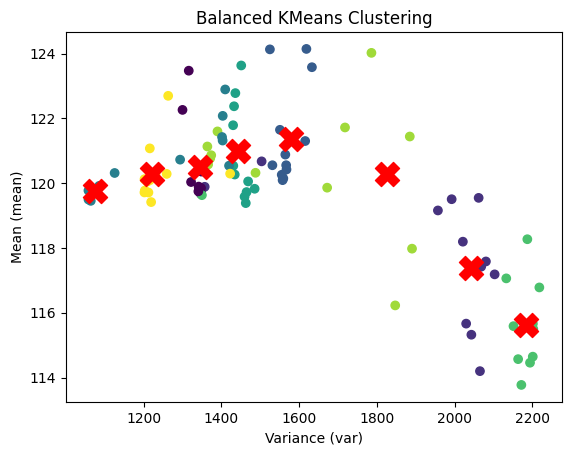

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6698.83it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.0334 - n2v_mse: 1.0334 - n2v_abs: 0.8039 - val_loss: 0.9452 - val_n2v_mse: 0.9452 - val_n2v_abs: 0.7739
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8400 - n2v_mse: 0.8400 - n2v_abs: 0.7307 - val_loss: 0.8608 - val_n2v_mse: 0.8608 - val_n2v_abs: 0.7374
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8360 - n2v_mse: 0.8360 - n2v_abs: 0.7296 - val_loss: 0.8323 - val_n2v_mse: 0.8323 - val_n2v_abs: 0.7265
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8288 - n2v_mse: 0.8288 - n2v_abs: 0.7256 - val_loss: 0.8342 - val_n2v_mse: 0.8342 - val_n2v_abs: 0.7261
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8324 - n2v_mse: 0.8324 - n2v_abs: 0.7253 - val_loss: 0.8490 - val_n2v_mse: 0.8490 - val_n2v_abs: 0.7326
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8234 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2170.42it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.1140 - n2v_mse: 1.1140 - n2v_abs: 0.8361 - val_loss: 0.9499 - val_n2v_mse: 0.9453 - val_n2v_abs: 0.7748
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8456 - n2v_mse: 0.8456 - n2v_abs: 0.7304 - val_loss: 0.8854 - val_n2v_mse: 0.8814 - val_n2v_abs: 0.7494
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8380 - n2v_mse: 0.8380 - n2v_abs: 0.7297 - val_loss: 0.8422 - val_n2v_mse: 0.8384 - val_n2v_abs: 0.7314
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8299 - n2v_mse: 0.8299 - n2v_abs: 0.7267 - val_loss: 0.8174 - val_n2v_mse: 0.8139 - val_n2v_abs: 0.7208
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8244 - n2v_mse: 0.8244 - n2v_abs: 0.7245 - val_loss: 0.8136 - val_n2v_mse: 0.8101 - val_n2v_abs: 0.7193
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 732.47it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1412 - n2v_mse: 1.1412 - n2v_abs: 0.8478 - val_loss: 1.0110 - val_n2v_mse: 1.0062 - val_n2v_abs: 0.7973
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8553 - n2v_mse: 0.8553 - n2v_abs: 0.7374 - val_loss: 0.9868 - val_n2v_mse: 0.9821 - val_n2v_abs: 0.7879
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8379 - n2v_mse: 0.8379 - n2v_abs: 0.7286 - val_loss: 0.9482 - val_n2v_mse: 0.9439 - val_n2v_abs: 0.7729
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8289 - n2v_mse: 0.8289 - n2v_abs: 0.7277 - val_loss: 0.9095 - val_n2v_mse: 0.9056 - val_n2v_abs: 0.7589
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8424 - n2v_mse: 0.8424 - n2v_abs: 0.7307 - val_loss: 0.8815 - val_n2v_mse: 0.8782 - val_n2v_abs: 0.7448
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8192 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2566.57it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.8090 - n2v_mse: 0.8090 - n2v_abs: 0.7173 - val_loss: 0.8286 - val_n2v_mse: 0.8247 - val_n2v_abs: 0.7228
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8033 - n2v_mse: 0.8033 - n2v_abs: 0.7156 - val_loss: 0.8202 - val_n2v_mse: 0.8165 - val_n2v_abs: 0.7207
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8077 - n2v_mse: 0.8077 - n2v_abs: 0.7169 - val_loss: 0.8393 - val_n2v_mse: 0.8356 - val_n2v_abs: 0.7285
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8084 - n2v_mse: 0.8084 - n2v_abs: 0.7162 - val_loss: 0.8325 - val_n2v_mse: 0.8287 - val_n2v_abs: 0.7246
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8101 - n2v_mse: 0.8101 - n2v_abs: 0.7174 - val_loss: 0.8257 - val_n2v_mse: 0.8219 - val_n2v_abs: 0.7218
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.8062 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.35it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2671.72it/s]


Epoch 1/20
102/102 [==============================] - 13s 108ms/step - loss: 0.8645 - n2v_mse: 0.8645 - n2v_abs: 0.7435 - val_loss: 0.7568 - val_n2v_mse: 0.7535 - val_n2v_abs: 0.6907
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8579 - n2v_mse: 0.8579 - n2v_abs: 0.7388 - val_loss: 0.7595 - val_n2v_mse: 0.7556 - val_n2v_abs: 0.6920
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8557 - n2v_mse: 0.8557 - n2v_abs: 0.7363 - val_loss: 0.7959 - val_n2v_mse: 0.7923 - val_n2v_abs: 0.7082
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8486 - n2v_mse: 0.8486 - n2v_abs: 0.7344 - val_loss: 0.8322 - val_n2v_mse: 0.8270 - val_n2v_abs: 0.7240
Epoch 5/20
102/102 [==============================] - 11s 103ms/step - loss: 0.8525 - n2v_mse: 0.8525 - n2v_abs: 0.7349 - val_loss: 0.7621 - val_n2v_mse: 0.7586 - val_n2v_abs: 0.6931
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8467 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2451.52it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.8328 - n2v_mse: 0.8328 - n2v_abs: 0.7254 - val_loss: 0.8813 - val_n2v_mse: 0.8777 - val_n2v_abs: 0.7466
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8427 - n2v_mse: 0.8427 - n2v_abs: 0.7311 - val_loss: 0.8773 - val_n2v_mse: 0.8736 - val_n2v_abs: 0.7441
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8394 - n2v_mse: 0.8394 - n2v_abs: 0.7276 - val_loss: 0.8774 - val_n2v_mse: 0.8735 - val_n2v_abs: 0.7449
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8407 - n2v_mse: 0.8407 - n2v_abs: 0.7300 - val_loss: 0.8709 - val_n2v_mse: 0.8669 - val_n2v_abs: 0.7421
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8367 - n2v_mse: 0.8367 - n2v_abs: 0.7301 - val_loss: 0.8841 - val_n2v_mse: 0.8798 - val_n2v_abs: 0.7459
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8356 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.31it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2544.19it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.8655 - n2v_mse: 0.8655 - n2v_abs: 0.7421 - val_loss: 0.8790 - val_n2v_mse: 0.8763 - val_n2v_abs: 0.7429
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8448 - n2v_mse: 0.8448 - n2v_abs: 0.7320 - val_loss: 0.8609 - val_n2v_mse: 0.8586 - val_n2v_abs: 0.7366
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8545 - n2v_mse: 0.8545 - n2v_abs: 0.7359 - val_loss: 0.8643 - val_n2v_mse: 0.8620 - val_n2v_abs: 0.7376
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8475 - n2v_mse: 0.8475 - n2v_abs: 0.7315 - val_loss: 0.8679 - val_n2v_mse: 0.8654 - val_n2v_abs: 0.7391
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8785 - n2v_mse: 0.8785 - n2v_abs: 0.7449 - val_loss: 0.8698 - val_n2v_mse: 0.8678 - val_n2v_abs: 0.7411
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8646 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2445.68it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.9046 - n2v_mse: 0.9046 - n2v_abs: 0.7560 - val_loss: 0.9097 - val_n2v_mse: 0.9092 - val_n2v_abs: 0.7597
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.9121 - n2v_mse: 0.9121 - n2v_abs: 0.7607 - val_loss: 0.8985 - val_n2v_mse: 0.8979 - val_n2v_abs: 0.7547
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8928 - n2v_mse: 0.8928 - n2v_abs: 0.7525 - val_loss: 0.8988 - val_n2v_mse: 0.8984 - val_n2v_abs: 0.7552
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.9042 - n2v_mse: 0.9042 - n2v_abs: 0.7575 - val_loss: 0.9062 - val_n2v_mse: 0.9054 - val_n2v_abs: 0.7571
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.8982 - n2v_mse: 0.8982 - n2v_abs: 0.7534 - val_loss: 0.8966 - val_n2v_mse: 0.8961 - val_n2v_abs: 0.7542
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.9050 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.05it/s]


/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_250kX_K3_200kV_14621.tif
0


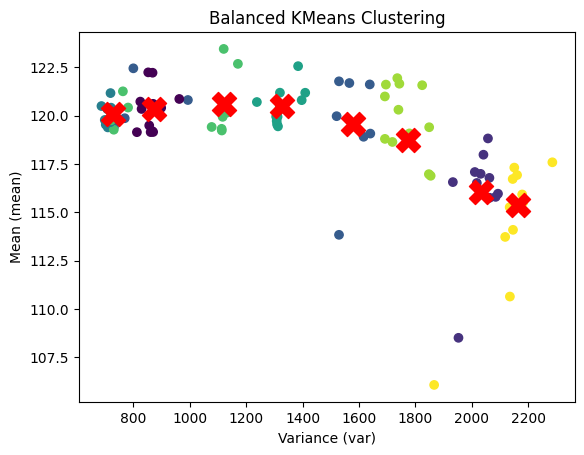

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6774.22it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.1121 - n2v_mse: 1.1121 - n2v_abs: 0.8211 - val_loss: 1.0258 - val_n2v_mse: 1.0260 - val_n2v_abs: 0.8051
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7966 - n2v_mse: 0.7966 - n2v_abs: 0.6992 - val_loss: 0.9964 - val_n2v_mse: 0.9966 - val_n2v_abs: 0.7926
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7804 - n2v_mse: 0.7804 - n2v_abs: 0.6937 - val_loss: 0.9885 - val_n2v_mse: 0.9887 - val_n2v_abs: 0.7910
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7744 - n2v_mse: 0.7744 - n2v_abs: 0.6898 - val_loss: 0.9692 - val_n2v_mse: 0.9693 - val_n2v_abs: 0.7837
Epoch 5/100
204/204 [==============================] - 12s 61ms/step - loss: 0.7738 - n2v_mse: 0.7738 - n2v_abs: 0.6890 - val_loss: 0.9742 - val_n2v_mse: 0.9744 - val_n2v_abs: 0.7846
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7865 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2624.58it/s]


Epoch 1/100
102/102 [==============================] - 13s 110ms/step - loss: 1.0732 - n2v_mse: 1.0732 - n2v_abs: 0.8039 - val_loss: 1.0604 - val_n2v_mse: 1.0614 - val_n2v_abs: 0.8131
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7950 - n2v_mse: 0.7950 - n2v_abs: 0.7003 - val_loss: 1.0094 - val_n2v_mse: 1.0105 - val_n2v_abs: 0.7936
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7901 - n2v_mse: 0.7901 - n2v_abs: 0.6948 - val_loss: 0.9985 - val_n2v_mse: 0.9997 - val_n2v_abs: 0.7882
Epoch 4/100
102/102 [==============================] - 11s 105ms/step - loss: 0.7782 - n2v_mse: 0.7782 - n2v_abs: 0.6930 - val_loss: 0.9834 - val_n2v_mse: 0.9837 - val_n2v_abs: 0.7839
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7725 - n2v_mse: 0.7725 - n2v_abs: 0.6882 - val_loss: 0.9482 - val_n2v_mse: 0.9484 - val_n2v_abs: 0.7710
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 688.17it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1771 - n2v_mse: 1.1771 - n2v_abs: 0.8443 - val_loss: 1.0918 - val_n2v_mse: 1.0947 - val_n2v_abs: 0.8301
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7947 - n2v_mse: 0.7947 - n2v_abs: 0.6991 - val_loss: 1.0808 - val_n2v_mse: 1.0836 - val_n2v_abs: 0.8258
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7824 - n2v_mse: 0.7824 - n2v_abs: 0.6912 - val_loss: 1.0460 - val_n2v_mse: 1.0481 - val_n2v_abs: 0.8113
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7493 - n2v_mse: 0.7493 - n2v_abs: 0.6765 - val_loss: 1.0478 - val_n2v_mse: 1.0500 - val_n2v_abs: 0.8128
Epoch 5/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7739 - n2v_mse: 0.7739 - n2v_abs: 0.6897 - val_loss: 1.0272 - val_n2v_mse: 1.0288 - val_n2v_abs: 0.8041
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.7701 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.10it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6192.98it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.7656 - n2v_mse: 0.7656 - n2v_abs: 0.6870 - val_loss: 0.9976 - val_n2v_mse: 0.9978 - val_n2v_abs: 0.7901
Epoch 2/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7621 - n2v_mse: 0.7621 - n2v_abs: 0.6839 - val_loss: 0.9646 - val_n2v_mse: 0.9649 - val_n2v_abs: 0.7775
Epoch 3/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7808 - n2v_mse: 0.7808 - n2v_abs: 0.6919 - val_loss: 0.9585 - val_n2v_mse: 0.9588 - val_n2v_abs: 0.7758
Epoch 4/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7642 - n2v_mse: 0.7642 - n2v_abs: 0.6844 - val_loss: 0.9655 - val_n2v_mse: 0.9657 - val_n2v_abs: 0.7777
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.7553 - n2v_mse: 0.7553 - n2v_abs: 0.6817 - val_loss: 0.9588 - val_n2v_mse: 0.9590 - val_n2v_abs: 0.7758
Epoch 6/50
204/204 [==============================] - 12s 61ms/step - loss: 0.7711 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.44it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6619.53it/s]


Epoch 1/20
204/204 [==============================] - 14s 62ms/step - loss: 0.7711 - n2v_mse: 0.7711 - n2v_abs: 0.6874 - val_loss: 0.9429 - val_n2v_mse: 0.9429 - val_n2v_abs: 0.7712
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7746 - n2v_mse: 0.7746 - n2v_abs: 0.6887 - val_loss: 0.9413 - val_n2v_mse: 0.9413 - val_n2v_abs: 0.7707
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7713 - n2v_mse: 0.7713 - n2v_abs: 0.6875 - val_loss: 0.9347 - val_n2v_mse: 0.9347 - val_n2v_abs: 0.7671
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7642 - n2v_mse: 0.7642 - n2v_abs: 0.6843 - val_loss: 0.9383 - val_n2v_mse: 0.9383 - val_n2v_abs: 0.7691
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7923 - n2v_mse: 0.7923 - n2v_abs: 0.6956 - val_loss: 0.9369 - val_n2v_mse: 0.9368 - val_n2v_abs: 0.7687
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7684 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.29it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 5569.73it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7724 - n2v_mse: 0.7724 - n2v_abs: 0.6894 - val_loss: 0.9076 - val_n2v_mse: 0.9078 - val_n2v_abs: 0.7457
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7900 - n2v_mse: 0.7900 - n2v_abs: 0.6966 - val_loss: 0.9038 - val_n2v_mse: 0.9040 - val_n2v_abs: 0.7433
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7755 - n2v_mse: 0.7755 - n2v_abs: 0.6899 - val_loss: 0.9013 - val_n2v_mse: 0.9016 - val_n2v_abs: 0.7426
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7873 - n2v_mse: 0.7873 - n2v_abs: 0.6973 - val_loss: 0.9063 - val_n2v_mse: 0.9065 - val_n2v_abs: 0.7448
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7707 - n2v_mse: 0.7707 - n2v_abs: 0.6891 - val_loss: 0.9089 - val_n2v_mse: 0.9091 - val_n2v_abs: 0.7454
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7701 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6555.23it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7130 - n2v_mse: 0.7130 - n2v_abs: 0.6590 - val_loss: 0.9613 - val_n2v_mse: 0.9614 - val_n2v_abs: 0.7646
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7273 - n2v_mse: 0.7273 - n2v_abs: 0.6669 - val_loss: 0.9619 - val_n2v_mse: 0.9621 - val_n2v_abs: 0.7661
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7042 - n2v_mse: 0.7042 - n2v_abs: 0.6574 - val_loss: 0.9625 - val_n2v_mse: 0.9627 - val_n2v_abs: 0.7656
Epoch 4/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7250 - n2v_mse: 0.7250 - n2v_abs: 0.6671 - val_loss: 0.9710 - val_n2v_mse: 0.9712 - val_n2v_abs: 0.7689
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7095 - n2v_mse: 0.7095 - n2v_abs: 0.6593 - val_loss: 0.9624 - val_n2v_mse: 0.9626 - val_n2v_abs: 0.7660
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7125 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6700.03it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.7567 - n2v_mse: 0.7567 - n2v_abs: 0.6772 - val_loss: 0.8737 - val_n2v_mse: 0.8735 - val_n2v_abs: 0.7346
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7639 - n2v_mse: 0.7639 - n2v_abs: 0.6819 - val_loss: 0.8648 - val_n2v_mse: 0.8646 - val_n2v_abs: 0.7307
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.7533 - n2v_mse: 0.7533 - n2v_abs: 0.6745 - val_loss: 0.8703 - val_n2v_mse: 0.8701 - val_n2v_abs: 0.7322
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7424 - n2v_mse: 0.7424 - n2v_abs: 0.6679 - val_loss: 0.8786 - val_n2v_mse: 0.8784 - val_n2v_abs: 0.7375
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7454 - n2v_mse: 0.7454 - n2v_abs: 0.6709 - val_loss: 0.8652 - val_n2v_mse: 0.8650 - val_n2v_abs: 0.7298
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.7452 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.21it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


/root/data/HRTEM of Ne-at-C60/ICZ-083 (Ne@C60)@SWCNT_400kX_K3_200kV_14638.tif
0


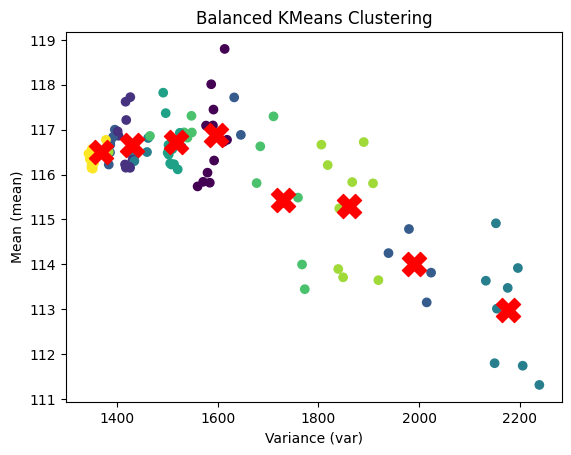

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6584.18it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.1133 - n2v_mse: 1.1133 - n2v_abs: 0.8305 - val_loss: 0.8492 - val_n2v_mse: 0.8492 - val_n2v_abs: 0.7343
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7943 - n2v_mse: 0.7943 - n2v_abs: 0.7113 - val_loss: 0.7887 - val_n2v_mse: 0.7887 - val_n2v_abs: 0.7096
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8026 - n2v_mse: 0.8026 - n2v_abs: 0.7150 - val_loss: 0.7856 - val_n2v_mse: 0.7856 - val_n2v_abs: 0.7063
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7950 - n2v_mse: 0.7950 - n2v_abs: 0.7107 - val_loss: 0.7786 - val_n2v_mse: 0.7786 - val_n2v_abs: 0.7030
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7880 - n2v_mse: 0.7880 - n2v_abs: 0.7076 - val_loss: 0.7822 - val_n2v_mse: 0.7822 - val_n2v_abs: 0.7053
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7931 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2566.11it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.0726 - n2v_mse: 1.0726 - n2v_abs: 0.8187 - val_loss: 0.8927 - val_n2v_mse: 0.8928 - val_n2v_abs: 0.7470
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7997 - n2v_mse: 0.7997 - n2v_abs: 0.7111 - val_loss: 0.8412 - val_n2v_mse: 0.8413 - val_n2v_abs: 0.7270
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7851 - n2v_mse: 0.7851 - n2v_abs: 0.7069 - val_loss: 0.7970 - val_n2v_mse: 0.7973 - val_n2v_abs: 0.7094
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7919 - n2v_mse: 0.7919 - n2v_abs: 0.7081 - val_loss: 0.7850 - val_n2v_mse: 0.7852 - val_n2v_abs: 0.7050
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7850 - n2v_mse: 0.7850 - n2v_abs: 0.7056 - val_loss: 0.7775 - val_n2v_mse: 0.7775 - val_n2v_abs: 0.7022
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.13it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 776.64it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 1.1018 - n2v_mse: 1.1018 - n2v_abs: 0.8295 - val_loss: 0.8821 - val_n2v_mse: 0.8803 - val_n2v_abs: 0.7468
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7973 - n2v_mse: 0.7973 - n2v_abs: 0.7104 - val_loss: 0.8591 - val_n2v_mse: 0.8576 - val_n2v_abs: 0.7362
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7872 - n2v_mse: 0.7872 - n2v_abs: 0.7064 - val_loss: 0.8407 - val_n2v_mse: 0.8394 - val_n2v_abs: 0.7282
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7780 - n2v_mse: 0.7780 - n2v_abs: 0.7044 - val_loss: 0.8122 - val_n2v_mse: 0.8110 - val_n2v_abs: 0.7169
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7836 - n2v_mse: 0.7836 - n2v_abs: 0.7058 - val_loss: 0.7922 - val_n2v_mse: 0.7912 - val_n2v_abs: 0.7082
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7761 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.18it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6418.70it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.8164 - n2v_mse: 0.8164 - n2v_abs: 0.7202 - val_loss: 0.7897 - val_n2v_mse: 0.7896 - val_n2v_abs: 0.7098
Epoch 2/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8175 - n2v_mse: 0.8175 - n2v_abs: 0.7203 - val_loss: 0.7726 - val_n2v_mse: 0.7725 - val_n2v_abs: 0.6982
Epoch 3/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8127 - n2v_mse: 0.8127 - n2v_abs: 0.7196 - val_loss: 0.7676 - val_n2v_mse: 0.7675 - val_n2v_abs: 0.6989
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8306 - n2v_mse: 0.8306 - n2v_abs: 0.7295 - val_loss: 0.7606 - val_n2v_mse: 0.7605 - val_n2v_abs: 0.6945
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8279 - n2v_mse: 0.8279 - n2v_abs: 0.7249 - val_loss: 0.7613 - val_n2v_mse: 0.7612 - val_n2v_abs: 0.6957
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.8057 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.27it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6928.30it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.8345 - n2v_mse: 0.8345 - n2v_abs: 0.7304 - val_loss: 0.8436 - val_n2v_mse: 0.8433 - val_n2v_abs: 0.7305
Epoch 2/20
204/204 [==============================] - 12s 61ms/step - loss: 0.8416 - n2v_mse: 0.8416 - n2v_abs: 0.7304 - val_loss: 0.8421 - val_n2v_mse: 0.8418 - val_n2v_abs: 0.7298
Epoch 3/20
204/204 [==============================] - 12s 61ms/step - loss: 0.8271 - n2v_mse: 0.8271 - n2v_abs: 0.7258 - val_loss: 0.8356 - val_n2v_mse: 0.8353 - val_n2v_abs: 0.7287
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8319 - n2v_mse: 0.8319 - n2v_abs: 0.7265 - val_loss: 0.8382 - val_n2v_mse: 0.8379 - val_n2v_abs: 0.7293
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8316 - n2v_mse: 0.8316 - n2v_abs: 0.7252 - val_loss: 0.8379 - val_n2v_mse: 0.8376 - val_n2v_abs: 0.7296
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8394 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.34it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6450.37it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.8159 - n2v_mse: 0.8159 - n2v_abs: 0.7191 - val_loss: 0.8190 - val_n2v_mse: 0.8190 - val_n2v_abs: 0.7213
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8001 - n2v_mse: 0.8001 - n2v_abs: 0.7118 - val_loss: 0.8195 - val_n2v_mse: 0.8195 - val_n2v_abs: 0.7227
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8085 - n2v_mse: 0.8085 - n2v_abs: 0.7167 - val_loss: 0.8192 - val_n2v_mse: 0.8192 - val_n2v_abs: 0.7222
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8084 - n2v_mse: 0.8084 - n2v_abs: 0.7166 - val_loss: 0.8233 - val_n2v_mse: 0.8233 - val_n2v_abs: 0.7240
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.8108 - n2v_mse: 0.8108 - n2v_abs: 0.7184 - val_loss: 0.8270 - val_n2v_mse: 0.8270 - val_n2v_abs: 0.7253
Epoch 6/20
204/204 [==============================] - 12s 61ms/step - loss: 0.8139 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24369.tif
0


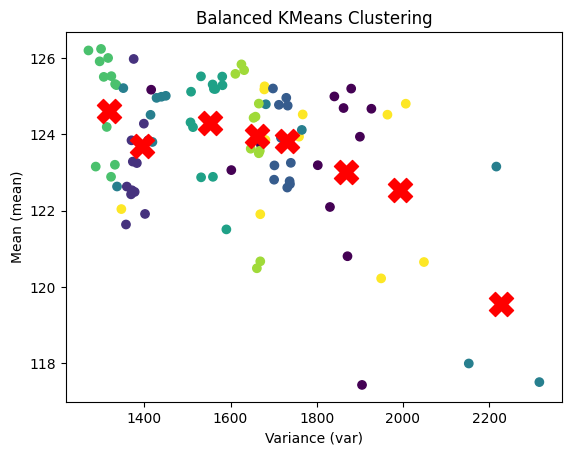

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6491.03it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.1155 - n2v_mse: 1.1155 - n2v_abs: 0.8262 - val_loss: 0.8251 - val_n2v_mse: 0.8253 - val_n2v_abs: 0.7181
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8189 - n2v_mse: 0.8189 - n2v_abs: 0.7213 - val_loss: 0.7994 - val_n2v_mse: 0.7997 - val_n2v_abs: 0.7063
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8127 - n2v_mse: 0.8127 - n2v_abs: 0.7158 - val_loss: 0.7921 - val_n2v_mse: 0.7923 - val_n2v_abs: 0.7037
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8094 - n2v_mse: 0.8094 - n2v_abs: 0.7147 - val_loss: 0.7925 - val_n2v_mse: 0.7928 - val_n2v_abs: 0.7028
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7992 - n2v_mse: 0.7992 - n2v_abs: 0.7073 - val_loss: 0.7852 - val_n2v_mse: 0.7854 - val_n2v_abs: 0.6996
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7873 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2610.07it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.0651 - n2v_mse: 1.0651 - n2v_abs: 0.8176 - val_loss: 0.8739 - val_n2v_mse: 0.8763 - val_n2v_abs: 0.7456
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8057 - n2v_mse: 0.8057 - n2v_abs: 0.7118 - val_loss: 0.8405 - val_n2v_mse: 0.8434 - val_n2v_abs: 0.7295
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7979 - n2v_mse: 0.7979 - n2v_abs: 0.7085 - val_loss: 0.8217 - val_n2v_mse: 0.8250 - val_n2v_abs: 0.7189
Epoch 4/100
102/102 [==============================] - 11s 105ms/step - loss: 0.8002 - n2v_mse: 0.8002 - n2v_abs: 0.7112 - val_loss: 0.8221 - val_n2v_mse: 0.8254 - val_n2v_abs: 0.7173
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7924 - n2v_mse: 0.7924 - n2v_abs: 0.7069 - val_loss: 0.8175 - val_n2v_mse: 0.8209 - val_n2v_abs: 0.7154
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.37it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 692.18it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 1.1397 - n2v_mse: 1.1397 - n2v_abs: 0.8435 - val_loss: 0.9031 - val_n2v_mse: 0.9055 - val_n2v_abs: 0.7581
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8383 - n2v_mse: 0.8383 - n2v_abs: 0.7275 - val_loss: 0.8724 - val_n2v_mse: 0.8747 - val_n2v_abs: 0.7451
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8074 - n2v_mse: 0.8074 - n2v_abs: 0.7135 - val_loss: 0.8245 - val_n2v_mse: 0.8273 - val_n2v_abs: 0.7211
Epoch 4/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8145 - n2v_mse: 0.8145 - n2v_abs: 0.7147 - val_loss: 0.8168 - val_n2v_mse: 0.8199 - val_n2v_abs: 0.7152
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7905 - n2v_mse: 0.7905 - n2v_abs: 0.7056 - val_loss: 0.7983 - val_n2v_mse: 0.8016 - val_n2v_abs: 0.7065
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7923 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 727.29it/s]


Epoch 1/50
51/51 [==============================] - 13s 212ms/step - loss: 0.8207 - n2v_mse: 0.8207 - n2v_abs: 0.7196 - val_loss: 0.9630 - val_n2v_mse: 0.9637 - val_n2v_abs: 0.7625
Epoch 2/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8389 - n2v_mse: 0.8389 - n2v_abs: 0.7281 - val_loss: 0.8803 - val_n2v_mse: 0.8815 - val_n2v_abs: 0.7429
Epoch 3/50
51/51 [==============================] - 10s 202ms/step - loss: 0.8209 - n2v_mse: 0.8209 - n2v_abs: 0.7177 - val_loss: 8.1036 - val_n2v_mse: 8.1418 - val_n2v_abs: 2.3160
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8205 - n2v_mse: 0.8205 - n2v_abs: 0.7193 - val_loss: 1.6535 - val_n2v_mse: 1.6644 - val_n2v_abs: 0.9629
Epoch 5/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8136 - n2v_mse: 0.8136 - n2v_abs: 0.7176 - val_loss: 0.7758 - val_n2v_mse: 0.7769 - val_n2v_abs: 0.6993
Epoch 6/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8271 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.16it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 735.61it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8062 - n2v_mse: 0.8062 - n2v_abs: 0.7134 - val_loss: 0.7146 - val_n2v_mse: 0.7171 - val_n2v_abs: 0.6710
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8198 - n2v_mse: 0.8198 - n2v_abs: 0.7207 - val_loss: 0.7073 - val_n2v_mse: 0.7098 - val_n2v_abs: 0.6665
Epoch 3/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8221 - n2v_mse: 0.8221 - n2v_abs: 0.7207 - val_loss: 0.8229 - val_n2v_mse: 0.8246 - val_n2v_abs: 0.7229
Epoch 4/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8068 - n2v_mse: 0.8068 - n2v_abs: 0.7146 - val_loss: 0.7107 - val_n2v_mse: 0.7132 - val_n2v_abs: 0.6691
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8124 - n2v_mse: 0.8124 - n2v_abs: 0.7144 - val_loss: 0.7067 - val_n2v_mse: 0.7094 - val_n2v_abs: 0.6674
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8139 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.22it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 743.41it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.7856 - n2v_mse: 0.7856 - n2v_abs: 0.7049 - val_loss: 0.7730 - val_n2v_mse: 0.7755 - val_n2v_abs: 0.6976
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7857 - n2v_mse: 0.7857 - n2v_abs: 0.7038 - val_loss: 0.7973 - val_n2v_mse: 0.7996 - val_n2v_abs: 0.7076
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7822 - n2v_mse: 0.7822 - n2v_abs: 0.7024 - val_loss: 0.7993 - val_n2v_mse: 0.8016 - val_n2v_abs: 0.7086
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7915 - n2v_mse: 0.7915 - n2v_abs: 0.7059 - val_loss: 0.7768 - val_n2v_mse: 0.7793 - val_n2v_abs: 0.6994
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7804 - n2v_mse: 0.7804 - n2v_abs: 0.7016 - val_loss: 0.7856 - val_n2v_mse: 0.7881 - val_n2v_abs: 0.7024
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7869 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.45it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.03it/s]


/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24370.tif
0


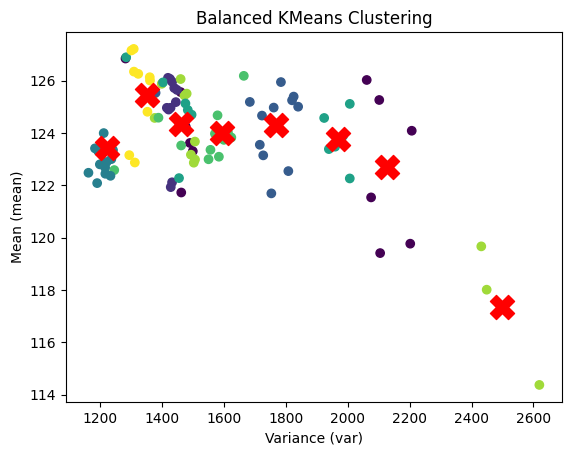

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 7073.51it/s]


Epoch 1/100
204/204 [==============================] - 15s 62ms/step - loss: 1.0617 - n2v_mse: 1.0617 - n2v_abs: 0.8098 - val_loss: 0.8460 - val_n2v_mse: 0.8456 - val_n2v_abs: 0.7310
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8364 - n2v_mse: 0.8364 - n2v_abs: 0.7226 - val_loss: 0.7963 - val_n2v_mse: 0.7960 - val_n2v_abs: 0.7073
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8273 - n2v_mse: 0.8273 - n2v_abs: 0.7220 - val_loss: 0.8103 - val_n2v_mse: 0.8100 - val_n2v_abs: 0.7122
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8318 - n2v_mse: 0.8318 - n2v_abs: 0.7245 - val_loss: 0.8028 - val_n2v_mse: 0.8024 - val_n2v_abs: 0.7114
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8151 - n2v_mse: 0.8151 - n2v_abs: 0.7143 - val_loss: 0.7991 - val_n2v_mse: 0.7987 - val_n2v_abs: 0.7072
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8301 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.31it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2736.18it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.1266 - n2v_mse: 1.1266 - n2v_abs: 0.8357 - val_loss: 0.9248 - val_n2v_mse: 0.9198 - val_n2v_abs: 0.7606
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8439 - n2v_mse: 0.8439 - n2v_abs: 0.7275 - val_loss: 0.8447 - val_n2v_mse: 0.8411 - val_n2v_abs: 0.7263
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8300 - n2v_mse: 0.8300 - n2v_abs: 0.7185 - val_loss: 0.8436 - val_n2v_mse: 0.8409 - val_n2v_abs: 0.7263
Epoch 4/100
102/102 [==============================] - 11s 103ms/step - loss: 0.8303 - n2v_mse: 0.8303 - n2v_abs: 0.7208 - val_loss: 0.7998 - val_n2v_mse: 0.7955 - val_n2v_abs: 0.7018
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8211 - n2v_mse: 0.8211 - n2v_abs: 0.7182 - val_loss: 0.7801 - val_n2v_mse: 0.7762 - val_n2v_abs: 0.6936
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 717.67it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.7689 - n2v_mse: 1.7689 - n2v_abs: 1.0471 - val_loss: 1.1651 - val_n2v_mse: 1.1620 - val_n2v_abs: 0.8583
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8542 - n2v_mse: 0.8542 - n2v_abs: 0.7334 - val_loss: 0.9078 - val_n2v_mse: 0.9057 - val_n2v_abs: 0.7524
Epoch 3/100
51/51 [==============================] - 10s 202ms/step - loss: 0.8318 - n2v_mse: 0.8318 - n2v_abs: 0.7215 - val_loss: 0.8776 - val_n2v_mse: 0.8755 - val_n2v_abs: 0.7394
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8113 - n2v_mse: 0.8113 - n2v_abs: 0.7118 - val_loss: 0.8476 - val_n2v_mse: 0.8455 - val_n2v_abs: 0.7271
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8255 - n2v_mse: 0.8255 - n2v_abs: 0.7198 - val_loss: 0.9040 - val_n2v_mse: 0.9022 - val_n2v_abs: 0.7537
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8317 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.24it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2702.80it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.7940 - n2v_mse: 0.7940 - n2v_abs: 0.7018 - val_loss: 0.7027 - val_n2v_mse: 0.7007 - val_n2v_abs: 0.6651
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7897 - n2v_mse: 0.7897 - n2v_abs: 0.7008 - val_loss: 0.7350 - val_n2v_mse: 0.7323 - val_n2v_abs: 0.6743
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7802 - n2v_mse: 0.7802 - n2v_abs: 0.6949 - val_loss: 0.7033 - val_n2v_mse: 0.7011 - val_n2v_abs: 0.6643
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7975 - n2v_mse: 0.7975 - n2v_abs: 0.7052 - val_loss: 0.7664 - val_n2v_mse: 0.7626 - val_n2v_abs: 0.6856
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7929 - n2v_mse: 0.7929 - n2v_abs: 0.7009 - val_loss: 0.7044 - val_n2v_mse: 0.7018 - val_n2v_abs: 0.6634
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7916 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.39it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2617.94it/s]


Epoch 1/20
102/102 [==============================] - 13s 108ms/step - loss: 0.7750 - n2v_mse: 0.7750 - n2v_abs: 0.6933 - val_loss: 0.7044 - val_n2v_mse: 0.7015 - val_n2v_abs: 0.6695
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7777 - n2v_mse: 0.7777 - n2v_abs: 0.6933 - val_loss: 0.7018 - val_n2v_mse: 0.6986 - val_n2v_abs: 0.6682
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7792 - n2v_mse: 0.7792 - n2v_abs: 0.6951 - val_loss: 0.6984 - val_n2v_mse: 0.6949 - val_n2v_abs: 0.6669
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7760 - n2v_mse: 0.7760 - n2v_abs: 0.6942 - val_loss: 0.6986 - val_n2v_mse: 0.6952 - val_n2v_abs: 0.6673
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7870 - n2v_mse: 0.7870 - n2v_abs: 0.6982 - val_loss: 0.6990 - val_n2v_mse: 0.6961 - val_n2v_abs: 0.6669
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7766 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2578.47it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.7318 - n2v_mse: 0.7318 - n2v_abs: 0.6794 - val_loss: 0.7074 - val_n2v_mse: 0.7071 - val_n2v_abs: 0.6678
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7250 - n2v_mse: 0.7250 - n2v_abs: 0.6734 - val_loss: 0.7310 - val_n2v_mse: 0.7302 - val_n2v_abs: 0.6771
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7283 - n2v_mse: 0.7283 - n2v_abs: 0.6759 - val_loss: 0.7116 - val_n2v_mse: 0.7110 - val_n2v_abs: 0.6697
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7228 - n2v_mse: 0.7228 - n2v_abs: 0.6733 - val_loss: 0.7121 - val_n2v_mse: 0.7114 - val_n2v_abs: 0.6701
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7270 - n2v_mse: 0.7270 - n2v_abs: 0.6770 - val_loss: 0.7049 - val_n2v_mse: 0.7042 - val_n2v_abs: 0.6662
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.7296 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.12it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.02it/s]


/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24379.tif
0


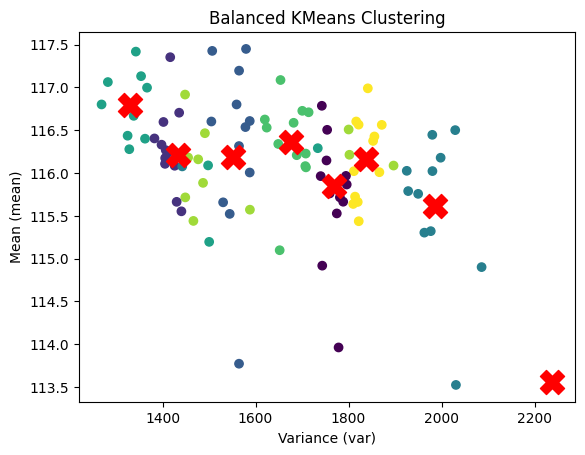

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6811.38it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.9012 - n2v_mse: 0.9012 - n2v_abs: 0.7477 - val_loss: 0.8147 - val_n2v_mse: 0.8147 - val_n2v_abs: 0.7191
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.7102 - n2v_mse: 0.7102 - n2v_abs: 0.6665 - val_loss: 0.7682 - val_n2v_mse: 0.7683 - val_n2v_abs: 0.6956
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6954 - n2v_mse: 0.6954 - n2v_abs: 0.6601 - val_loss: 0.7682 - val_n2v_mse: 0.7683 - val_n2v_abs: 0.6962
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6892 - n2v_mse: 0.6892 - n2v_abs: 0.6564 - val_loss: 0.7658 - val_n2v_mse: 0.7659 - val_n2v_abs: 0.6939
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6904 - n2v_mse: 0.6904 - n2v_abs: 0.6599 - val_loss: 0.8565 - val_n2v_mse: 0.8567 - val_n2v_abs: 0.7285
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6959 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.42it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2787.62it/s]


Epoch 1/100
102/102 [==============================] - 13s 108ms/step - loss: 0.9712 - n2v_mse: 0.9712 - n2v_abs: 0.7736 - val_loss: 0.8668 - val_n2v_mse: 0.8710 - val_n2v_abs: 0.7458
Epoch 2/100
102/102 [==============================] - 11s 103ms/step - loss: 0.7000 - n2v_mse: 0.7000 - n2v_abs: 0.6632 - val_loss: 0.8013 - val_n2v_mse: 0.8068 - val_n2v_abs: 0.7163
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6960 - n2v_mse: 0.6960 - n2v_abs: 0.6617 - val_loss: 0.7795 - val_n2v_mse: 0.7856 - val_n2v_abs: 0.7062
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.7044 - n2v_mse: 0.7044 - n2v_abs: 0.6650 - val_loss: 0.7709 - val_n2v_mse: 0.7777 - val_n2v_abs: 0.7023
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6809 - n2v_mse: 0.6809 - n2v_abs: 0.6522 - val_loss: 0.7755 - val_n2v_mse: 0.7822 - val_n2v_abs: 0.7044
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.15it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 709.05it/s]


Epoch 1/100
51/51 [==============================] - 13s 213ms/step - loss: 1.0231 - n2v_mse: 1.0231 - n2v_abs: 0.7936 - val_loss: 0.9018 - val_n2v_mse: 0.9029 - val_n2v_abs: 0.7608
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7125 - n2v_mse: 0.7125 - n2v_abs: 0.6675 - val_loss: 0.8385 - val_n2v_mse: 0.8397 - val_n2v_abs: 0.7334
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7093 - n2v_mse: 0.7093 - n2v_abs: 0.6642 - val_loss: 0.8168 - val_n2v_mse: 0.8180 - val_n2v_abs: 0.7237
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7086 - n2v_mse: 0.7086 - n2v_abs: 0.6672 - val_loss: 0.7933 - val_n2v_mse: 0.7946 - val_n2v_abs: 0.7121
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6876 - n2v_mse: 0.6876 - n2v_abs: 0.6558 - val_loss: 0.7733 - val_n2v_mse: 0.7747 - val_n2v_abs: 0.7026
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6946 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.32it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_64_blocks
  warnings.warn(


8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2603.38it/s]


Epoch 1/50
102/102 [==============================] - 13s 109ms/step - loss: 0.6923 - n2v_mse: 0.6923 - n2v_abs: 0.6582 - val_loss: 0.7676 - val_n2v_mse: 0.7667 - val_n2v_abs: 0.6945
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6950 - n2v_mse: 0.6950 - n2v_abs: 0.6592 - val_loss: 0.7461 - val_n2v_mse: 0.7459 - val_n2v_abs: 0.6855
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6962 - n2v_mse: 0.6962 - n2v_abs: 0.6592 - val_loss: 0.7594 - val_n2v_mse: 0.7591 - val_n2v_abs: 0.6915
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6983 - n2v_mse: 0.6983 - n2v_abs: 0.6598 - val_loss: 0.7436 - val_n2v_mse: 0.7433 - val_n2v_abs: 0.6849
Epoch 5/50
102/102 [==============================] - 11s 104ms/step - loss: 0.6926 - n2v_mse: 0.6926 - n2v_abs: 0.6578 - val_loss: 0.8120 - val_n2v_mse: 0.8130 - val_n2v_abs: 0.7138
Epoch 6/50
102/102 [==============================] - 11s 104ms/step - loss: 0.7047 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2715.42it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.6803 - n2v_mse: 0.6803 - n2v_abs: 0.6548 - val_loss: 0.6522 - val_n2v_mse: 0.6523 - val_n2v_abs: 0.6427
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6801 - n2v_mse: 0.6801 - n2v_abs: 0.6535 - val_loss: 0.6739 - val_n2v_mse: 0.6746 - val_n2v_abs: 0.6557
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6760 - n2v_mse: 0.6760 - n2v_abs: 0.6522 - val_loss: 0.6524 - val_n2v_mse: 0.6525 - val_n2v_abs: 0.6431
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6925 - n2v_mse: 0.6925 - n2v_abs: 0.6605 - val_loss: 0.6504 - val_n2v_mse: 0.6506 - val_n2v_abs: 0.6423
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6766 - n2v_mse: 0.6766 - n2v_abs: 0.6529 - val_loss: 0.6534 - val_n2v_mse: 0.6538 - val_n2v_abs: 0.6435
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6763 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2805.42it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.6652 - n2v_mse: 0.6652 - n2v_abs: 0.6454 - val_loss: 0.6646 - val_n2v_mse: 0.6655 - val_n2v_abs: 0.6491
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6579 - n2v_mse: 0.6579 - n2v_abs: 0.6427 - val_loss: 0.6776 - val_n2v_mse: 0.6784 - val_n2v_abs: 0.6543
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6593 - n2v_mse: 0.6593 - n2v_abs: 0.6436 - val_loss: 0.6658 - val_n2v_mse: 0.6663 - val_n2v_abs: 0.6494
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6590 - n2v_mse: 0.6590 - n2v_abs: 0.6438 - val_loss: 0.6669 - val_n2v_mse: 0.6678 - val_n2v_abs: 0.6497
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6560 - n2v_mse: 0.6560 - n2v_abs: 0.6440 - val_loss: 0.6723 - val_n2v_mse: 0.6730 - val_n2v_abs: 0.6522
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6600 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.17it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
4
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2628.61it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.6431 - n2v_mse: 0.6431 - n2v_abs: 0.6340 - val_loss: 0.6960 - val_n2v_mse: 0.6933 - val_n2v_abs: 0.6580
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6591 - n2v_mse: 0.6591 - n2v_abs: 0.6454 - val_loss: 0.6718 - val_n2v_mse: 0.6695 - val_n2v_abs: 0.6484
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6557 - n2v_mse: 0.6557 - n2v_abs: 0.6393 - val_loss: 0.6664 - val_n2v_mse: 0.6644 - val_n2v_abs: 0.6464
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6664 - n2v_mse: 0.6664 - n2v_abs: 0.6455 - val_loss: 0.6671 - val_n2v_mse: 0.6650 - val_n2v_abs: 0.6470
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6529 - n2v_mse: 0.6529 - n2v_abs: 0.6385 - val_loss: 0.6677 - val_n2v_mse: 0.6656 - val_n2v_abs: 0.6471
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6496 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.36it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
5
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2666.63it/s]


Epoch 1/20
102/102 [==============================] - 13s 109ms/step - loss: 0.6272 - n2v_mse: 0.6272 - n2v_abs: 0.6276 - val_loss: 0.6747 - val_n2v_mse: 0.6761 - val_n2v_abs: 0.6553
Epoch 2/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6363 - n2v_mse: 0.6363 - n2v_abs: 0.6333 - val_loss: 0.6758 - val_n2v_mse: 0.6772 - val_n2v_abs: 0.6551
Epoch 3/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6449 - n2v_mse: 0.6449 - n2v_abs: 0.6387 - val_loss: 0.6858 - val_n2v_mse: 0.6875 - val_n2v_abs: 0.6595
Epoch 4/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6224 - n2v_mse: 0.6224 - n2v_abs: 0.6254 - val_loss: 0.6753 - val_n2v_mse: 0.6769 - val_n2v_abs: 0.6556
Epoch 5/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6323 - n2v_mse: 0.6323 - n2v_abs: 0.6297 - val_loss: 0.6825 - val_n2v_mse: 0.6848 - val_n2v_abs: 0.6588
Epoch 6/20
102/102 [==============================] - 11s 104ms/step - loss: 0.6359 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.13it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.08it/s]


/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24382.tif
0


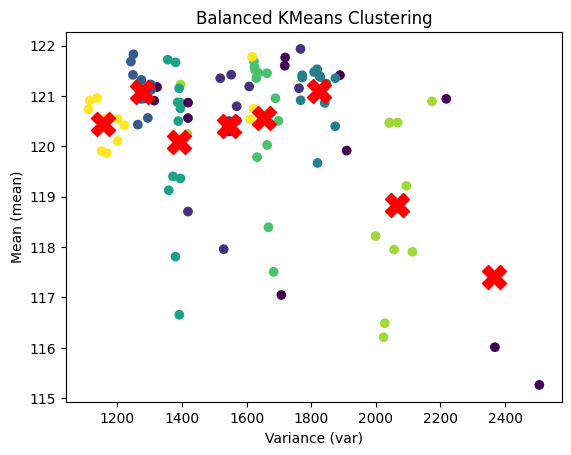

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6514.73it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 1.0890 - n2v_mse: 1.0890 - n2v_abs: 0.8216 - val_loss: 0.8519 - val_n2v_mse: 0.8518 - val_n2v_abs: 0.7383
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.8258 - n2v_mse: 0.8258 - n2v_abs: 0.7196 - val_loss: 0.8263 - val_n2v_mse: 0.8261 - val_n2v_abs: 0.7245
Epoch 3/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8185 - n2v_mse: 0.8185 - n2v_abs: 0.7154 - val_loss: 0.8134 - val_n2v_mse: 0.8133 - val_n2v_abs: 0.7216
Epoch 4/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8378 - n2v_mse: 0.8378 - n2v_abs: 0.7214 - val_loss: 0.8105 - val_n2v_mse: 0.8104 - val_n2v_abs: 0.7198
Epoch 5/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8206 - n2v_mse: 0.8206 - n2v_abs: 0.7153 - val_loss: 0.8111 - val_n2v_mse: 0.8110 - val_n2v_abs: 0.7213
Epoch 6/100
204/204 [==============================] - 12s 61ms/step - loss: 0.8135 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.19it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2615.33it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 1.1233 - n2v_mse: 1.1233 - n2v_abs: 0.8349 - val_loss: 0.9562 - val_n2v_mse: 0.9565 - val_n2v_abs: 0.7802
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8434 - n2v_mse: 0.8434 - n2v_abs: 0.7255 - val_loss: 0.8633 - val_n2v_mse: 0.8629 - val_n2v_abs: 0.7388
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8313 - n2v_mse: 0.8313 - n2v_abs: 0.7203 - val_loss: 0.9560 - val_n2v_mse: 0.9565 - val_n2v_abs: 0.7800
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8166 - n2v_mse: 0.8166 - n2v_abs: 0.7163 - val_loss: 0.8588 - val_n2v_mse: 0.8586 - val_n2v_abs: 0.7390
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.8206 - n2v_mse: 0.8206 - n2v_abs: 0.7171 - val_loss: 0.8158 - val_n2v_mse: 0.8152 - val_n2v_abs: 0.7187
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.17it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 752.18it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1320 - n2v_mse: 1.1320 - n2v_abs: 0.8386 - val_loss: 0.9426 - val_n2v_mse: 0.9406 - val_n2v_abs: 0.7743
Epoch 2/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8370 - n2v_mse: 0.8370 - n2v_abs: 0.7248 - val_loss: 0.9108 - val_n2v_mse: 0.9093 - val_n2v_abs: 0.7642
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8354 - n2v_mse: 0.8354 - n2v_abs: 0.7233 - val_loss: 0.8577 - val_n2v_mse: 0.8563 - val_n2v_abs: 0.7393
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8184 - n2v_mse: 0.8184 - n2v_abs: 0.7159 - val_loss: 0.8433 - val_n2v_mse: 0.8420 - val_n2v_abs: 0.7306
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.8226 - n2v_mse: 0.8226 - n2v_abs: 0.7175 - val_loss: 0.8431 - val_n2v_mse: 0.8422 - val_n2v_abs: 0.7340
Epoch 6/100
51/51 [==============================] - 10s 203ms/step - loss: 0.7996 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.08it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_128_blocks
  warnings.warn(


32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 690.89it/s]


Epoch 1/50
51/51 [==============================] - 13s 212ms/step - loss: 0.8275 - n2v_mse: 0.8275 - n2v_abs: 0.7180 - val_loss: 0.9175 - val_n2v_mse: 0.9137 - val_n2v_abs: 0.7544
Epoch 2/50
51/51 [==============================] - 10s 203ms/step - loss: 0.7987 - n2v_mse: 0.7987 - n2v_abs: 0.7061 - val_loss: 1.2704 - val_n2v_mse: 1.2614 - val_n2v_abs: 0.8776
Epoch 3/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8143 - n2v_mse: 0.8143 - n2v_abs: 0.7135 - val_loss: 0.8203 - val_n2v_mse: 0.8161 - val_n2v_abs: 0.7138
Epoch 4/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8350 - n2v_mse: 0.8350 - n2v_abs: 0.7220 - val_loss: 0.8186 - val_n2v_mse: 0.8141 - val_n2v_abs: 0.7120
Epoch 5/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8106 - n2v_mse: 0.8106 - n2v_abs: 0.7121 - val_loss: 0.8275 - val_n2v_mse: 0.8229 - val_n2v_abs: 0.7129
Epoch 6/50
51/51 [==============================] - 10s 203ms/step - loss: 0.8215 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.11it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 740.03it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8033 - n2v_mse: 0.8033 - n2v_abs: 0.7057 - val_loss: 0.8467 - val_n2v_mse: 0.8418 - val_n2v_abs: 0.7224
Epoch 2/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7846 - n2v_mse: 0.7846 - n2v_abs: 0.7001 - val_loss: 0.8460 - val_n2v_mse: 0.8410 - val_n2v_abs: 0.7205
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8055 - n2v_mse: 0.8055 - n2v_abs: 0.7099 - val_loss: 1.1924 - val_n2v_mse: 1.1823 - val_n2v_abs: 0.8279
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8030 - n2v_mse: 0.8030 - n2v_abs: 0.7091 - val_loss: 0.8471 - val_n2v_mse: 0.8419 - val_n2v_abs: 0.7210
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7951 - n2v_mse: 0.7951 - n2v_abs: 0.7045 - val_loss: 0.8599 - val_n2v_mse: 0.8553 - val_n2v_abs: 0.7278
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7952 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.20it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 738.30it/s]


Epoch 1/20
51/51 [==============================] - 13s 213ms/step - loss: 0.8031 - n2v_mse: 0.8031 - n2v_abs: 0.7066 - val_loss: 0.6863 - val_n2v_mse: 0.6834 - val_n2v_abs: 0.6539
Epoch 2/20
51/51 [==============================] - 10s 202ms/step - loss: 0.8053 - n2v_mse: 0.8053 - n2v_abs: 0.7080 - val_loss: 0.6854 - val_n2v_mse: 0.6824 - val_n2v_abs: 0.6546
Epoch 3/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8255 - n2v_mse: 0.8255 - n2v_abs: 0.7171 - val_loss: 0.6786 - val_n2v_mse: 0.6756 - val_n2v_abs: 0.6508
Epoch 4/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8182 - n2v_mse: 0.8182 - n2v_abs: 0.7150 - val_loss: 0.6775 - val_n2v_mse: 0.6746 - val_n2v_abs: 0.6502
Epoch 5/20
51/51 [==============================] - 10s 203ms/step - loss: 0.8056 - n2v_mse: 0.8056 - n2v_abs: 0.7088 - val_loss: 0.6797 - val_n2v_mse: 0.6765 - val_n2v_abs: 0.6508
Epoch 6/20
51/51 [==============================] - 10s 203ms/step - loss: 0.7915 - n2v_mse: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.10it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.07it/s]


/root/data/HRTEM W on GO/1764 W 100 mA 2.5 s _250kX_K3_200kV_24380.tif
0


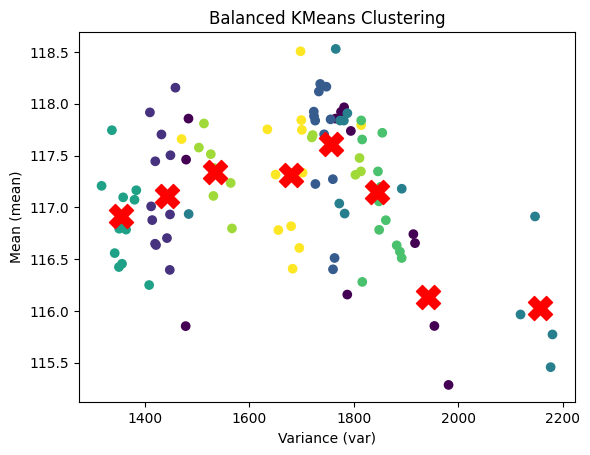

Samples per cluster: [12 12 12 12 12 12 12 12]
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6582.27it/s]


Epoch 1/100
204/204 [==============================] - 15s 63ms/step - loss: 0.9680 - n2v_mse: 0.9680 - n2v_abs: 0.7601 - val_loss: 0.6851 - val_n2v_mse: 0.6850 - val_n2v_abs: 0.6630
Epoch 2/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6189 - n2v_mse: 0.6189 - n2v_abs: 0.6175 - val_loss: 0.6299 - val_n2v_mse: 0.6297 - val_n2v_abs: 0.6340
Epoch 3/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6131 - n2v_mse: 0.6131 - n2v_abs: 0.6124 - val_loss: 0.6161 - val_n2v_mse: 0.6160 - val_n2v_abs: 0.6262
Epoch 4/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6120 - n2v_mse: 0.6120 - n2v_abs: 0.6129 - val_loss: 0.6192 - val_n2v_mse: 0.6190 - val_n2v_abs: 0.6279
Epoch 5/100
204/204 [==============================] - 12s 60ms/step - loss: 0.5958 - n2v_mse: 0.5958 - n2v_abs: 0.6050 - val_loss: 0.6117 - val_n2v_mse: 0.6115 - val_n2v_abs: 0.6226
Epoch 6/100
204/204 [==============================] - 12s 60ms/step - loss: 0.6022 -

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.28it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
Generated patches: (512, 64, 64, 1)
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 1639/1639 [00:00<00:00, 2088.74it/s]


Epoch 1/100
102/102 [==============================] - 13s 109ms/step - loss: 0.8867 - n2v_mse: 0.8867 - n2v_abs: 0.7338 - val_loss: 0.7390 - val_n2v_mse: 0.7416 - val_n2v_abs: 0.6866
Epoch 2/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6235 - n2v_mse: 0.6235 - n2v_abs: 0.6186 - val_loss: 0.7137 - val_n2v_mse: 0.7156 - val_n2v_abs: 0.6754
Epoch 3/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6011 - n2v_mse: 0.6011 - n2v_abs: 0.6061 - val_loss: 0.6386 - val_n2v_mse: 0.6402 - val_n2v_abs: 0.6393
Epoch 4/100
102/102 [==============================] - 11s 104ms/step - loss: 0.6084 - n2v_mse: 0.6084 - n2v_abs: 0.6094 - val_loss: 0.6254 - val_n2v_mse: 0.6269 - val_n2v_abs: 0.6323
Epoch 5/100
102/102 [==============================] - 11s 104ms/step - loss: 0.5937 - n2v_mse: 0.5937 - n2v_abs: 0.6023 - val_loss: 0.6124 - val_n2v_mse: 0.6143 - val_n2v_abs: 0.6258
Epoch 6/100
102/102 [==============================] - 11s 104ms/step - loss: 0.

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.06it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
Generated patches: (128, 128, 128, 1)
32 blind-spots will be generated per training patch of size (128, 128).


Preparing validation data: 100%|█████████████| 410/410 [00:00<00:00, 727.65it/s]


Epoch 1/100
51/51 [==============================] - 13s 212ms/step - loss: 1.1339 - n2v_mse: 1.1339 - n2v_abs: 0.8346 - val_loss: 0.8171 - val_n2v_mse: 0.8158 - val_n2v_abs: 0.7206
Epoch 2/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6282 - n2v_mse: 0.6282 - n2v_abs: 0.6205 - val_loss: 0.8041 - val_n2v_mse: 0.8033 - val_n2v_abs: 0.7118
Epoch 3/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6141 - n2v_mse: 0.6141 - n2v_abs: 0.6167 - val_loss: 0.6991 - val_n2v_mse: 0.6985 - val_n2v_abs: 0.6657
Epoch 4/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6180 - n2v_mse: 0.6180 - n2v_abs: 0.6153 - val_loss: 0.6722 - val_n2v_mse: 0.6718 - val_n2v_abs: 0.6516
Epoch 5/100
51/51 [==============================] - 10s 203ms/step - loss: 0.6040 - n2v_mse: 0.6040 - n2v_abs: 0.6078 - val_loss: 0.6792 - val_n2v_mse: 0.6791 - val_n2v_abs: 0.6534
Epoch 6/100
51/51 [==============================] - 10s 202ms/step - loss: 0.6102 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.25it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
1
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)


/root/miniconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/clustered_blocks/models/n2v_32_blocks
  warnings.warn(


2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:01<00:00, 6533.67it/s]


Epoch 1/50
204/204 [==============================] - 15s 63ms/step - loss: 0.5630 - n2v_mse: 0.5630 - n2v_abs: 0.5874 - val_loss: 0.5465 - val_n2v_mse: 0.5464 - val_n2v_abs: 0.5868
Epoch 2/50
204/204 [==============================] - 12s 61ms/step - loss: 0.5586 - n2v_mse: 0.5586 - n2v_abs: 0.5844 - val_loss: 0.5509 - val_n2v_mse: 0.5508 - val_n2v_abs: 0.5895
Epoch 3/50
204/204 [==============================] - 12s 61ms/step - loss: 0.5574 - n2v_mse: 0.5574 - n2v_abs: 0.5828 - val_loss: 0.5561 - val_n2v_mse: 0.5560 - val_n2v_abs: 0.5917
Epoch 4/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5572 - n2v_mse: 0.5572 - n2v_abs: 0.5834 - val_loss: 0.5490 - val_n2v_mse: 0.5489 - val_n2v_abs: 0.5882
Epoch 5/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5548 - n2v_mse: 0.5548 - n2v_abs: 0.5831 - val_loss: 0.5683 - val_n2v_mse: 0.5682 - val_n2v_abs: 0.5984
Epoch 6/50
204/204 [==============================] - 12s 60ms/step - loss: 0.5741 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
2
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6577.31it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.5524 - n2v_mse: 0.5524 - n2v_abs: 0.5830 - val_loss: 0.5580 - val_n2v_mse: 0.5581 - val_n2v_abs: 0.5865
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5435 - n2v_mse: 0.5435 - n2v_abs: 0.5806 - val_loss: 0.5688 - val_n2v_mse: 0.5690 - val_n2v_abs: 0.5916
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5399 - n2v_mse: 0.5399 - n2v_abs: 0.5776 - val_loss: 0.6450 - val_n2v_mse: 0.6451 - val_n2v_abs: 0.6156
Epoch 4/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5428 - n2v_mse: 0.5428 - n2v_abs: 0.5789 - val_loss: 0.5625 - val_n2v_mse: 0.5627 - val_n2v_abs: 0.5902
Epoch 5/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5353 - n2v_mse: 0.5353 - n2v_abs: 0.5740 - val_loss: 0.5590 - val_n2v_mse: 0.5592 - val_n2v_abs: 0.5885
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5362 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.23it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False
3
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
Generated patches: (2048, 32, 32, 1)
2 blind-spots will be generated per training patch of size (32, 32).


Preparing validation data: 100%|██████████| 6554/6554 [00:00<00:00, 6727.22it/s]


Epoch 1/20
204/204 [==============================] - 15s 63ms/step - loss: 0.4961 - n2v_mse: 0.4961 - n2v_abs: 0.5559 - val_loss: 0.5168 - val_n2v_mse: 0.5169 - val_n2v_abs: 0.5666
Epoch 2/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4937 - n2v_mse: 0.4937 - n2v_abs: 0.5541 - val_loss: 0.5188 - val_n2v_mse: 0.5188 - val_n2v_abs: 0.5677
Epoch 3/20
204/204 [==============================] - 12s 60ms/step - loss: 0.5026 - n2v_mse: 0.5026 - n2v_abs: 0.5589 - val_loss: 0.5181 - val_n2v_mse: 0.5181 - val_n2v_abs: 0.5679
Epoch 4/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4943 - n2v_mse: 0.4943 - n2v_abs: 0.5532 - val_loss: 0.5168 - val_n2v_mse: 0.5168 - val_n2v_abs: 0.5662
Epoch 5/20
204/204 [==============================] - 12s 61ms/step - loss: 0.4957 - n2v_mse: 0.4957 - n2v_abs: 0.5537 - val_loss: 0.5194 - val_n2v_mse: 0.5194 - val_n2v_abs: 0.5686
Epoch 6/20
204/204 [==============================] - 12s 60ms/step - loss: 0.4964 - n2v_m

100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.14it/s]


Loading pretrained model NIMA from /root/.cache/torch/hub/checkpoints/NIMA-spaq-46a7fcb7.pth
False


100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  7.26it/s]


In [5]:
pp = []
loop_scores_list = []#####
duration_list = []######
for path in paths:
    print(path)
    loop_scores = []######
    img = load_image(path)
    signal = 1
    n = 0
    sub_blocks = []
    best_score = 0
    max_loop = 1
    no_improve = 0
    max_tolerant = 3
    start_time = time.time()
    while(signal):
        print(n)
        #Determine whether the picture is a big picture, and define the training set data. If it is a big picture, take 16 of the blocks for training; otherwise, put the whole picture into the training set, and zero the signal to stop the cycle
        if check_image_size(img):
            if n == 0:
                blocks, positions = split_array_with_dynamic_step(img,(512, 512),512)
            #sorted_index,variances= calculate_variances_and_sort(blocks)
                pick_size = get_pick_size(len(blocks))
                max_loop = get_max_loop(len(blocks))
                dict_cluster = get_cluster_index(blocks)
            train_blocks = []
            for i in range(2):
                for i in dict_cluster.keys():
                    train_blocks.append(blocks[dict_cluster[i].pop()])
            # for i in dict_cluster.keys():
            #     train_blocks.append(blocks[dict_cluster[i].pop()])
            # train_blocks      
        else:
            blocks = [img]
            train_blocks = blocks
        t_e = get_train_epoch(n)
        #print(s_index,e_index)#####
        #print(maxv_index,maxv_index+index_move)
        #print(minv_index,minv_index+index_move)
        if n == 0:
            #Define patch_size_list, generate training set and test set, cycle patch_size training model, calculate the score to find the optimal value
            #The optimal value is included in best_score, and the optimal model parameters are stored in best_model
            patch_size_list = [32,64,128]
            diffp_scores_list = []
            for patch_size in patch_size_list:
                imgs,X,X_val = dataprocessing(train_blocks,patch_size)
                train_batch = get_batch_size(patch_size)
                parameters = [train_batch,t_e,patch_size]
                model_name = f"n2v_{patch_size}_blocks"
                model = init_and_train_model(parameters,model_name,X,X_val)
                pred = model.predict(img,axes='YX',n_tiles=(4,8))
                score = get_iq_score(pred,"nima-spaq")
                diffp_scores_list.append(score)
            best_score = max(diffp_scores_list)
            max_index = diffp_scores_list.index(best_score)
            best_patch_size = patch_size_list[max_index]
            pp.append(best_patch_size)
            model_name = f"n2v_{best_patch_size}_blocks"
            save_best_model_weight(model_name)
            save_current_model_weight(model_name)
            patch_size = best_patch_size 
            train_batch = get_batch_size(patch_size)
            loop_scores.append(best_score)######
            n = n+1
        else:
            #Select the optimal model to continue training, calculate the score, save the model parameters to continue the cycle if the score increases, and stop the cycle if the score does not drop more than a certain number of times
            imgs,X,X_val = dataprocessing(train_blocks,patch_size)
            parameters = [train_batch,t_e,patch_size]
            model = load_and_train_model(parameters,model_name,X,X_val)
            pred = model.predict(img,axes='YX',n_tiles=(4,8))
            save_current_model_weight(model_name)
            score = get_iq_score(pred,"nima-spaq")
            loop_scores.append(score)
            if score > best_score:
                best_score = score
                save_best_model_weight(model_name)
                no_improve = 0
            else:
                no_improve +=1
            n = n+1
        if n >= max_loop:
            signal = 0
        if no_improve >= max_tolerant:
            signal = 0

    #Load the optimal model parameters and output the forecast picture
    model = load_best_model(parameters,model_name)
    pred = model.predict(img,axes='YX',n_tiles=(4,8))
    end_time = time.time()
    name = path.split("/")[-1][0:-4]
    #np.save(f"./preds/{name}.npy",pred)
    np.save(f"./preds/{name}.npy",pred)
    shutil.rmtree("./models")
    duration = end_time-start_time
    duration_list.append(duration)#####
    loop_scores_list.append(loop_scores)#####

In [8]:
duration_list

[4432.019616603851,
 4841.5741374492645,
 4563.285848379135,
 4874.131717205048,
 4390.326258182526,
 5070.968962192535,
 4831.696936368942,
 4655.073411464691,
 4570.470589876175,
 5102.69091796875,
 4426.832046747208,
 4840.252248287201,
 4424.715079545975,
 1154.4096994400024,
 4845.896089315414,
 5084.647454500198,
 4405.67794752121,
 4579.675662517548,
 4431.952936410904,
 5096.2234582901,
 4654.921755075455,
 5103.0287091732025,
 5100.562232971191,
 4882.2986125946045,
 4886.010380744934,
 4407.842081785202,
 4847.069583892822,
 4883.218293905258,
 4853.154736757278,
 5103.0260944366455]

In [9]:
loop_scores_list

[[41.68043518066406, 41.25568389892578, 40.994747161865234, 41.35593032836914],
 [30.199857711791992,
  30.09299659729004,
  31.144350051879883,
  29.56650161743164,
  28.823244094848633,
  27.282777786254883],
 [53.732059478759766, 53.530479431152344, 53.0494270324707, 51.88569641113281],
 [53.60755920410156,
  54.25006866455078,
  51.7421989440918,
  51.06466293334961,
  55.287559509277344,
  54.142005920410156],
 [52.23257827758789, 50.52052688598633, 50.31776809692383, 51.28437042236328],
 [40.56679916381836,
  40.00565719604492,
  37.02706527709961,
  47.73412322998047,
  45.09800338745117,
  39.215110778808594],
 [46.20066833496094,
  44.918949127197266,
  45.98978042602539,
  46.22420120239258,
  46.32518005371094,
  44.89779281616211],
 [48.51945114135742,
  50.210140228271484,
  48.79936599731445,
  48.60185241699219,
  46.90771484375],
 [48.949710845947266, 39.80621337890625, 47.5540885925293, 39.40147399902344],
 [42.805843353271484,
  42.38887023925781,
  42.52328872680664,